# Using the Transformer Networks

This notebook will guide you through the usage of a provided efficient implementation of Transformer Networks, to experiment with hyper-parameters and to perform ablation studies. This notebook will let you master accomplishing experiments with Transformer Networks and analyising the outcomes. Complete the code snippets where request and provide your observations. Feel free to refer the paper [Under the Hood of Transformer Networks for Trajectory Forecasting](https://arxiv.org/abs/2203.11878).

 

# Initial setup

Only if you run from Google Colab run those 2 cells to sync with Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/TF4AML/

/content/drive/MyDrive/TF4AML


Start with the import

In [ ]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy
import os
import time

from transformer import baselineUtils
from transformer import individual_TF
from transformer.batch import subsequent_mask
from transformer.noam_opt import NoamOpt

In [ ]:
# Select GPU device for the training if available
if not torch.cuda.is_available():
    device=torch.device("cpu")
    print("Current device:", device)
else:
    device=torch.device("cuda")
    print("Current device:", device, "- Type:", torch.cuda.get_device_name(0))

Current device: cuda - Type: NVIDIA GeForce RTX 2070


# Training and Testing

## Data Loading (setup the dataset for train, validation and test)

The subdatasets are 5 (ETH, Hotel, Univ, Zara1 and Zara2) we will leave one of them out for testing and train on the other 4. 

I.e. choosing ```dataset_name = 'zara1'``` the training set is composed by ETH, Hotel, Univ and Zara2 and tested on Zara1.

Moreover you can train and validate on a portion of the dataset setting percentage of the data (default is 50).

------ 

Each sequence is composed by an observed part to train the Encoder and a part we are attempting to predict with the Decoder. 

Generally the standard setup plans to use the first 8 points for the observation and the following 12 for the prediction.

------ 

Each created sequence has the shape (20, 4), where: 
- $N_{obs}+N_{pred} = 8 + 12 = 20$;
- Positions + Speeds = ( $x_i,\ y_i,\ u_i,\ v_i$) = ( $x_i,\ y_i,\ x_{i+1}-x_{i},\ y_{i+1} - y_i$ )

You can easily switch input type from position to speed setting the corresponding variable.

Speeds $u_i, v_i$ are generally more robust input and allow to avoid problems with the reference system.

------ 

Note: that $(u_0, v_0) = (0,0)$ and if speed are used the observed sequence has temporal length of $N_{obs} - 1$.

In [ ]:

# Arguments to setup the datasets
dataset_name = 'zara1'
framework = 'regr'
obs_num = 8
preds_num = 12

# We limit the number of samples to a fixed percentage for the sake of time
perc_data = 50

# With predefined function we create dataset according to arguments
train_dataset,_ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=True, perc_data=perc_data, verbose=True)
val_dataset, _  = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, perc_data=perc_data, verbose=True)
test_dataset, _ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, eval=True, verbose=True)

# We create some folders to save model checkpoints
if not os.path.isdir("save_folder"):
    os.mkdir("save_folder")
if not os.path.isdir("save_folder/"+framework):
    os.mkdir("save_folder/"+framework)

if not os.path.isdir("save_folder/"+framework+"/"+dataset_name):
    os.mkdir("save_folder/"+framework+"/"+dataset_name)

start loading dataset
validation set size -> 0
001 / 007 - loading students001_train.txt
002 / 007 - loading biwi_eth_train.txt
003 / 007 - loading uni_examples_train.txt
004 / 007 - loading biwi_hotel_train.txt
005 / 007 - loading crowds_zara02_train.txt
006 / 007 - loading students003_train.txt
007 / 007 - loading crowds_zara03_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading students003_val.txt
002 / 007 - loading crowds_zara02_val.txt
003 / 007 - loading biwi_eth_val.txt
004 / 007 - loading students001_val.txt
005 / 007 - loading uni_examples_val.txt
006 / 007 - loading crowds_zara03_val.txt
007 / 007 - loading biwi_hotel_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt


In [ ]:
input_type = 'speed'

if input_type == 'speed':
    input_idx_1 = 2
    input_idx_2 = 4
    first_element = 1
    
elif input_type == 'position':
    input_idx_1 = 0
    input_idx_2 = 2
    first_element = 0

We compute the mean and standard deviation of positions or speeds across the full training dataset and use those to normalize each entry in the sequence.
This normalization is beneficial prior to processing with neural networks.

In [ ]:
# After concatenating each observed and target sequence we compute the mean and std
mean = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).mean((0,1))
std  = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).std((0,1))

Following we create a torch dataloader that create the batches for each epoch.

In [ ]:
batch_size = 512

tr_dl   = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dl  = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=0)
test_dl = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

## Model instantiation

We create an instance of our transformer with the chosen configuration. 

Then we allocate it to the GPU for forward and backward accelerated computation.

In [ ]:
# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 3
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 3

emb_size = 512
ff_size = 1024
heads = 8
layers = 6
dropout = 0.1

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

## Training and Validation Step

Here we create two classes that define the single iteration function for train and validation.

In [ ]:
def train_step(model, batch, mean, std, device):

    # If input type is speed then input (or source 'src') has shape (B, N_obs-1, 2) because the first one is (0,0).
    # Otherwise, if input type is position then input  has shape (B, N_obs, 2).
    # Note that the input of the decoder are only the first  N_pred-1  GT future value then target ('trg') has shape (B, N_pred-1, 2).
    inp    = (batch['src'][:,  first_element:, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)
    target = (batch['trg'][:, :-1, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

    # We create a third mask channel to append to the 2 speeds. 
    # This helps the decoder differentiating between start of sequence token (with mask token 1) and target speeds (with mask token 0)
    # Summarizing: start_of_seq token is (0,0) and the mask token is 1 ---> [0, 0, 1]
    #              target inputs are (u_i, v_i) and the mask token is 0 ---> [u_i, v_i, 0]
    start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(target.shape[0], 1, 1).to(device)
    target_c = torch.zeros((target.shape[0], target.shape[1], 1)).to(device)
    target = torch.cat((target, target_c), -1)
    # Final decoder input is the concatenation of them along temporal dimension
    dec_inp = torch.cat((start_of_seq, target), 1)

    # Source attention is enabled between all the observed input (mask elements are setted to 1)
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    # For the target attention we mask future elements to prevent model cheating (corresponding future mask elements are setted to False)
    # The mask is changed dinamically to use teacher forcing learning
    trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
    # Source, target and corresponding attention mask are passed to the model for the forward step
    pred = model(inp, dec_inp, src_att, trg_att)

    return pred


def eval_step(model, batch, mean, std, device, preds=12):

    # In the evaluation step we don't provide target to the decoder but we autoregressively input each prediction for the following one.
    inp = (batch['src'][:, first_element:, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

    # The decoder input is the only start of sequence token [0, 0, 1]
    # Please note that now model has to predict also the third channel mask (See loss2 in the main loop)
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(inp.shape[0], 1, 1).to(device)
    dec_inp = start_of_seq

    # We predict just one future speed and we append it to the decoder input for the next iteration (auto-regression)
    # At each step the target mask should be adapted
    for i in range(preds):
        trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
        out = model(inp, dec_inp, src_att, trg_att)
        dec_inp = torch.cat((dec_inp, out[:, -1:, :]), 1)

    # Note at the each iteration of the loop we re-append the start of seq token, so after the last iteration we need to remove it
    return dec_inp[:, 1:, :]

## Optimizer

Here we select the **optimizer** proposed in the original Transformer Networks paper of Vaswani et al.

It uses some initial warmup epochs, where the learning rate is increased. Then it slowly decreases according to a number of epoch and the chosen embedding size. The resulting formula is:

LR = $\frac{F}{\sqrt{D}} min( \frac{1}{\sqrt{epoch}},\ epoch \cdot W^{-\frac{3}{2}}) $

where F is a scaling factor, D is the model embedding size, W is the number of warmup epochs.

In [ ]:
# Argument for the optimizer 
factor = 1.
warmup = 5

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

## Main 


Then we can train, validate and test our transformer epoch by epoch.

-------

The **losses** used are 2:

1.   $L_2$-loss distance between predicted $(\hat{\textbf{u}}, \hat{\textbf{v}})$ and GT $(\textbf{u}, \textbf{v})$ target speeds;
2.   $L_1$-loss for the target token mask. Note these should be all zero, so the loss is simply the mean.

-------

Moreover, the **metrics** used to validate the model goodness at Validation and Test time are the following:

1.   Mean Average Displacement (MAD): $L_2$-distance between *all* the $N_pred$ GT and predicted future ***positions***;
2.   Final Average Displacement (FAD): $L_2$-distance between the *last* GT and predicted future ***positions***;

-------

Note: If you restart the training for any reason, remember to instanciate again model and optimizer in order to reset them.

-------

In [ ]:
train_vloss=[]
eval_vloss=[]
test_vloss=[]

train_MAD=[]
eval_MAD=[]
test_MAD=[]

train_FAD=[]
eval_FAD=[]
test_FAD=[]

lr=[]

# compute execution time of the cell
start_time = time.time()

# Argument for the training 
epoch = 0
max_epoch = 40        # Total number of epoch
ckp_save_step = 20      # Frequency for saving the model
log_step = 5         # Frequency for printing the loss


print("Start Training...\n")


for epoch in range(max_epoch):
    lr.append(optim._rate)
    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    
    for id_b, batch in enumerate(tr_dl):

        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        pred_speed = train_step(model, batch, mean, std, device)
        gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

        # We compute the two losses, averaging on the batch
        loss1 = F.pairwise_distance(pred_speed[:, :, :2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
        loss2 = torch.abs(pred_speed[:, :, 2]).mean()
        loss = loss1 + loss2

        # We accumulate and visualize the loss at the end of the epoch. 
        # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
        train_loss += loss.item() * batch['trg'].shape[0]

        loss.backward()
        optim.step()

        if input_type == 'speed':
            # If input type is speed, to compute MAD and FAD metrics we need to compute back positions from predicted speeds.
            # This is done easily adding cumulative (and denormalized) speeds to the last observed position. If last position in the input is (x_7, y_7) then:
            # (x_8, y_8)    =   (x_7, y_7) + (u_7, v_7)
            # (x_9, y_9)    =   (x_8, y_8) + (u_8, v_8)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8)
            # (x_10, y_10)  =   (x_9, y_9) + (u_9, v_9)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8) + (u_9, v_9)
            # We have always the last observed position (x_7, y_7) and we add progressively the "cumulated" speeds
            preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)

        elif input_type == 'position':
            # If input type is position, we simply append the output
            preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        

    # After concatenation we compute MAD and FAD metrics
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

    # we save the values in the lists
    train_vloss.append(train_loss/len(tr_dl))
    train_MAD.append(mad)
    train_FAD.append(fad)


    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))



    ###### VALIDATION ######
    # Here is all the same exept for eval_step and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []

        for id_b, batch in enumerate(val_dl):
            
            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            val_loss += loss.item() * batch['trg'].shape[0]

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            
        # After concatenation we compute MAD and FAD metrics
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

        # we save the values in the lists
        eval_vloss.append(val_loss/len(tr_dl))
        eval_MAD.append(mad)
        eval_FAD.append(fad)
  

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))



    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        gt = []
        pr = []
        
        for id_b, batch in enumerate(test_dl):

            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            test_loss += loss.item() * batch['trg'].shape[0]


            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])


        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)
        
        # we save the values in the lists
        test_vloss.append(test_loss/len(tr_dl))
        test_MAD.append(mad)
        test_FAD.append(fad)



        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        torch.save(model.state_dict(), f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')



# print execution time
print("Total time: %s seconds" % (time.time() - start_time))

# store
fad_base= test_FAD
mad_base= test_MAD
loss_base= test_vloss
lr_base= lr
pr_final=pr

Start Training...

---> Epoch 005/040 <---  LR: 0.00280
Total Train Loss: 270.1322 - MAD:  0.4832 - FAD:  0.7912
Total Eval  Loss: 538.8627 - MAD:  1.2410 - FAD:  2.4139
Total Test  Loss: 634.3477 - MAD:  1.8003 - FAD:  3.0220 

---> Epoch 010/040 <---  LR: 0.00260
Total Train Loss: 183.2027 - MAD:  0.2398 - FAD:  0.3018
Total Eval  Loss: 373.0375 - MAD:  0.7821 - FAD:  1.3830
Total Test  Loss: 500.5152 - MAD:  1.4351 - FAD:  2.3210 

---> Epoch 015/040 <---  LR: 0.00209
Total Train Loss: 127.4695 - MAD:  0.1414 - FAD:  0.2076
Total Eval  Loss: 270.8960 - MAD:  0.4578 - FAD:  1.0122
Total Test  Loss: 304.3255 - MAD:  0.5492 - FAD:  1.1984 

---> Epoch 020/040 <---  LR: 0.00179
Total Train Loss: 106.4586 - MAD:  0.1288 - FAD:  0.1884
Total Eval  Loss: 246.7396 - MAD:  0.4483 - FAD:  0.9558
Total Test  Loss: 283.3246 - MAD:  0.5022 - FAD:  1.1112 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.00159
Total Train Loss: 105.8655 - MAD:  0.1173 - FAD:  0.1696
Total Eval  Loss: 262.0

## Load a model


Here we leave a snippet of code to quickly load a model from a saved checkpoint. You can load model at specific epoch using this code before the main train-eval-test loop.

In [ ]:
# Instanciate a new model and loading its parameters

# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 6
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 6

emb_size = 512
ff_size = 1024
heads = 8
layers = 6
dropout = 0.1

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)


# Loading arguments
epoch = 40
dataset_name = 'zara1'
framework='regr'
path = f'save_folder/{framework}/{dataset_name}/{(epoch):05d}.pth'
model.load_state_dict(torch.load(path))


# Setup correctly optimizer and its LR as well
factor = 1.
warmup = 10

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
optim._step = epoch-1

## Visualization  (***2 POINTS***)

Here you can implement some function to create qualitative plots.

We recommend you the following:

1. Loss plot for Train, Eval and Test;
2. MAD plot for Train, Eval and Test;
3. FAD plot for Train, Eval and Test;
4. Trajectory positions (observed points, GT target points and predicted target points)

In [ ]:
from matplotlib.pylab import plt

def chart_loss(n_epochs, train, eval, test):
  epochs=[]
  for i in range(1,n_epochs+1):
   epochs.append(i)
  plt.plot(epochs, train, label='Training Loss')
  plt.plot(epochs, eval, label='Validation Loss')
  plt.plot(epochs, test, label='Test Loss')
  plt.title('Loss plot for Train, Eval and Test')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc='best')
  plt.show()

def chart_mad(n_epochs, train, eval, test):
  epochs=[]
  for i in range(1,n_epochs+1):
   epochs.append(i)
  plt.plot(epochs, train, label='Training MAD')
  plt.plot(epochs, eval, label='Validation MAD')
  plt.plot(epochs, test, label='Test MAD')
  plt.title('MAD plot for Train, Eval and Test')
  plt.xlabel('Epochs')
  plt.ylabel('MAD')
  plt.legend(loc='best')
  plt.show()

def chart_fad(n_epochs, train, eval, test):
  epochs=[]
  for i in range(1,n_epochs+1):
   epochs.append(i)
  plt.plot(epochs, train, label='Training FAD')
  plt.plot(epochs, eval, label='Validation FAD')
  plt.plot(epochs, test, label='Test FAD')
  plt.title('FAD plot for Train, Eval and Test')
  plt.xlabel('Epochs')
  plt.ylabel('FAD')
  plt.legend(loc='best')
  plt.show()

def chart_lr(n_epochs, lr):
  epochs=[]
  for i in range(1,n_epochs+1):
   epochs.append(i)
  plt.plot(epochs, lr, color='red')
  plt.title('Learning rate at different epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Lr')
  plt.show()

In [ ]:
def chart_trajectory(test_dataset,seq,pr):

  x_S= test_dataset[seq]['src'][:,0:1].tolist()
  y_S= test_dataset[seq]['src'][:,1:2].tolist()


  x_t= test_dataset[seq]['trg'][:,0:1].tolist()
  y_t= test_dataset[seq]['trg'][:,1:2].tolist()

  predx=pr[seq][:,0].tolist()
  predy=pr[seq][:,1].tolist()

  plt.scatter(x_S, y_S,label="Observed")
  plt.scatter(x_t, y_t,label="Target")
  plt.scatter(predx, predy,label="Predicted")
  plt.title('Trajectory')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.legend(loc='best')


the following graph will be used in Point 4 to compare the trajectories of the two models

In [ ]:
def chart_trajectory_con(test_dataset,seqs,pr,ax1,ax2,title):
 figure, axis = plt.subplots(ax1, ax2)
 figure.set_figheight(7)
 figure.set_figwidth(30)
 figure.suptitle(str(title))
 a=0

 for seq in seqs:
  x_S= test_dataset[seq]['src'][:,0:1].tolist()
  y_S= test_dataset[seq]['src'][:,1:2].tolist()


  x_t= test_dataset[seq]['trg'][:,0:1].tolist()
  y_t= test_dataset[seq]['trg'][:,1:2].tolist()

  predx=pr[seq][:,0].tolist()
  predy=pr[seq][:,1].tolist()

  axis[0+a].scatter(x_S, y_S,label="Observed")
  axis[0+a].scatter(x_t, y_t,label="Target")
  axis[0+a].scatter(predx, predy,label="Predicted")
  axis[0+a].set_xlabel('X')
  axis[0+a].set_ylabel('Y')
  axis[0+a].legend(loc='best')
  if a<ax2-1:
   a = a+1

We apply our functions to the initial model

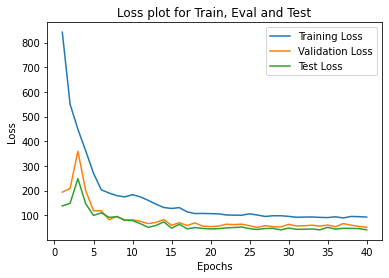

In [ ]:
chart_loss(40,train_vloss,eval_vloss, test_vloss)

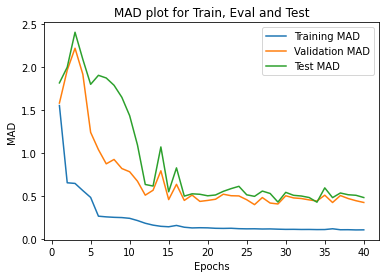

In [ ]:
chart_mad(40,train_MAD,eval_MAD, test_MAD)

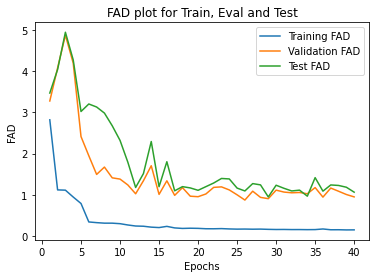

In [ ]:
chart_fad(40,train_FAD,eval_FAD, test_FAD)

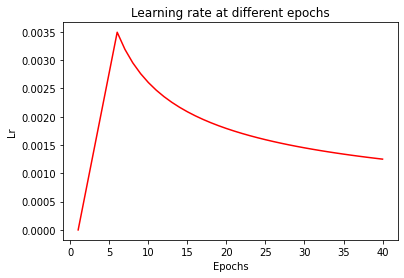

In [ ]:
chart_lr(40,lr)

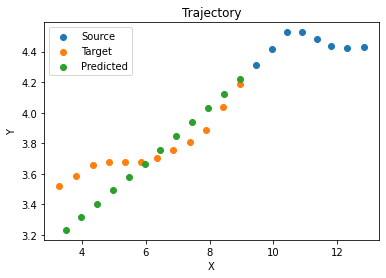

In [ ]:
chart_trajectory(test_dataset,10,pr_final)

# Ablation Studies

## Report  (***4 POINTS***)

Here you can report comments and results for the experiments up to this point.

Perform experiments that improves the performances or that gives meaningfull insights.

I.e. what happens if we change model hyperparamenters? What if we change learning rate?

Please explain extensively the results and organize them clearly with tables, plots...

----

We decided to let varies the Learning rates, the probability of the dropout and the number of epochs.


### 1) Change the Learning rate

From the learning rate formula, it can be said that there is a direct relationship between the value of F and that of LR: the higher F is the higher lr is, and the reverse is also true. So we proposed some different F values: 0.01, 10, 100, 1000. In the result section, we compare the values of the metrics obtained in the test part.

#### Case 1: F=0.01

In [ ]:
# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 3
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 3

emb_size = 512
ff_size = 1024
heads = 8
layers = 6
dropout = 0.1

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

# Argument for the optimizer 
factor = 0.01
warmup = 5

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [ ]:
train_vloss=[]
eval_vloss=[]
test_vloss=[]

train_MAD=[]
eval_MAD=[]
test_MAD=[]

train_FAD=[]
eval_FAD=[]
test_FAD=[]

lr=[]

# compute execution time of the cell
start_time = time.time()

# Argument for the training 
epoch = 0
max_epoch = 40          # Total number of epoch
ckp_save_step = 20      # Frequency for saving the model
log_step = 5           # Frequency for printing the loss


print("Start Training...\n")


for epoch in range(max_epoch):
    lr.append(optim._rate)
    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    
    for id_b, batch in enumerate(tr_dl):

        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        pred_speed = train_step(model, batch, mean, std, device)
        gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

        # We compute the two losses, averaging on the batch
        loss1 = F.pairwise_distance(pred_speed[:, :, :2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
        loss2 = torch.abs(pred_speed[:, :, 2]).mean()
        loss = loss1 + loss2

        # We accumulate and visualize the loss at the end of the epoch. 
        # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
        train_loss += loss.item() * batch['trg'].shape[0]

        loss.backward()
        optim.step()

        if input_type == 'speed':
            # If input type is speed, to compute MAD and FAD metrics we need to compute back positions from predicted speeds.
            # This is done easily adding cumulative (and denormalized) speeds to the last observed position. If last position in the input is (x_7, y_7) then:
            # (x_8, y_8)    =   (x_7, y_7) + (u_7, v_7)
            # (x_9, y_9)    =   (x_8, y_8) + (u_8, v_8)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8)
            # (x_10, y_10)  =   (x_9, y_9) + (u_9, v_9)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8) + (u_9, v_9)
            # We have always the last observed position (x_7, y_7) and we add progressively the "cumulated" speeds
            preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)

        elif input_type == 'position':
            # If input type is position, we simply append the output
            preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        

    # After concatenation we compute MAD and FAD metrics
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

    # we save the values in the lists
    train_vloss.append(train_loss/len(tr_dl))
    train_MAD.append(mad)
    train_FAD.append(fad)


    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))



    ###### VALIDATION ######
    # Here is all the same exept for eval_step and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []

        for id_b, batch in enumerate(val_dl):
            
            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            val_loss += loss.item() * batch['trg'].shape[0]

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            
        # After concatenation we compute MAD and FAD metrics
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

        # we save the values in the lists
        eval_vloss.append(val_loss/len(tr_dl))
        eval_MAD.append(mad)
        eval_FAD.append(fad)
  

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))



    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        gt = []
        pr = []
        
        for id_b, batch in enumerate(test_dl):

            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            test_loss += loss.item() * batch['trg'].shape[0]


            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])


        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)

        # we save the values in the lists
        test_vloss.append(test_loss/len(tr_dl))
        test_MAD.append(mad)
        test_FAD.append(fad)



        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        torch.save(model.state_dict(), f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')



# print execution time
print("Total time: %s seconds" % (time.time() - start_time))

# store the values
fad_001= test_FAD
mad_001= test_MAD
loss_001= test_vloss



lr_001= lr

Start Training...

---> Epoch 005/040 <---  LR: 0.00003
Total Train Loss: 428.0158 - MAD:  0.3642 - FAD:  0.5216
Total Eval  Loss: 418.7783 - MAD:  0.8207 - FAD:  1.4989
Total Test  Loss: 447.8816 - MAD:  1.0795 - FAD:  1.6612 

---> Epoch 010/040 <---  LR: 0.00003
Total Train Loss: 267.2611 - MAD:  0.2724 - FAD:  0.3425
Total Eval  Loss: 368.0210 - MAD:  0.8118 - FAD:  1.3889
Total Test  Loss: 467.8969 - MAD:  1.4863 - FAD:  2.2618 

---> Epoch 015/040 <---  LR: 0.00002
Total Train Loss: 226.8379 - MAD:  0.2526 - FAD:  0.3076
Total Eval  Loss: 370.9765 - MAD:  0.8679 - FAD:  1.5073
Total Test  Loss: 492.7916 - MAD:  1.5584 - FAD:  2.3971 

---> Epoch 020/040 <---  LR: 0.00002
Total Train Loss: 207.0309 - MAD:  0.2427 - FAD:  0.2892
Total Eval  Loss: 330.0815 - MAD:  0.7806 - FAD:  1.2865
Total Test  Loss: 478.9449 - MAD:  1.5987 - FAD:  2.4553 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.00002
Total Train Loss: 194.0051 - MAD:  0.2356 - FAD:  0.2768
Total Eval  Loss: 376.4

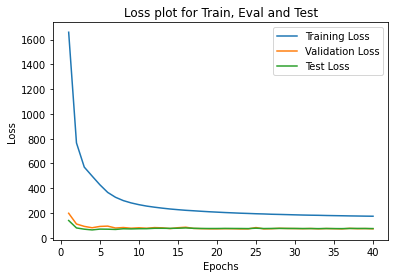

In [ ]:
chart_loss(40,train_vloss,eval_vloss, test_vloss)

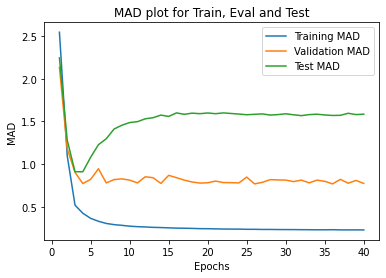

In [ ]:
chart_mad(40,train_MAD,eval_MAD, test_MAD)

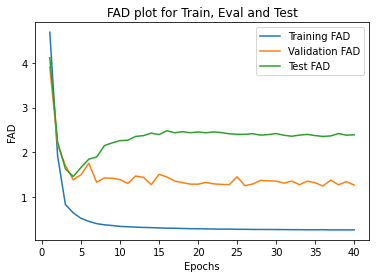

In [ ]:
chart_fad(40,train_FAD,eval_FAD, test_FAD)

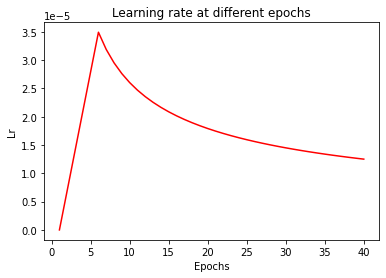

In [ ]:
chart_lr(40,lr)

#### Case 2: F=10

In [ ]:
# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 3
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 3

emb_size = 512
ff_size = 1024
heads = 8
layers = 6
dropout = 0.1

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

# Argument for the optimizer 
factor = 10
warmup = 5

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [ ]:
train_vloss=[]
eval_vloss=[]
test_vloss=[]

train_MAD=[]
eval_MAD=[]
test_MAD=[]

train_FAD=[]
eval_FAD=[]
test_FAD=[]

lr=[]

# compute execution time of the cell
start_time = time.time()

# Argument for the training 
epoch = 0
max_epoch = 40          # Total number of epoch
ckp_save_step = 20      # Frequency for saving the model
log_step = 5           # Frequency for printing the loss


print("Start Training...\n")


for epoch in range(max_epoch):
    lr.append(optim._rate)
    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    
    for id_b, batch in enumerate(tr_dl):

        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        pred_speed = train_step(model, batch, mean, std, device)
        gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

        # We compute the two losses, averaging on the batch
        loss1 = F.pairwise_distance(pred_speed[:, :, :2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
        loss2 = torch.abs(pred_speed[:, :, 2]).mean()
        loss = loss1 + loss2

        # We accumulate and visualize the loss at the end of the epoch. 
        # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
        train_loss += loss.item() * batch['trg'].shape[0]

        loss.backward()
        optim.step()

        if input_type == 'speed':
            # If input type is speed, to compute MAD and FAD metrics we need to compute back positions from predicted speeds.
            # This is done easily adding cumulative (and denormalized) speeds to the last observed position. If last position in the input is (x_7, y_7) then:
            # (x_8, y_8)    =   (x_7, y_7) + (u_7, v_7)
            # (x_9, y_9)    =   (x_8, y_8) + (u_8, v_8)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8)
            # (x_10, y_10)  =   (x_9, y_9) + (u_9, v_9)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8) + (u_9, v_9)
            # We have always the last observed position (x_7, y_7) and we add progressively the "cumulated" speeds
            preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)

        elif input_type == 'position':
            # If input type is position, we simply append the output
            preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        

    # After concatenation we compute MAD and FAD metrics
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

    # we save the values in the lists
    train_vloss.append(train_loss/len(tr_dl))
    train_MAD.append(mad)
    train_FAD.append(fad)


    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))



    ###### VALIDATION ######
    # Here is all the same exept for eval_step and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []

        for id_b, batch in enumerate(val_dl):
            
            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            val_loss += loss.item() * batch['trg'].shape[0]

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            
        # After concatenation we compute MAD and FAD metrics
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

        # we save the values in the lists
        eval_vloss.append(val_loss/len(tr_dl))
        eval_MAD.append(mad)
        eval_FAD.append(fad)
  

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))



    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        gt = []
        pr = []
        
        for id_b, batch in enumerate(test_dl):

            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            test_loss += loss.item() * batch['trg'].shape[0]


            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])


        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)

        # we save the values in the lists
        test_vloss.append(test_loss/len(tr_dl))
        test_MAD.append(mad)
        test_FAD.append(fad)



        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        torch.save(model.state_dict(), f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')



# print execution time
print("Total time: %s seconds" % (time.time() - start_time))

# store
fad_10= test_FAD
mad_10= test_MAD
loss_10= test_vloss
lr_10= lr

Start Training...

---> Epoch 005/040 <---  LR: 0.02795
Total Train Loss: 303.7936 - MAD:  0.3848 - FAD:  0.5828
Total Eval  Loss: 540.2187 - MAD:  1.2419 - FAD:  2.5111
Total Test  Loss: 698.6605 - MAD:  2.1702 - FAD:  3.8030 

---> Epoch 010/040 <---  LR: 0.02604
Total Train Loss: 163.2825 - MAD:  0.2834 - FAD:  0.3851
Total Eval  Loss: 613.6484 - MAD:  1.3407 - FAD:  2.6578
Total Test  Loss: 720.8311 - MAD:  2.0744 - FAD:  3.6633 

---> Epoch 015/040 <---  LR: 0.02088
Total Train Loss: 148.0048 - MAD:  0.2359 - FAD:  0.3396
Total Eval  Loss: 621.8736 - MAD:  1.3486 - FAD:  2.8465
Total Test  Loss: 657.8185 - MAD:  1.5860 - FAD:  3.1223 

---> Epoch 020/040 <---  LR: 0.01792
Total Train Loss: 113.2469 - MAD:  0.1550 - FAD:  0.2221
Total Eval  Loss: 342.1554 - MAD:  0.6989 - FAD:  1.5149
Total Test  Loss: 432.9792 - MAD:  0.8853 - FAD:  2.0279 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.01595
Total Train Loss: 105.9858 - MAD:  0.1381 - FAD:  0.1868
Total Eval  Loss: 331.9

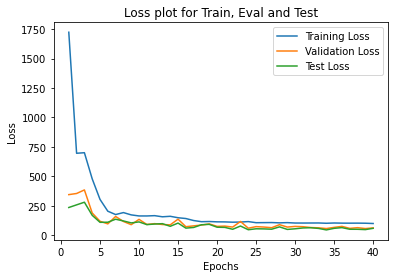

In [ ]:
chart_loss(40,train_vloss,eval_vloss, test_vloss)

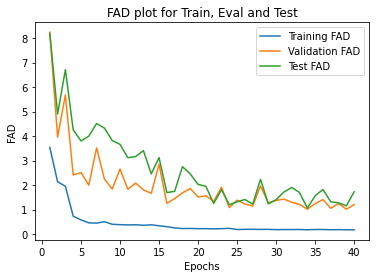

In [ ]:
chart_fad(40,train_FAD,eval_FAD, test_FAD)

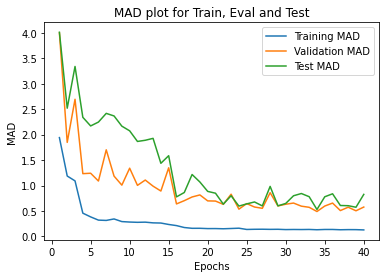

In [ ]:
chart_mad(40,train_MAD,eval_MAD, test_MAD)

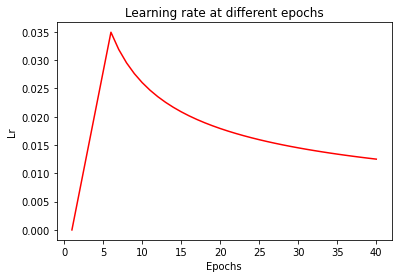

In [ ]:
chart_lr(40,lr)

#### Case 3: F=100

In [ ]:
# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 3
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 3

emb_size = 512
ff_size = 1024
heads = 8
layers = 6
dropout = 0.1

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

# Argument for the optimizer 
factor = 100.
warmup = 5

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [ ]:
train_vloss=[]
eval_vloss=[]
test_vloss=[]

train_MAD=[]
eval_MAD=[]
test_MAD=[]

train_FAD=[]
eval_FAD=[]
test_FAD=[]

lr=[]

# compute execution time of the cell
start_time = time.time()

# Argument for the training 
epoch = 0
max_epoch = 40          # Total number of epoch
ckp_save_step = 20      # Frequency for saving the model
log_step = 5           # Frequency for printing the loss


print("Start Training...\n")


for epoch in range(max_epoch):
    lr.append(optim._rate)
    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    
    for id_b, batch in enumerate(tr_dl):

        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        pred_speed = train_step(model, batch, mean, std, device)
        gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

        # We compute the two losses, averaging on the batch
        loss1 = F.pairwise_distance(pred_speed[:, :, :2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
        loss2 = torch.abs(pred_speed[:, :, 2]).mean()
        loss = loss1 + loss2

        # We accumulate and visualize the loss at the end of the epoch. 
        # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
        train_loss += loss.item() * batch['trg'].shape[0]

        loss.backward()
        optim.step()

        if input_type == 'speed':
            # If input type is speed, to compute MAD and FAD metrics we need to compute back positions from predicted speeds.
            # This is done easily adding cumulative (and denormalized) speeds to the last observed position. If last position in the input is (x_7, y_7) then:
            # (x_8, y_8)    =   (x_7, y_7) + (u_7, v_7)
            # (x_9, y_9)    =   (x_8, y_8) + (u_8, v_8)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8)
            # (x_10, y_10)  =   (x_9, y_9) + (u_9, v_9)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8) + (u_9, v_9)
            # We have always the last observed position (x_7, y_7) and we add progressively the "cumulated" speeds
            preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)

        elif input_type == 'position':
            # If input type is position, we simply append the output
            preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        

    # After concatenation we compute MAD and FAD metrics
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

    # we save the values in the lists
    train_vloss.append(train_loss/len(tr_dl))
    train_MAD.append(mad)
    train_FAD.append(fad)


    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))



    ###### VALIDATION ######
    # Here is all the same exept for eval_step and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []

        for id_b, batch in enumerate(val_dl):
            
            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            val_loss += loss.item() * batch['trg'].shape[0]

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            
        # After concatenation we compute MAD and FAD metrics
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

        # we save the values in the lists
        eval_vloss.append(val_loss/len(tr_dl))
        eval_MAD.append(mad)
        eval_FAD.append(fad)
  

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))



    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        gt = []
        pr = []
        
        for id_b, batch in enumerate(test_dl):

            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            test_loss += loss.item() * batch['trg'].shape[0]


            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])


        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)

        # we save the values in the lists
        test_vloss.append(test_loss/len(tr_dl))
        test_MAD.append(mad)
        test_FAD.append(fad)



        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        torch.save(model.state_dict(), f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')



# print execution time
print("Total time: %s seconds" % (time.time() - start_time))

# store
fad_100= test_FAD
mad_100= test_MAD
loss_100= test_vloss
lr_100= lr

Start Training...

---> Epoch 005/040 <---  LR: 0.27951
Total Train Loss: 585.1876 - MAD:  0.9462 - FAD:  1.6510
Total Eval  Loss: 3099.3124 - MAD:  3.7704 - FAD:  7.0191
Total Test  Loss: 3038.5206 - MAD:  4.2096 - FAD:  7.8316 

---> Epoch 010/040 <---  LR: 0.26042
Total Train Loss: 388.6013 - MAD:  0.6241 - FAD:  1.0394
Total Eval  Loss: 448.1667 - MAD:  1.1271 - FAD:  2.0684
Total Test  Loss: 791.4099 - MAD:  2.5025 - FAD:  4.6065 

---> Epoch 015/040 <---  LR: 0.20880
Total Train Loss: 1178.9828 - MAD:  2.3172 - FAD:  4.2311
Total Eval  Loss: 1125.8270 - MAD:  2.7451 - FAD:  5.2511
Total Test  Loss: 1148.8361 - MAD:  2.9981 - FAD:  5.6567 

---> Epoch 020/040 <---  LR: 0.17923
Total Train Loss: 385.6607 - MAD:  0.5920 - FAD:  0.9929
Total Eval  Loss: 1032.1301 - MAD:  2.7668 - FAD:  5.5974
Total Test  Loss: 1029.4201 - MAD:  2.9004 - FAD:  5.6487 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.15947
Total Train Loss: 559.8986 - MAD:  0.9445 - FAD:  1.6739
Total Eval  Loss

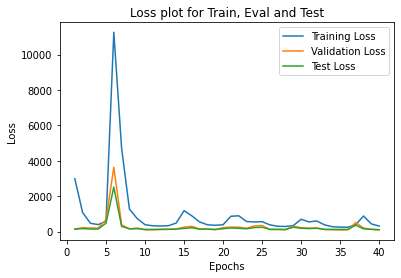

In [ ]:
chart_loss(40,train_vloss,eval_vloss, test_vloss)

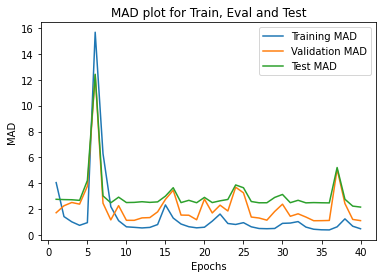

In [ ]:
chart_mad(40,train_MAD,eval_MAD, test_MAD)

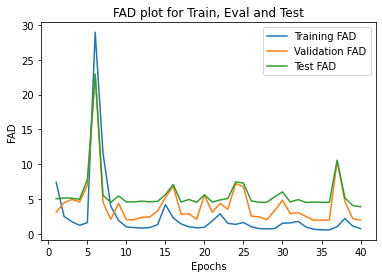

In [ ]:
chart_fad(40,train_FAD,eval_FAD, test_FAD)

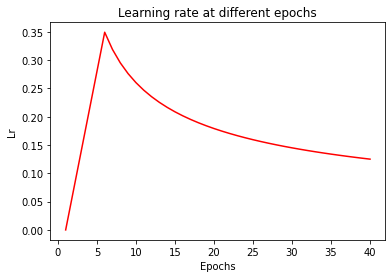

In [ ]:
chart_lr(40,lr)

#### Case 4: F=1000

In [ ]:
# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 3
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 3

emb_size = 512
ff_size = 1024
heads = 8
layers = 6
dropout = 0.1

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

# Argument for the optimizer 
factor = 1000
warmup = 5

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [ ]:
train_vloss=[]
eval_vloss=[]
test_vloss=[]

train_MAD=[]
eval_MAD=[]
test_MAD=[]

train_FAD=[]
eval_FAD=[]
test_FAD=[]

lr=[]

# compute execution time of the cell
start_time = time.time()

# Argument for the training 
epoch = 0
max_epoch = 40          # Total number of epoch
ckp_save_step = 20      # Frequency for saving the model
log_step = 5           # Frequency for printing the loss


print("Start Training...\n")


for epoch in range(max_epoch):
    lr.append(optim._rate)
    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    
    for id_b, batch in enumerate(tr_dl):

        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        pred_speed = train_step(model, batch, mean, std, device)
        gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

        # We compute the two losses, averaging on the batch
        loss1 = F.pairwise_distance(pred_speed[:, :, :2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
        loss2 = torch.abs(pred_speed[:, :, 2]).mean()
        loss = loss1 + loss2

        # We accumulate and visualize the loss at the end of the epoch. 
        # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
        train_loss += loss.item() * batch['trg'].shape[0]

        loss.backward()
        optim.step()

        if input_type == 'speed':
            # If input type is speed, to compute MAD and FAD metrics we need to compute back positions from predicted speeds.
            # This is done easily adding cumulative (and denormalized) speeds to the last observed position. If last position in the input is (x_7, y_7) then:
            # (x_8, y_8)    =   (x_7, y_7) + (u_7, v_7)
            # (x_9, y_9)    =   (x_8, y_8) + (u_8, v_8)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8)
            # (x_10, y_10)  =   (x_9, y_9) + (u_9, v_9)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8) + (u_9, v_9)
            # We have always the last observed position (x_7, y_7) and we add progressively the "cumulated" speeds
            preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)

        elif input_type == 'position':
            # If input type is position, we simply append the output
            preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        

    # After concatenation we compute MAD and FAD metrics
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

    # we save the values in the lists
    train_vloss.append(train_loss/len(tr_dl))
    train_MAD.append(mad)
    train_FAD.append(fad)


    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))



    ###### VALIDATION ######
    # Here is all the same exept for eval_step and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []

        for id_b, batch in enumerate(val_dl):
            
            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            val_loss += loss.item() * batch['trg'].shape[0]

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            
        # After concatenation we compute MAD and FAD metrics
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

        # we save the values in the lists
        eval_vloss.append(val_loss/len(tr_dl))
        eval_MAD.append(mad)
        eval_FAD.append(fad)
  

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))



    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        gt = []
        pr = []
        
        for id_b, batch in enumerate(test_dl):

            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            test_loss += loss.item() * batch['trg'].shape[0]


            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])


        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)

        # we save the values in the lists
        test_vloss.append(test_loss/len(tr_dl))
        test_MAD.append(mad)
        test_FAD.append(fad)



        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        torch.save(model.state_dict(), f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')



# print execution time
print("Total time: %s seconds" % (time.time() - start_time))

# store
fad_1000= test_FAD
mad_1000= test_MAD
loss_1000= test_vloss
lr_1000= lr

Start Training...

---> Epoch 005/040 <---  LR: 2.79508
Total Train Loss: 222498.2153 - MAD: 355.9025 - FAD: 657.0534
Total Eval  Loss: 285756.3701 - MAD: 441.2326 - FAD: 814.6007
Total Test  Loss: 277094.7001 - MAD: 441.4172 - FAD: 814.8931 

---> Epoch 010/040 <---  LR: 2.60417
Total Train Loss: 82918.0455 - MAD: 119.2890 - FAD: 220.2031
Total Eval  Loss: 42629.8118 - MAD: 27.4871 - FAD: 50.7267
Total Test  Loss: 41254.0485 - MAD: 27.3421 - FAD: 50.5148 

---> Epoch 015/040 <---  LR: 2.08798
Total Train Loss: 35661.4199 - MAD: 63.3083 - FAD: 116.8687
Total Eval  Loss: 18292.8718 - MAD: 33.6907 - FAD: 62.2061
Total Test  Loss: 17748.7264 - MAD: 33.7748 - FAD: 62.3111 

---> Epoch 020/040 <---  LR: 1.79231
Total Train Loss: 148484.6953 - MAD: 196.7524 - FAD: 363.2263
Total Eval  Loss: 145930.2512 - MAD: 236.6356 - FAD: 436.8693
Total Test  Loss: 141500.8469 - MAD: 236.7237 - FAD: 436.9819 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 1.59472
Total Train Loss: 112972.7644 - MAD

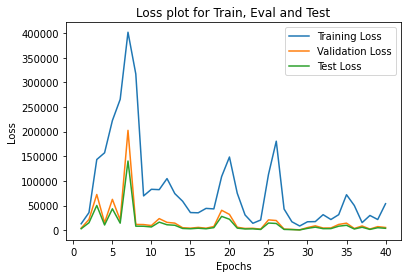

In [ ]:
chart_loss(40,train_vloss,eval_vloss, test_vloss)

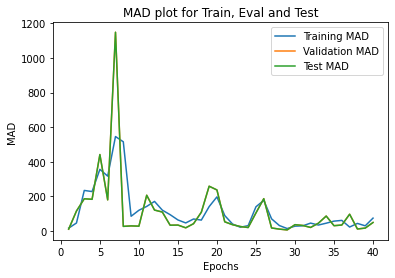

In [ ]:
chart_mad(40,train_MAD,eval_MAD, test_MAD)

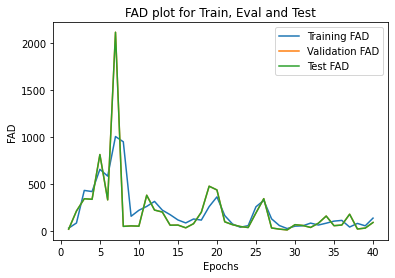

In [ ]:
chart_fad(40,train_FAD,eval_FAD, test_FAD)

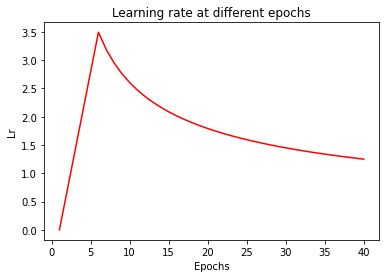

In [ ]:
chart_lr(40,lr_1000)

#### Results

We compare the graphs of the various metrics obtained regarding the testing part.
we can obviously see, how when F equals 1000, the values of the metrics are incredebly high.

In [ ]:
epochs=[]
for i in range(1,41):
  epochs.append(i)

In [ ]:
# We made a typo, but due to the limitations of google colab on the GPU currently we cannot run the necessary models and thus adjust the plot lables:
# In all the graphs in this section we wrote 0.001 instead of 0.01
# For the mad plot we got the names wrong in the legend, which should be the same as the legend in the fad chart

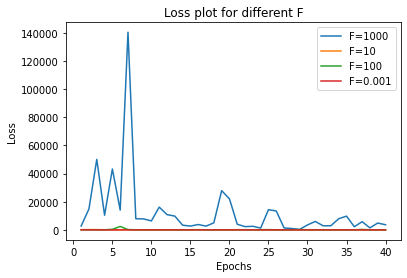

In [ ]:
plt.plot(epochs, loss_1000, label='F=1000')
plt.plot(epochs, loss_10, label='F=10')
plt.plot(epochs, loss_100, label='F=100')
plt.plot(epochs, loss_001, label='F=0.01')# *
plt.title('Loss plot for different F')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

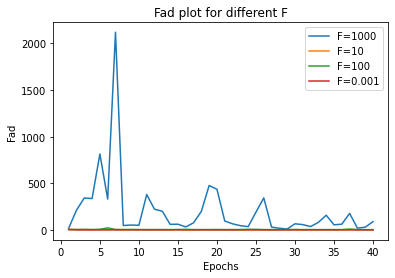

In [ ]:
plt.plot(epochs, fad_1000, label='F=1000')
plt.plot(epochs, fad_10, label='F=10')
plt.plot(epochs, fad_100, label='F=100')
plt.plot(epochs, fad_001, label='F=0.01')# *
plt.title('Fad plot for different F')
plt.xlabel('Epochs')
plt.ylabel('Fad')
plt.legend(loc='best')
plt.show()

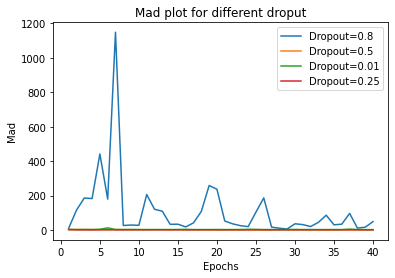

In [ ]:
plt.plot(epochs, mad_1000, label='F=1000')# *
plt.plot(epochs, mad_10, label='F=10')# *
plt.plot(epochs, mad_100, label='F=100')# *
plt.plot(epochs, mad_001, label='F=0.01')# *
plt.title('Mad plot for different F')# *
plt.xlabel('Epochs')
plt.ylabel('Mad')
plt.legend(loc='best')
plt.show()

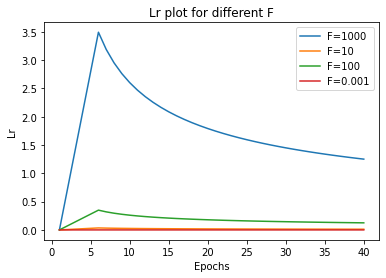

In [ ]:
plt.plot(epochs, lr_1000, label='F=1000')
plt.plot(epochs, lr_10, label='F=10')
plt.plot(epochs, lr_100, label='F=100')
plt.plot(epochs, lr_001, label='F=0.01')#*
plt.title('Lr plot for different F')
plt.xlabel('Epochs')
plt.ylabel('Lr')
plt.legend(loc='best')
plt.show()

We decided to report for each different F, the value of Loss, Fad and Mad metrics at the last epochs for the Test part

|    F   |    Loss   |   Fad  |Mad|Lr|
|------------|-----------|---------|-----|-----|
|1000|23749|90|49|1.25|
|100 |696|4|2.15|0.125|
|10| 372.6 |1.73|0.82|0.0125|
|1|265|1.03|0.45|0.00125|
|0.001|475.4|2.4|1.6|0.00001|

From the table, we can state that the model with the best Loss, Mean Average Displacement and Final Average Displacement is when F=1.
we can also state that the worst model is when the learning rate is very high (F=1000), in fact it has very high values for the metrics shown in the table.

###2) Change Dropout value

In this section we want to try to change the probability p of node dropout. We tried 4 experiments with the following dropout values: 0.01, 0.25, 0.5 and 0.8.

In the result section, we compare the values of the metrics obtained in the test part.

#### Case 1: drop_out=0.01

In [ ]:
# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 3
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 3

emb_size = 512
ff_size = 1024
heads = 8
layers = 6
dropout = 0.01

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

# Argument for the optimizer 
factor = 1.
warmup = 5

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [ ]:
train_vloss=[]
eval_vloss=[]
test_vloss=[]

train_MAD=[]
eval_MAD=[]
test_MAD=[]

train_FAD=[]
eval_FAD=[]
test_FAD=[]

lr=[]

# compute execution time of the cell
start_time = time.time()

# Argument for the training 
epoch = 0
max_epoch = 40          # Total number of epoch
ckp_save_step = 20      # Frequency for saving the model
log_step = 5           # Frequency for printing the loss


print("Start Training...\n")


for epoch in range(max_epoch):
    lr.append(optim._rate)
    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    
    for id_b, batch in enumerate(tr_dl):

        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        pred_speed = train_step(model, batch, mean, std, device)
        gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

        # We compute the two losses, averaging on the batch
        loss1 = F.pairwise_distance(pred_speed[:, :, :2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
        loss2 = torch.abs(pred_speed[:, :, 2]).mean()
        loss = loss1 + loss2

        # We accumulate and visualize the loss at the end of the epoch. 
        # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
        train_loss += loss.item() * batch['trg'].shape[0]

        loss.backward()
        optim.step()

        if input_type == 'speed':
            # If input type is speed, to compute MAD and FAD metrics we need to compute back positions from predicted speeds.
            # This is done easily adding cumulative (and denormalized) speeds to the last observed position. If last position in the input is (x_7, y_7) then:
            # (x_8, y_8)    =   (x_7, y_7) + (u_7, v_7)
            # (x_9, y_9)    =   (x_8, y_8) + (u_8, v_8)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8)
            # (x_10, y_10)  =   (x_9, y_9) + (u_9, v_9)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8) + (u_9, v_9)
            # We have always the last observed position (x_7, y_7) and we add progressively the "cumulated" speeds
            preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)

        elif input_type == 'position':
            # If input type is position, we simply append the output
            preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        

    # After concatenation we compute MAD and FAD metrics
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

    # we save the values in the lists
    train_vloss.append(train_loss/len(tr_dl))
    train_MAD.append(mad)
    train_FAD.append(fad)


    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))



    ###### VALIDATION ######
    # Here is all the same exept for eval_step and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []

        for id_b, batch in enumerate(val_dl):
            
            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            val_loss += loss.item() * batch['trg'].shape[0]

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            
        # After concatenation we compute MAD and FAD metrics
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

        # we save the values in the lists
        eval_vloss.append(val_loss/len(tr_dl))
        eval_MAD.append(mad)
        eval_FAD.append(fad)
  

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))



    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        gt = []
        pr = []
        
        for id_b, batch in enumerate(test_dl):

            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            test_loss += loss.item() * batch['trg'].shape[0]


            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])


        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)

        # we save the values in the lists
        test_vloss.append(test_loss/len(tr_dl))
        test_MAD.append(mad)
        test_FAD.append(fad)



        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        torch.save(model.state_dict(), f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')



# print execution time
print("Total time: %s seconds" % (time.time() - start_time))

# store
fad_d001= test_FAD
mad_d001= test_MAD
loss_d001= test_vloss
lr_d001= lr

Start Training...

---> Epoch 005/040 <---  LR: 0.00280
Total Train Loss: 414.8523 - MAD:  0.4220 - FAD:  0.6688
Total Eval  Loss: 684.6010 - MAD:  1.2030 - FAD:  2.3138
Total Test  Loss: 761.5895 - MAD:  1.8277 - FAD:  3.1129 

---> Epoch 010/040 <---  LR: 0.00260
Total Train Loss: 247.1841 - MAD:  0.2575 - FAD:  0.3267
Total Eval  Loss: 659.7869 - MAD:  1.2695 - FAD:  2.5854
Total Test  Loss: 751.7014 - MAD:  1.8826 - FAD:  3.2148 

---> Epoch 015/040 <---  LR: 0.00209
Total Train Loss: 177.7854 - MAD:  0.2532 - FAD:  0.3325
Total Eval  Loss: 483.7739 - MAD:  0.8916 - FAD:  1.6421
Total Test  Loss: 606.1062 - MAD:  1.6705 - FAD:  2.6885 

---> Epoch 020/040 <---  LR: 0.00179
Total Train Loss: 103.1470 - MAD:  0.1216 - FAD:  0.1769
Total Eval  Loss: 244.9028 - MAD:  0.4423 - FAD:  0.9156
Total Test  Loss: 270.3292 - MAD:  0.4969 - FAD:  1.0324 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.00159
Total Train Loss: 100.6427 - MAD:  0.1270 - FAD:  0.1897
Total Eval  Loss: 241.0

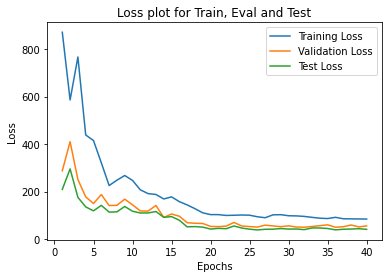

In [ ]:
chart_loss(40,train_vloss,eval_vloss, test_vloss)

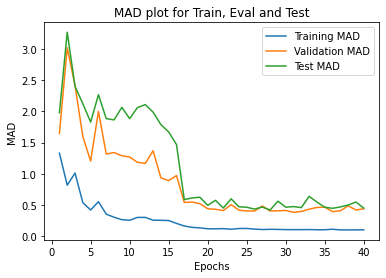

In [ ]:
chart_mad(40,train_MAD,eval_MAD, test_MAD)

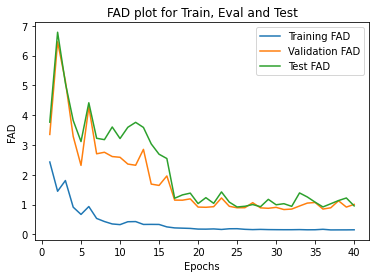

In [ ]:
chart_fad(40,train_FAD,eval_FAD, test_FAD)

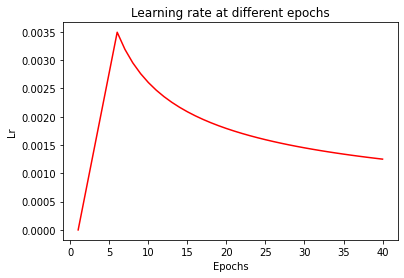

In [ ]:
chart_lr(40,lr)

#### Case 2: drop_out=0.25

In [ ]:
# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 3
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 3

emb_size = 512
ff_size = 1024
heads = 8
layers = 6
dropout = 0.25

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

# Argument for the optimizer 
factor = 1.
warmup = 5

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [ ]:
train_vloss=[]
eval_vloss=[]
test_vloss=[]

train_MAD=[]
eval_MAD=[]
test_MAD=[]

train_FAD=[]
eval_FAD=[]
test_FAD=[]

lr=[]

# compute execution time of the cell
start_time = time.time()

# Argument for the training 
epoch = 0
max_epoch = 40          # Total number of epoch
ckp_save_step = 20      # Frequency for saving the model
log_step = 5           # Frequency for printing the loss


print("Start Training...\n")


for epoch in range(max_epoch):
    lr.append(optim._rate)
    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    
    for id_b, batch in enumerate(tr_dl):

        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        pred_speed = train_step(model, batch, mean, std, device)
        gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

        # We compute the two losses, averaging on the batch
        loss1 = F.pairwise_distance(pred_speed[:, :, :2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
        loss2 = torch.abs(pred_speed[:, :, 2]).mean()
        loss = loss1 + loss2

        # We accumulate and visualize the loss at the end of the epoch. 
        # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
        train_loss += loss.item() * batch['trg'].shape[0]

        loss.backward()
        optim.step()

        if input_type == 'speed':
            # If input type is speed, to compute MAD and FAD metrics we need to compute back positions from predicted speeds.
            # This is done easily adding cumulative (and denormalized) speeds to the last observed position. If last position in the input is (x_7, y_7) then:
            # (x_8, y_8)    =   (x_7, y_7) + (u_7, v_7)
            # (x_9, y_9)    =   (x_8, y_8) + (u_8, v_8)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8)
            # (x_10, y_10)  =   (x_9, y_9) + (u_9, v_9)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8) + (u_9, v_9)
            # We have always the last observed position (x_7, y_7) and we add progressively the "cumulated" speeds
            preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)

        elif input_type == 'position':
            # If input type is position, we simply append the output
            preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        

    # After concatenation we compute MAD and FAD metrics
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

    # we save the values in the lists
    train_vloss.append(train_loss/len(tr_dl))
    train_MAD.append(mad)
    train_FAD.append(fad)


    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))



    ###### VALIDATION ######
    # Here is all the same exept for eval_step and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []

        for id_b, batch in enumerate(val_dl):
            
            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            val_loss += loss.item() * batch['trg'].shape[0]

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            
        # After concatenation we compute MAD and FAD metrics
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

        # we save the values in the lists
        eval_vloss.append(val_loss/len(tr_dl))
        eval_MAD.append(mad)
        eval_FAD.append(fad)
  

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))



    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        gt = []
        pr = []
        
        for id_b, batch in enumerate(test_dl):

            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            test_loss += loss.item() * batch['trg'].shape[0]


            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])


        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)

        # we save the values in the lists
        test_vloss.append(test_loss/len(tr_dl))
        test_MAD.append(mad)
        test_FAD.append(fad)



        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        torch.save(model.state_dict(), f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')



# print execution time
print("Total time: %s seconds" % (time.time() - start_time))

# store
fad_d25= test_FAD
mad_d25= test_MAD
loss_d25= test_vloss
lr_d25= lr

Start Training...

---> Epoch 005/040 <---  LR: 0.00280
Total Train Loss: 274.6149 - MAD:  0.3842 - FAD:  0.5890
Total Eval  Loss: 1640.3888 - MAD:  3.1053 - FAD:  6.9534
Total Test  Loss: 1625.3545 - MAD:  3.2463 - FAD:  7.0072 

---> Epoch 010/040 <---  LR: 0.00260
Total Train Loss: 171.7260 - MAD:  0.2126 - FAD:  0.2714
Total Eval  Loss: 610.0659 - MAD:  0.9908 - FAD:  2.1428
Total Test  Loss: 627.5029 - MAD:  1.3253 - FAD:  2.6020 

---> Epoch 015/040 <---  LR: 0.00209
Total Train Loss: 124.0671 - MAD:  0.1414 - FAD:  0.2075
Total Eval  Loss: 340.9117 - MAD:  0.5934 - FAD:  1.4415
Total Test  Loss: 381.0261 - MAD:  0.6569 - FAD:  1.5870 

---> Epoch 020/040 <---  LR: 0.00179
Total Train Loss: 109.6398 - MAD:  0.1272 - FAD:  0.1854
Total Eval  Loss: 265.4300 - MAD:  0.4470 - FAD:  1.0137
Total Test  Loss: 301.6279 - MAD:  0.5088 - FAD:  1.1422 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.00159
Total Train Loss: 101.9572 - MAD:  0.1181 - FAD:  0.1709
Total Eval  Loss: 369

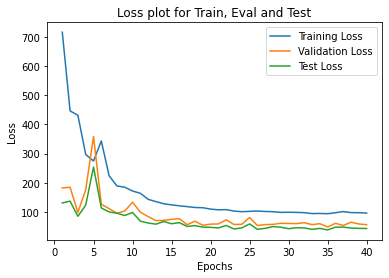

In [ ]:
chart_loss(40,train_vloss,eval_vloss, test_vloss)

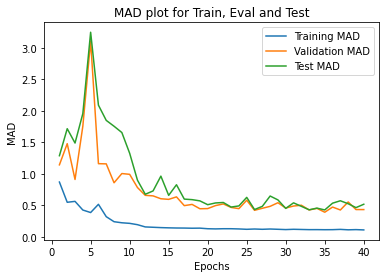

In [ ]:
chart_mad(40,train_MAD,eval_MAD, test_MAD)

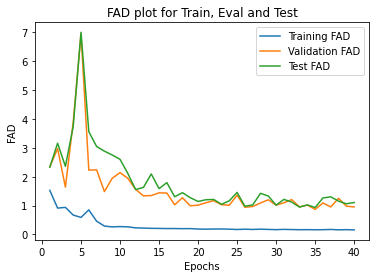

In [ ]:
chart_fad(40,train_FAD,eval_FAD, test_FAD)

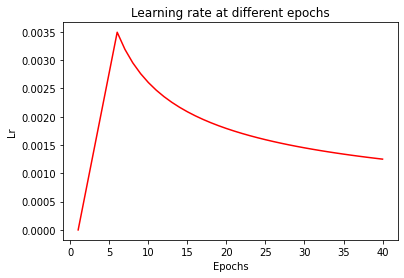

In [ ]:
chart_lr(40,lr)

#### Case 3: drop_out=0.5

In [ ]:
# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 3
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 3

emb_size = 512
ff_size = 1024
heads = 8
layers = 6
dropout = 0.5

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

# Argument for the optimizer 
factor = 1.
warmup = 5

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [ ]:
train_vloss=[]
eval_vloss=[]
test_vloss=[]

train_MAD=[]
eval_MAD=[]
test_MAD=[]

train_FAD=[]
eval_FAD=[]
test_FAD=[]

lr=[]

# compute execution time of the cell
start_time = time.time()

# Argument for the training 
epoch = 0
max_epoch = 40          # Total number of epoch
ckp_save_step = 20      # Frequency for saving the model
log_step = 5           # Frequency for printing the loss


print("Start Training...\n")


for epoch in range(max_epoch):
    lr.append(optim._rate)
    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    
    for id_b, batch in enumerate(tr_dl):

        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        pred_speed = train_step(model, batch, mean, std, device)
        gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

        # We compute the two losses, averaging on the batch
        loss1 = F.pairwise_distance(pred_speed[:, :, :2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
        loss2 = torch.abs(pred_speed[:, :, 2]).mean()
        loss = loss1 + loss2

        # We accumulate and visualize the loss at the end of the epoch. 
        # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
        train_loss += loss.item() * batch['trg'].shape[0]

        loss.backward()
        optim.step()

        if input_type == 'speed':
            # If input type is speed, to compute MAD and FAD metrics we need to compute back positions from predicted speeds.
            # This is done easily adding cumulative (and denormalized) speeds to the last observed position. If last position in the input is (x_7, y_7) then:
            # (x_8, y_8)    =   (x_7, y_7) + (u_7, v_7)
            # (x_9, y_9)    =   (x_8, y_8) + (u_8, v_8)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8)
            # (x_10, y_10)  =   (x_9, y_9) + (u_9, v_9)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8) + (u_9, v_9)
            # We have always the last observed position (x_7, y_7) and we add progressively the "cumulated" speeds
            preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)

        elif input_type == 'position':
            # If input type is position, we simply append the output
            preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        

    # After concatenation we compute MAD and FAD metrics
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

    # we save the values in the lists
    train_vloss.append(train_loss/len(tr_dl))
    train_MAD.append(mad)
    train_FAD.append(fad)


    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))



    ###### VALIDATION ######
    # Here is all the same exept for eval_step and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []

        for id_b, batch in enumerate(val_dl):
            
            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            val_loss += loss.item() * batch['trg'].shape[0]

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            
        # After concatenation we compute MAD and FAD metrics
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

        # we save the values in the lists
        eval_vloss.append(val_loss/len(tr_dl))
        eval_MAD.append(mad)
        eval_FAD.append(fad)
  

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))



    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        gt = []
        pr = []
        
        for id_b, batch in enumerate(test_dl):

            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            test_loss += loss.item() * batch['trg'].shape[0]


            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])


        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)

        # we save the values in the lists
        test_vloss.append(test_loss/len(tr_dl))
        test_MAD.append(mad)
        test_FAD.append(fad)



        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        torch.save(model.state_dict(), f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')



# print execution time
print("Total time: %s seconds" % (time.time() - start_time))

# store
fad_d5= test_FAD
mad_d5= test_MAD
loss_d5= test_vloss
lr_d5= lr

Start Training...

---> Epoch 005/040 <---  LR: 0.00280
Total Train Loss: 275.6082 - MAD:  0.3791 - FAD:  0.5792
Total Eval  Loss: 403.1416 - MAD:  0.7517 - FAD:  1.2548
Total Test  Loss: 483.9668 - MAD:  1.2747 - FAD:  1.7611 

---> Epoch 010/040 <---  LR: 0.00260
Total Train Loss: 189.3676 - MAD:  0.2564 - FAD:  0.3257
Total Eval  Loss: 398.1622 - MAD:  0.8233 - FAD:  1.5095
Total Test  Loss: 440.3143 - MAD:  1.1819 - FAD:  1.6059 

---> Epoch 015/040 <---  LR: 0.00209
Total Train Loss: 138.1737 - MAD:  0.1729 - FAD:  0.2528
Total Eval  Loss: 338.0426 - MAD:  0.6405 - FAD:  1.2823
Total Test  Loss: 398.3534 - MAD:  0.8812 - FAD:  1.6616 

---> Epoch 020/040 <---  LR: 0.00179
Total Train Loss: 123.7314 - MAD:  0.1498 - FAD:  0.2130
Total Eval  Loss: 328.4669 - MAD:  0.6902 - FAD:  1.3521
Total Test  Loss: 427.1151 - MAD:  1.0935 - FAD:  1.9880 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.00159
Total Train Loss: 109.5238 - MAD:  0.1348 - FAD:  0.1901
Total Eval  Loss: 255.4

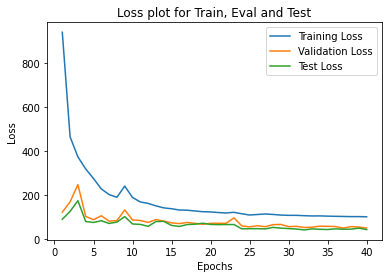

In [ ]:
chart_loss(40,train_vloss,eval_vloss, test_vloss)

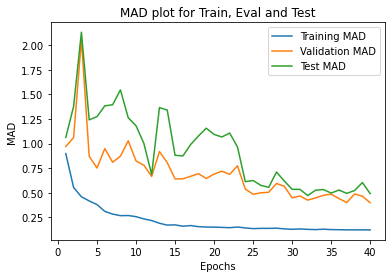

In [ ]:
chart_mad(40,train_MAD,eval_MAD, test_MAD)

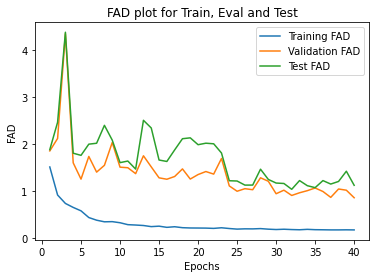

In [ ]:
chart_fad(40,train_FAD,eval_FAD, test_FAD)

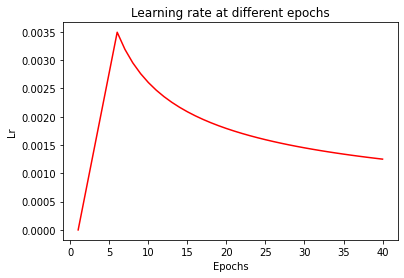

In [ ]:
chart_lr(40,lr)

#### Case 4: drop_out=0.8

In [ ]:
# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 3
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 3

emb_size = 512
ff_size = 1024
heads = 8
layers = 6
dropout = 0.8

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

# Argument for the optimizer 
factor = 1.
warmup = 5

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [ ]:
train_vloss=[]
eval_vloss=[]
test_vloss=[]

train_MAD=[]
eval_MAD=[]
test_MAD=[]

train_FAD=[]
eval_FAD=[]
test_FAD=[]

lr=[]

# compute execution time of the cell
start_time = time.time()

# Argument for the training 
epoch = 0
max_epoch = 40          # Total number of epoch
ckp_save_step = 20      # Frequency for saving the model
log_step = 5           # Frequency for printing the loss


print("Start Training...\n")


for epoch in range(max_epoch):
    lr.append(optim._rate)
    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    
    for id_b, batch in enumerate(tr_dl):

        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        pred_speed = train_step(model, batch, mean, std, device)
        gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

        # We compute the two losses, averaging on the batch
        loss1 = F.pairwise_distance(pred_speed[:, :, :2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
        loss2 = torch.abs(pred_speed[:, :, 2]).mean()
        loss = loss1 + loss2

        # We accumulate and visualize the loss at the end of the epoch. 
        # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
        train_loss += loss.item() * batch['trg'].shape[0]

        loss.backward()
        optim.step()

        if input_type == 'speed':
            # If input type is speed, to compute MAD and FAD metrics we need to compute back positions from predicted speeds.
            # This is done easily adding cumulative (and denormalized) speeds to the last observed position. If last position in the input is (x_7, y_7) then:
            # (x_8, y_8)    =   (x_7, y_7) + (u_7, v_7)
            # (x_9, y_9)    =   (x_8, y_8) + (u_8, v_8)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8)
            # (x_10, y_10)  =   (x_9, y_9) + (u_9, v_9)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8) + (u_9, v_9)
            # We have always the last observed position (x_7, y_7) and we add progressively the "cumulated" speeds
            preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)

        elif input_type == 'position':
            # If input type is position, we simply append the output
            preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        

    # After concatenation we compute MAD and FAD metrics
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

    # we save the values in the lists
    train_vloss.append(train_loss/len(tr_dl))
    train_MAD.append(mad)
    train_FAD.append(fad)


    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))



    ###### VALIDATION ######
    # Here is all the same exept for eval_step and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []

        for id_b, batch in enumerate(val_dl):
            
            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            val_loss += loss.item() * batch['trg'].shape[0]

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            
        # After concatenation we compute MAD and FAD metrics
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

        # we save the values in the lists
        eval_vloss.append(val_loss/len(tr_dl))
        eval_MAD.append(mad)
        eval_FAD.append(fad)
  

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))



    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        gt = []
        pr = []
        
        for id_b, batch in enumerate(test_dl):

            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            test_loss += loss.item() * batch['trg'].shape[0]


            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])


        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)

        # we save the values in the lists
        test_vloss.append(test_loss/len(tr_dl))
        test_MAD.append(mad)
        test_FAD.append(fad)



        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        torch.save(model.state_dict(), f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')



# print execution time
print("Total time: %s seconds" % (time.time() - start_time))

# store
fad_d8= test_FAD
mad_d8= test_MAD
loss_d8= test_vloss
lr_d8= lr

Start Training...

---> Epoch 005/040 <---  LR: 0.00280
Total Train Loss: 263.5545 - MAD:  0.3592 - FAD:  0.5401
Total Eval  Loss: 720.5521 - MAD:  1.0742 - FAD:  2.5267
Total Test  Loss: 857.3361 - MAD:  1.3851 - FAD:  3.3538 

---> Epoch 010/040 <---  LR: 0.00260
Total Train Loss: 187.5038 - MAD:  0.2810 - FAD:  0.3748
Total Eval  Loss: 360.4890 - MAD:  0.6500 - FAD:  1.3077
Total Test  Loss: 413.2698 - MAD:  0.7068 - FAD:  1.3237 

---> Epoch 015/040 <---  LR: 0.00209
Total Train Loss: 158.3093 - MAD:  0.2163 - FAD:  0.2989
Total Eval  Loss: 442.6887 - MAD:  1.1081 - FAD:  2.1484
Total Test  Loss: 817.0324 - MAD:  2.3899 - FAD:  4.6312 

---> Epoch 020/040 <---  LR: 0.00179
Total Train Loss: 137.7980 - MAD:  0.1864 - FAD:  0.2686
Total Eval  Loss: 368.5971 - MAD:  0.8622 - FAD:  1.7081
Total Test  Loss: 598.3677 - MAD:  1.7407 - FAD:  3.2137 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.00159
Total Train Loss: 132.7232 - MAD:  0.1693 - FAD:  0.2411
Total Eval  Loss: 331.0

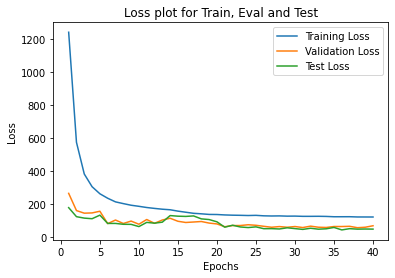

In [ ]:
chart_loss(40,train_vloss,eval_vloss, test_vloss)

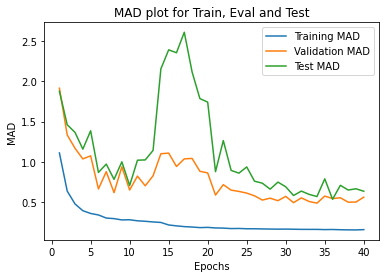

In [ ]:
chart_mad(40,train_MAD,eval_MAD, test_MAD)

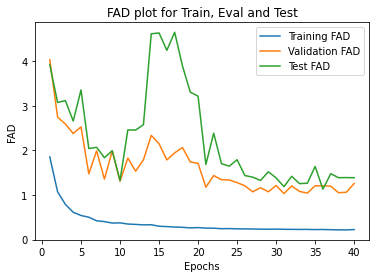

In [ ]:
chart_fad(40,train_FAD,eval_FAD, test_FAD)

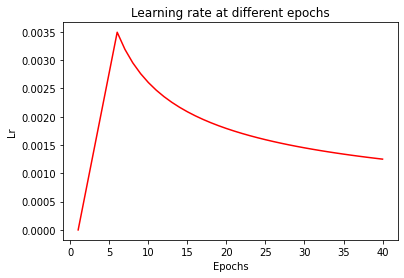

In [ ]:
chart_lr(40,lr)

#### Results

In [ ]:
epochs=[]
for i in range(1,41):
  epochs.append(i)

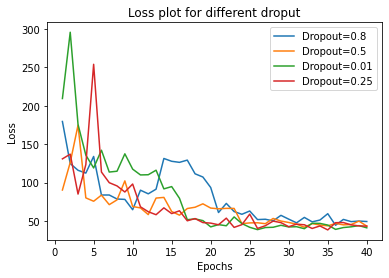

In [ ]:
plt.plot(epochs, loss_d8, label='Dropout=0.8')
plt.plot(epochs, loss_d5, label='Dropout=0.5')
plt.plot(epochs, loss_d001, label='Dropout=0.01')
plt.plot(epochs, loss_d25, label='Dropout=0.25')
plt.title('Loss plot for different droput')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

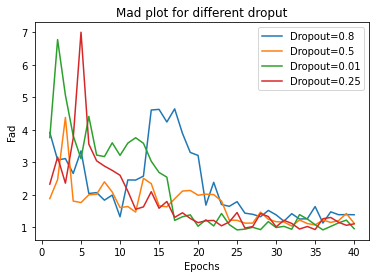

In [ ]:
plt.plot(epochs, fad_d8, label='Dropout=0.8')
plt.plot(epochs, fad_d5, label='Dropout=0.5')
plt.plot(epochs, fad_d001, label='Dropout=0.01')
plt.plot(epochs, fad_d25, label='Dropout=0.25')
plt.title('Fad plot for different droput')#*
plt.xlabel('Epochs')
plt.ylabel('Fad')
plt.legend(loc='best')
plt.show() 

# we made a typo (in the title instead of Fad we wrote Mad), but due to the limitations of google colab on the GPU currently we cannot run the necessary models and thus adjust the plot lable

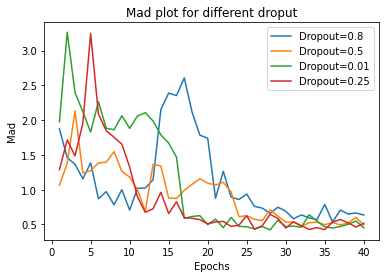

In [ ]:
plt.plot(epochs, mad_d8, label='Dropout=0.8')
plt.plot(epochs, mad_d5, label='Dropout=0.5')
plt.plot(epochs, mad_d001, label='Dropout=0.01')
plt.plot(epochs, mad_d25, label='Dropout=0.25')
plt.title('Mad plot for different droput')
plt.xlabel('Epochs')
plt.ylabel('Mad')
plt.legend(loc='best')
plt.show()

In [ ]:
plt.plot(epochs, lr_d8, label='Dropout=0.8')
plt.plot(epochs, lr_d5, label='Dropout=0.5')
plt.plot(epochs, lr_d001, label='Dropout=0.01')
plt.plot(epochs, lr_d25, label='Dropout=0.25')
plt.title('Lr plot for different F')
plt.xlabel('Epochs')
plt.ylabel('Lr')
plt.legend(loc='best')
plt.show()

As before, we decided to report for each different probability value of the dropout, the value of Loss, Fad and Mad metrics at the last epochs for the Test part

|    Dropout   |    Loss   |   Fad  |Mad|Lr|
|------------|-----------|---------|-----|-----|
|0.8|315|1.4|0.63|0.00125|
|0.5 |276.67|1.12|0.5|0.00125|
|0.25| 276.63 |1.1|0.5|0.00125|
|0.1|265|1.03|0.45|0.00125|
|0.01|262.5|0.96|0.45|0.00125|

Unlike the precendent comparison with the various values of F, we can see that in terms of loss and Mad, the various models are very similar to each other.

The model with the best metrics is the one having dropout equal to 0.01. Although it is important to note that the basic model also has the same fad and mad values as the previous model.

Lastly, it can be seen that obviously the learning rate does not vary.

### 3) Experiment with Epochs=60

We also wanted to try increasing the number of epochs on the base model to see the change in the results.

In [ ]:
# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 3
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 3

emb_size = 512
ff_size = 1024
heads = 8
layers = 6
dropout = 0.1

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

# Argument for the optimizer 
factor = 1.
warmup = 5

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [ ]:
train_vloss=[]
eval_vloss=[]
test_vloss=[]

train_MAD=[]
eval_MAD=[]
test_MAD=[]

train_FAD=[]
eval_FAD=[]
test_FAD=[]

lr=[]

# compute execution time of the cell
start_time = time.time()

# Argument for the training 
epoch = 0
max_epoch = 60          # Total number of epoch
ckp_save_step = 20      # Frequency for saving the model
log_step = 5           # Frequency for printing the loss


print("Start Training...\n")


for epoch in range(max_epoch):
    lr.append(optim._rate)
    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    
    for id_b, batch in enumerate(tr_dl):

        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        pred_speed = train_step(model, batch, mean, std, device)
        gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

        # We compute the two losses, averaging on the batch
        loss1 = F.pairwise_distance(pred_speed[:, :, :2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
        loss2 = torch.abs(pred_speed[:, :, 2]).mean()
        loss = loss1 + loss2

        # We accumulate and visualize the loss at the end of the epoch. 
        # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
        train_loss += loss.item() * batch['trg'].shape[0]

        loss.backward()
        optim.step()

        if input_type == 'speed':
            # If input type is speed, to compute MAD and FAD metrics we need to compute back positions from predicted speeds.
            # This is done easily adding cumulative (and denormalized) speeds to the last observed position. If last position in the input is (x_7, y_7) then:
            # (x_8, y_8)    =   (x_7, y_7) + (u_7, v_7)
            # (x_9, y_9)    =   (x_8, y_8) + (u_8, v_8)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8)
            # (x_10, y_10)  =   (x_9, y_9) + (u_9, v_9)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8) + (u_9, v_9)
            # We have always the last observed position (x_7, y_7) and we add progressively the "cumulated" speeds
            preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)

        elif input_type == 'position':
            # If input type is position, we simply append the output
            preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        

    # After concatenation we compute MAD and FAD metrics
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

    # we save the values in the lists
    train_vloss.append(train_loss/len(tr_dl))
    train_MAD.append(mad)
    train_FAD.append(fad)


    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))



    ###### VALIDATION ######
    # Here is all the same exept for eval_step and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []

        for id_b, batch in enumerate(val_dl):
            
            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            val_loss += loss.item() * batch['trg'].shape[0]

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            
        # After concatenation we compute MAD and FAD metrics
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

        # we save the values in the lists
        eval_vloss.append(val_loss/len(tr_dl))
        eval_MAD.append(mad)
        eval_FAD.append(fad)
  

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))



    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        gt = []
        pr = []
        
        for id_b, batch in enumerate(test_dl):

            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            test_loss += loss.item() * batch['trg'].shape[0]


            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])


        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)

        # we save the values in the lists
        test_vloss.append(test_loss/len(tr_dl))
        test_MAD.append(mad)
        test_FAD.append(fad)



        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        torch.save(model.state_dict(), f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')



# print execution time
print("Total time: %s seconds" % (time.time() - start_time))

# store
fad6= test_FAD
mad6= test_MAD
loss6= test_vloss
lr6= lr

Start Training...

---> Epoch 005/060 <---  LR: 0.00280
Total Train Loss: 597.9875 - MAD:  0.3743 - FAD:  0.5697
Total Eval  Loss: 755.2391 - MAD:  1.3544 - FAD:  2.7810
Total Test  Loss: 810.9996 - MAD:  1.8012 - FAD:  3.0599 

---> Epoch 010/060 <---  LR: 0.00260
Total Train Loss: 202.4077 - MAD:  0.2568 - FAD:  0.3284
Total Eval  Loss: 626.0476 - MAD:  1.0351 - FAD:  2.0358
Total Test  Loss: 747.0749 - MAD:  1.7795 - FAD:  3.0169 

---> Epoch 015/060 <---  LR: 0.00209
Total Train Loss: 129.9100 - MAD:  0.1613 - FAD:  0.2449
Total Eval  Loss: 316.8463 - MAD:  0.5428 - FAD:  1.1183
Total Test  Loss: 362.1237 - MAD:  0.6959 - FAD:  1.5132 

---> Epoch 020/060 <---  LR: 0.00179
Total Train Loss: 110.2835 - MAD:  0.1282 - FAD:  0.1895
Total Eval  Loss: 273.9962 - MAD:  0.4399 - FAD:  1.0198
Total Test  Loss: 291.1011 - MAD:  0.4522 - FAD:  1.0247 

Saving checkpoint... 
 
---> Epoch 025/060 <---  LR: 0.00159
Total Train Loss: 102.3193 - MAD:  0.1179 - FAD:  0.1724
Total Eval  Loss: 246.4

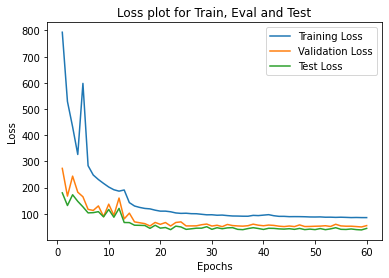

In [ ]:
chart_loss(60,train_vloss,eval_vloss, test_vloss)

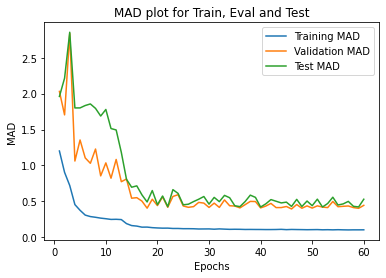

In [ ]:
chart_mad(60,train_MAD,eval_MAD, test_MAD)

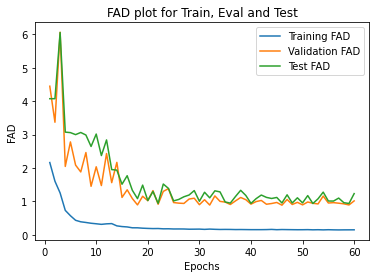

In [ ]:
chart_fad(60,train_FAD,eval_FAD, test_FAD)

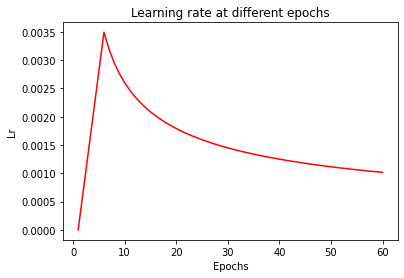

In [ ]:
chart_lr(60,lr)

Analyzing the model prints during training and looking at the graphs of Fad and Mad, we can see that they have a wave-like behavior. By simply analyzing epoch 40 and 60, we find much higher values of loss, fad and mad in the latter than in the 40th. If we also consider epoch 50, however, we can see that this has very similar values to epoch 40

###4)  Change Layers 

In the end we also tried to change the number of layers in our model, we tried with 3 and 12 layers, which are half and twice the original number respectively

#### Layers = 12

In [ ]:
# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 3
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 3

emb_size = 512
ff_size = 1024
heads = 8
layers = 12
dropout = 0.1

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

# Argument for the optimizer 
factor = 1.
warmup = 5

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [ ]:
train_vloss=[]
eval_vloss=[]
test_vloss=[]

train_MAD=[]
eval_MAD=[]
test_MAD=[]

train_FAD=[]
eval_FAD=[]
test_FAD=[]

lr=[]

# compute execution time of the cell
start_time = time.time()

# Argument for the training 
epoch = 0
max_epoch = 40          # Total number of epoch
ckp_save_step = 20      # Frequency for saving the model
log_step = 5           # Frequency for printing the loss


print("Start Training...\n")


for epoch in range(max_epoch):
    lr.append(optim._rate)
    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    
    for id_b, batch in enumerate(tr_dl):

        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        pred_speed = train_step(model, batch, mean, std, device)
        gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

        # We compute the two losses, averaging on the batch
        loss1 = F.pairwise_distance(pred_speed[:, :, :2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
        loss2 = torch.abs(pred_speed[:, :, 2]).mean()
        loss = loss1 + loss2

        # We accumulate and visualize the loss at the end of the epoch. 
        # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
        train_loss += loss.item() * batch['trg'].shape[0]

        loss.backward()
        optim.step()

        if input_type == 'speed':
            # If input type is speed, to compute MAD and FAD metrics we need to compute back positions from predicted speeds.
            # This is done easily adding cumulative (and denormalized) speeds to the last observed position. If last position in the input is (x_7, y_7) then:
            # (x_8, y_8)    =   (x_7, y_7) + (u_7, v_7)
            # (x_9, y_9)    =   (x_8, y_8) + (u_8, v_8)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8)
            # (x_10, y_10)  =   (x_9, y_9) + (u_9, v_9)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8) + (u_9, v_9)
            # We have always the last observed position (x_7, y_7) and we add progressively the "cumulated" speeds
            preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)

        elif input_type == 'position':
            # If input type is position, we simply append the output
            preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        

    # After concatenation we compute MAD and FAD metrics
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

    # we save the values in the lists
    train_vloss.append(train_loss/len(tr_dl))
    train_MAD.append(mad)
    train_FAD.append(fad)


    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))



    ###### VALIDATION ######
    # Here is all the same exept for eval_step and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []

        for id_b, batch in enumerate(val_dl):
            
            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            val_loss += loss.item() * batch['trg'].shape[0]

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            
        # After concatenation we compute MAD and FAD metrics
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

        # we save the values in the lists
        eval_vloss.append(val_loss/len(tr_dl))
        eval_MAD.append(mad)
        eval_FAD.append(fad)
  

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))



    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        gt = []
        pr = []
        
        for id_b, batch in enumerate(test_dl):

            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            test_loss += loss.item() * batch['trg'].shape[0]


            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])


        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)

        # we save the values in the lists
        test_vloss.append(test_loss/len(tr_dl))
        test_MAD.append(mad)
        test_FAD.append(fad)



        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        torch.save(model.state_dict(), f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')



# print execution time
print("Total time: %s seconds" % (time.time() - start_time))

fad_l12= test_FAD
mad_l12= test_MAD
loss_l12= test_vloss
lr_l12= lr

Start Training...

---> Epoch 005/040 <---  LR: 0.00280
Total Train Loss: 318.9857 - MAD:  0.3861 - FAD:  0.6007
Total Eval  Loss: 804.0402 - MAD:  1.2884 - FAD:  2.7034
Total Test  Loss: 891.0057 - MAD:  1.8253 - FAD:  3.2307 

---> Epoch 010/040 <---  LR: 0.00260
Total Train Loss: 184.1438 - MAD:  0.2324 - FAD:  0.3148
Total Eval  Loss: 430.8285 - MAD:  0.7509 - FAD:  1.5744
Total Test  Loss: 464.7808 - MAD:  0.9410 - FAD:  1.6705 

---> Epoch 015/040 <---  LR: 0.00209
Total Train Loss: 160.1715 - MAD:  0.1764 - FAD:  0.2642
Total Eval  Loss: 327.2014 - MAD:  0.6240 - FAD:  1.1644
Total Test  Loss: 377.7407 - MAD:  0.7616 - FAD:  1.4078 

---> Epoch 020/040 <---  LR: 0.00179
Total Train Loss: 108.1708 - MAD:  0.1254 - FAD:  0.1863
Total Eval  Loss: 265.9604 - MAD:  0.4511 - FAD:  0.9973
Total Test  Loss: 302.6055 - MAD:  0.5124 - FAD:  1.1538 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.00159
Total Train Loss: 100.7549 - MAD:  0.1182 - FAD:  0.1748
Total Eval  Loss: 240.9

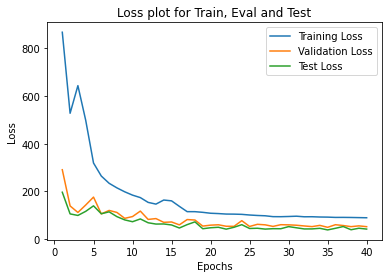

In [ ]:
chart_loss(40,train_vloss,eval_vloss, test_vloss)

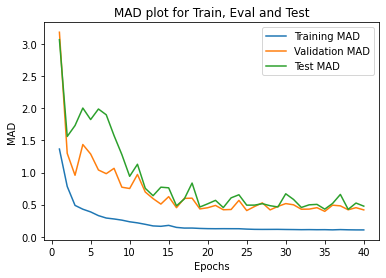

In [ ]:
chart_mad(40,train_MAD,eval_MAD, test_MAD)

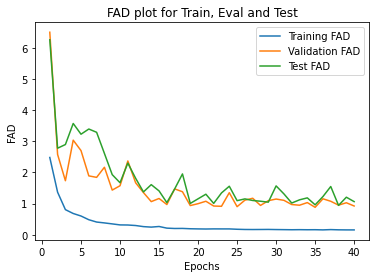

In [ ]:
chart_fad(40,train_FAD,eval_FAD, test_FAD)

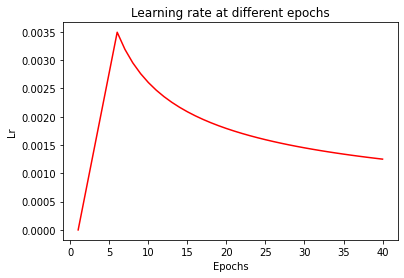

In [ ]:
chart_lr(40,lr)

#### Layers = 3

In [ ]:
# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 3
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 3

emb_size = 512
ff_size = 1024
heads = 8
layers = 3
dropout = 0.1

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

# Argument for the optimizer 
factor = 1.
warmup = 5

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [ ]:
train_vloss=[]
eval_vloss=[]
test_vloss=[]

train_MAD=[]
eval_MAD=[]
test_MAD=[]

train_FAD=[]
eval_FAD=[]
test_FAD=[]

lr=[]

# compute execution time of the cell
start_time = time.time()

# Argument for the training 
epoch = 0
max_epoch = 40          # Total number of epoch
ckp_save_step = 20      # Frequency for saving the model
log_step = 5           # Frequency for printing the loss


print("Start Training...\n")


for epoch in range(max_epoch):
    lr.append(optim._rate)
    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    
    for id_b, batch in enumerate(tr_dl):

        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        pred_speed = train_step(model, batch, mean, std, device)
        gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

        # We compute the two losses, averaging on the batch
        loss1 = F.pairwise_distance(pred_speed[:, :, :2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
        loss2 = torch.abs(pred_speed[:, :, 2]).mean()
        loss = loss1 + loss2

        # We accumulate and visualize the loss at the end of the epoch. 
        # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
        train_loss += loss.item() * batch['trg'].shape[0]

        loss.backward()
        optim.step()

        if input_type == 'speed':
            # If input type is speed, to compute MAD and FAD metrics we need to compute back positions from predicted speeds.
            # This is done easily adding cumulative (and denormalized) speeds to the last observed position. If last position in the input is (x_7, y_7) then:
            # (x_8, y_8)    =   (x_7, y_7) + (u_7, v_7)
            # (x_9, y_9)    =   (x_8, y_8) + (u_8, v_8)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8)
            # (x_10, y_10)  =   (x_9, y_9) + (u_9, v_9)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8) + (u_9, v_9)
            # We have always the last observed position (x_7, y_7) and we add progressively the "cumulated" speeds
            preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)

        elif input_type == 'position':
            # If input type is position, we simply append the output
            preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        

    # After concatenation we compute MAD and FAD metrics
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

    # we save the values in the lists
    train_vloss.append(train_loss/len(tr_dl))
    train_MAD.append(mad)
    train_FAD.append(fad)


    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))



    ###### VALIDATION ######
    # Here is all the same exept for eval_step and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []

        for id_b, batch in enumerate(val_dl):
            
            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            val_loss += loss.item() * batch['trg'].shape[0]

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            
        # After concatenation we compute MAD and FAD metrics
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

        # we save the values in the lists
        eval_vloss.append(val_loss/len(tr_dl))
        eval_MAD.append(mad)
        eval_FAD.append(fad)
  

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))



    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        gt = []
        pr = []
        
        for id_b, batch in enumerate(test_dl):

            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            test_loss += loss.item() * batch['trg'].shape[0]


            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])


        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)

        # we save the values in the lists
        test_vloss.append(test_loss/len(tr_dl))
        test_MAD.append(mad)
        test_FAD.append(fad)



        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        torch.save(model.state_dict(), f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')



# print execution time
print("Total time: %s seconds" % (time.time() - start_time))

fad_l3= test_FAD
mad_l3= test_MAD
loss_l3= test_vloss
lr_l3= lr


Start Training...

---> Epoch 005/040 <---  LR: 0.00312
Total Train Loss: 383.5139 - MAD:  0.5771 - FAD:  0.9721
Total Eval  Loss: 996.3857 - MAD:  2.3226 - FAD:  5.0711
Total Test  Loss: 1039.4885 - MAD:  2.4897 - FAD:  5.2055 

---> Epoch 010/040 <---  LR: 0.00254
Total Train Loss: 180.6728 - MAD:  0.2514 - FAD:  0.3092
Total Eval  Loss: 433.3527 - MAD:  0.9632 - FAD:  1.7292
Total Test  Loss: 590.4404 - MAD:  1.7987 - FAD:  2.9459 

---> Epoch 015/040 <---  LR: 0.00205
Total Train Loss: 150.2680 - MAD:  0.2099 - FAD:  0.2726
Total Eval  Loss: 306.1164 - MAD:  0.5489 - FAD:  1.0417
Total Test  Loss: 352.6660 - MAD:  0.8072 - FAD:  1.4226 

---> Epoch 020/040 <---  LR: 0.00177
Total Train Loss: 110.2278 - MAD:  0.1266 - FAD:  0.1814
Total Eval  Loss: 243.9689 - MAD:  0.4207 - FAD:  0.9272
Total Test  Loss: 255.6225 - MAD:  0.4312 - FAD:  0.9408 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.00158
Total Train Loss: 101.7411 - MAD:  0.1207 - FAD:  0.1727
Total Eval  Loss: 243.

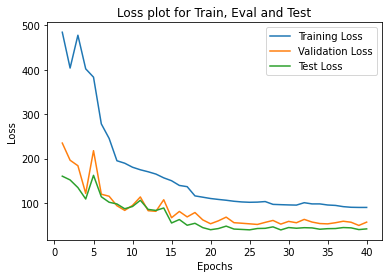

In [ ]:
chart_loss(40,train_vloss,eval_vloss, test_vloss)

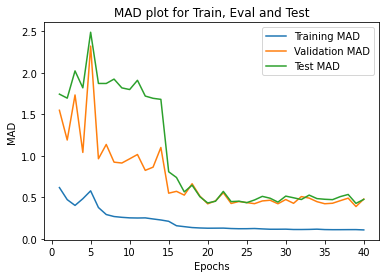

In [ ]:
chart_mad(40,train_MAD,eval_MAD, test_MAD)

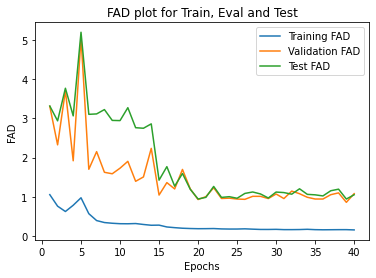

In [ ]:
chart_fad(40,train_FAD,eval_FAD, test_FAD)

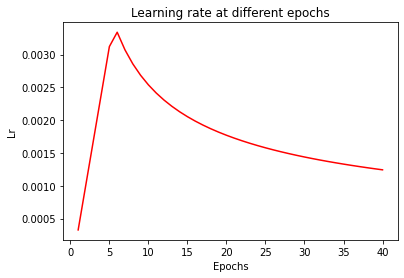

In [ ]:
chart_lr(40,lr)

#### Results

In [ ]:
epochs=[]
for i in range(1,41):
  epochs.append(i)

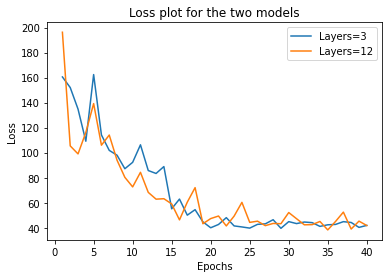

In [ ]:
plt.plot(epochs, loss_l3, label='Layers=3')
plt.plot(epochs, loss_l12, label='Layers=12')
plt.title('Loss plot for the two models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

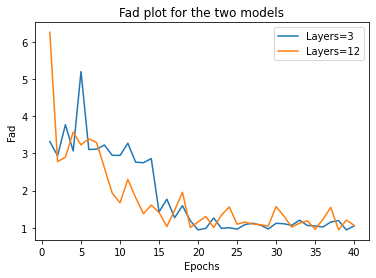

In [ ]:
plt.plot(epochs, fad_l3, label='Layers=3')
plt.plot(epochs, fad_l12, label='Layers=12')
plt.title('Fad plot for the two models')
plt.xlabel('Epochs')
plt.ylabel('Fad')
plt.legend(loc='best')
plt.show()

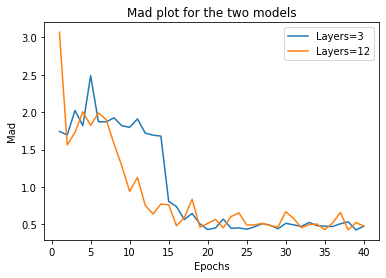

In [ ]:
plt.plot(epochs, mad_l3, label='Layers=3')
plt.plot(epochs, mad_l12, label='Layers=12')
plt.title('Mad plot for the two models')
plt.xlabel('Epochs')
plt.ylabel('Mad')
plt.legend(loc='best')
plt.show()

|    Layers   |    Loss   |   Fad  |Mad|Lr|
|------------|-----------|---------|-----|-----|
|3|267.7|1.04|0.47|0.00124|
|6 |265|1.03|0.45|0.00125|
|12|267|1.06|0.47|0.00125|

We can state is that the difference in the three models with 3,6 and 12 layers is minimal in the results of the metrics.
Also observing the graphs we can state that the trend in the case the layers are equal to 12 is more undulatory.


### Summary

At the end of the experiments performed, we can state several things: 
1. Increasing the number of epochs while holding the learning rate constant has no particular advantages on the results.
2. Varying the dropout probability, leaving the other hyperparameters constant does not lead to obvious changes in performance ( if we exclude the case where p=0.8 where the results get worse).
3. If we increase the learning rate a lot the performance decreases and among the various lr tested the initial one is the best.
4. We did not notice significant performance changes by modifying the number of layers.

## 1. Substitute for the Prediction Framework  (***6 POINTS***)

---

The standard task is the regression of future speeds/positions. 

We propose to implement to different frameworks: Gaussian and Quantized.

---

### a.  Gaussian


Predicting normal distribution parameters mean vector $\mu = (\mu_x, \mu_y)$ and covariance matrix $\Sigma = \biggl( \begin{smallmatrix}\sigma_x^2 & \rho \sigma_x \sigma_y\\ \rho \sigma_x \sigma_y & \sigma_y^2 \end{smallmatrix}\biggr)$ of future predicition. 

Then the model output dimension is 5: 2 for mean parameters $\mu_x, \mu_y$ and 3 for the covariance parameters $\sigma_x, \sigma_y, \rho$.

---

Note: consider carefully the following code snippet. In this way we force $\sigma_x, \sigma_y$ to be positive and $\rho$ to be in $[-1, 1]$

The following lines are meant to be a hint. Integrate those into the code of the previous cells.

In [ ]:
#model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

#output = model(inp, dec_inp, src_att, trg_att)

#mux = output[:, :, 0].unsqueeze(2)
#muy = output[:, :, 1].unsqueeze(2)
#sx = torch.exp(output[:, :, 2]).unsqueeze(2)
#sy = torch.exp(output[:, :, 3]).unsqueeze(2)
#corr = torch.tanh(output[:, :, 4]).unsqueeze(2)

#mean = torch.cat((mux, muy), dim=2).to(device)
#cov = torch.cat((sx**2, corr*sx*sy, corr*sx*sy, sy**2), dim=2).view((-1, sx.size(1), 2, 2)).to(device)

Next prediction can be now sampled from the predicted distribution making the forecasting stochastic.

The loss used in this case is the NLL.  

Note: To relax the assumption you can also use predicted mean as input for following step (particularly in eval and test), avoiding the sampling and assuming identity as covariance matrix.

In [ ]:
from torch.distributions.multivariate_normal import MultivariateNormal

In [ ]:
# Arguments to setup the datasets
dataset_name = 'zara1'
framework = 'gauss'
obs_num = 8
preds_num = 12

# We limit the number of samples to a fixed percentage for the sake of time
perc_data = 50

# With predefined function we create dataset according to arguments
train_dataset,_ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=True, perc_data=perc_data, verbose=True)
val_dataset, _  = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, perc_data=perc_data, verbose=True)
test_dataset, _ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, eval=True, verbose=True)

# We create some folders to save model checkpoints
if not os.path.isdir("save_folder"):
    os.mkdir("save_folder")
if not os.path.isdir("save_folder/"+framework):
    os.mkdir("save_folder/"+framework)
if not os.path.isdir("save_folder/"+framework+"/"+dataset_name):
    os.mkdir("save_folder/"+framework+"/"+dataset_name)

start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara02_train.txt
002 / 007 - loading crowds_zara03_train.txt
003 / 007 - loading students003_train.txt
004 / 007 - loading uni_examples_train.txt
005 / 007 - loading biwi_hotel_train.txt
006 / 007 - loading biwi_eth_train.txt
007 / 007 - loading students001_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara03_val.txt
002 / 007 - loading biwi_hotel_val.txt
003 / 007 - loading uni_examples_val.txt
004 / 007 - loading biwi_eth_val.txt
005 / 007 - loading crowds_zara02_val.txt
006 / 007 - loading students003_val.txt
007 / 007 - loading students001_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt


In [ ]:
input_type = 'speed'

if input_type == 'speed':
    input_idx_1 = 2
    input_idx_2 = 4
    first_element = 1
    
elif input_type == 'position':
    input_idx_1 = 0
    input_idx_2 = 2
    first_element = 0

In [ ]:
# After concatenating each observed and target sequence we compute the mean and std
mean = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).mean((0,1))
std  = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).std((0,1))

In [ ]:
num_obs = len(train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2][0])
num_target = len(train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2][0])

cov = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1)\
      .reshape(len(train_dataset[:]['src'])*(num_obs+num_target),2)
corcoeff = torch.corrcoef(cov.T)
cov = torch.cov(cov.T)[0][-1]
correlation = cov/(torch.prod(std))

In [ ]:
batch_size = 64

tr_dl   = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dl  = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=0)
test_dl = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
enc_input_size = 2
dec_input_size = 6
dec_output_size = 6

emb_size = 64
ff_size = 1024
heads = 8
layers = 6
dropout = 0.1

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

In [ ]:
# Argument for the optimizer 
factor = 1
warmup = 5

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [ ]:
def gaus_train_step(model, batch, mean, std, device):

    # If input type is speed then input (or source 'src') has shape (B, N_obs-1, 2) because the first one is (0,0).
    # Otherwise, if input type is position then input  has shape (B, N_obs, 2).
    # Note that the input of the decoder are only the first  N_pred-1  GT future value then target ('trg') has shape (B, N_pred-1, 2).
    inp    = (batch['src'][:,  first_element:, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)
    target = (batch['trg'][:, :-1, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)
    

    # We create a third mask channel to append to the 2 speeds. 
    # This helps the decoder differentiating between start of sequence token (with mask token 1) and target speeds (with mask token 0)
    # Summarizing: start_of_seq token is (0,0) and the mask token is 1 ---> [0, 0, 1]
    #              target inputs are (u_i, v_i) and the mask token is 0 ---> [u_i, v_i, 0]
    
    start_of_seq = torch.Tensor([0, 0, 0, 0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(target.shape[0], 1, 1).to(device)
    target_c = torch.zeros((target.shape[0], target.shape[1], 1)).to(device)
    
    # Final decoder input is the concatenation of them along temporal dimension of mean, standard deviation and correlation
    std_ext = std.repeat(target.shape[0], target.shape[1], 1).to(device)
    mean_col = mean.repeat(target.shape[0], target.shape[1], 1).to(device)
    dec_inp1 = torch.cat((mean_col, std_ext), -1)
    dec_inp2 = torch.cat((dec_inp1, correlation.repeat(target.shape[0], target.shape[1], 1).to(device)), -1)
    target = torch.cat((dec_inp2, target_c), -1)
    dec_inp = torch.cat((start_of_seq, target), 1)
    # Source attention is enabled between all the observed input (mask elements are setted to 1)
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    # For the target attention we mask future elements to prevent model cheating (corresponding future mask elements are setted to False)
    # The mask is changed dinamically to use teacher forcing learning
    trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
    # Source, target and corresponding attention mask are passed to the model for the forward step
    pred = model(inp, dec_inp, src_att, trg_att)

    return pred


def gaus_eval_step(model, batch, mean, std, device, preds=12):

    # In the evaluation step we don't provide target to the decoder but we autoregressively input each prediction for the following one.
    inp = (batch['src'][:, first_element:, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

    # The decoder input is the only start of sequence token [0, 0, 1]
    # Please note that now model has to predict also the third channel mask (See loss2 in the main loop)
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    start_of_seq = torch.Tensor([0, 0, 0, 0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(inp.shape[0], 1, 1).to(device)
    dec_inp = start_of_seq

    # We predict just one future speed and we append it to the decoder input for the next iteration (auto-regression)
    # At each step the target mask should be adapted
    for i in range(preds):
        trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
        out = model(inp, dec_inp, src_att, trg_att)
        dec_inp = torch.cat((dec_inp, out[:, -1:, :]), 1)

    # Note at the each iteration of the loop we re-append the start of seq token, so after the last iteration we need to remove it
    return dec_inp[:, 1:, :]

In [ ]:
train_vloss=[]
eval_vloss=[]
test_vloss=[]

train_MAD=[]
eval_MAD=[]
test_MAD=[]

train_FAD=[]
eval_FAD=[]
test_FAD=[]

lr=[]

# compute execution time of the cell
start_time = time.time()

# Argument for the training 
epoch = 0
max_epoch = 40          # Total number of epoch
ckp_save_step = 20      # Frequency for saving the model
log_step = 5           # Frequency for printing the loss


print("Start Training...\n")


for epoch in range(max_epoch):

    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    
    for id_b, batch in enumerate(tr_dl):

        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        output = gaus_train_step(model, batch, mean, std, device)
        
        gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)
        
        mux = output[:, :, 0].unsqueeze(2)
        muy = output[:, :, 1].unsqueeze(2)
        sx = torch.exp(output[:, :, 2]).unsqueeze(2)
        sy = torch.exp(output[:, :, 3]).unsqueeze(2)
        corr = torch.tanh(output[:, :, 4]).unsqueeze(2)

        mean_ = torch.cat((mux, muy), dim=2).to(device)
        cov_ = torch.cat((sx**2, corr*sx*sy, corr*sx*sy, sy**2), dim=2).view((-1, sx.size(1), 2, 2)).to(device)


        m = MultivariateNormal(mean_, cov_)
        sample = m.sample()
        loss1 = -m.log_prob(gt_speed).mean()
        loss2 = torch.abs(output[:, :, 5]).mean()
        loss = loss1 + loss2
        
        train_loss += loss.item() * batch['trg'].shape[0]
        
        loss.backward()
        optim.step()
        # We store both predicted and GT positions
        if input_type == 'speed':
            preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (sample[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
        elif input_type == 'position':
            preds_tr_b = (sample[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        

    # After concatenation we compute MAD and FAD metrics
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)
    
    # we save the values in the lists
    train_vloss.append(train_loss/len(tr_dl))
    train_MAD.append(mad)
    train_FAD.append(fad)

    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))
   
    ###### VALIDATION ######
        # Here is all the same exept for eval_step and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []

        for id_b, batch in enumerate(val_dl):
            if batch['trg'].shape[0]<batch_size:
                continue
            output = gaus_eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            mux = output[:, :, 0].unsqueeze(2)
            muy = output[:, :, 1].unsqueeze(2)
            sx = torch.exp(output[:, :, 2]).unsqueeze(2)
            sy = torch.exp(output[:, :, 3]).unsqueeze(2)
            corr = torch.tanh(output[:, :, 4]).unsqueeze(2)

            mean_ = torch.cat((mux, muy), dim=2).to(device)
            cov_ = torch.cat((sx**2, corr*sx*sy, corr*sx*sy, sy**2), dim=2).view((-1, sx.size(1), 2, 2)).to(device)


            # We compute NLL loss
            m = MultivariateNormal(mean_, cov_)
            sample = m.sample()
            loss1 = -m.log_prob(gt_speed).mean()
            #loss1 = -m.log_prob(sample).mean()
            loss2 = torch.abs(output[:, :, 5]).mean()
            loss = loss1 + loss2

            val_loss += loss.item() * batch['trg'].shape[0]
            # We store both predicted and GT positions
            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (sample[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (sample[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])

        # After concatenation we compute MAD and FAD metrics
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)
        
        # we save the values in the lists
        eval_vloss.append(val_loss/len(tr_dl))
        eval_MAD.append(mad)
        eval_FAD.append(fad)

    if (epoch+1) % log_step == 0:
        print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))




    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        gt = []
        pr = []

        for id_b, batch in enumerate(test_dl):

            output = gaus_eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            mux = output[:, :, 0].unsqueeze(2)
            muy = output[:, :, 1].unsqueeze(2)
            sx = torch.exp(output[:, :, 2]).unsqueeze(2)
            sy = torch.exp(output[:, :, 3]).unsqueeze(2)
            corr = torch.tanh(output[:, :, 4]).unsqueeze(2)

            mean_ = torch.cat((mux, muy), dim=2).to(device)
            cov_ = torch.cat((sx**2, corr*sx*sy, corr*sx*sy, sy**2), dim=2).view((-1, sx.size(1), 2, 2)).to(device)


            # We compute NLL loss
            m = MultivariateNormal(mean_, cov_)
            sample = m.sample()
            loss1 = -m.log_prob(gt_speed).mean()
            loss2 = torch.abs(output[:, :, 5]).mean()
            loss = loss1 + loss2
            test_loss += loss.item() * batch['trg'].shape[0]
            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (sample[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (sample[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])


        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)
        
        test_vloss.append(test_loss/len(tr_dl))
        test_MAD.append(mad)
        test_FAD.append(fad)

    if (epoch+1) % log_step == 0:
        print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))
            
if ((epoch+1) % (ckp_save_step) == 0):
    print("Saving checkpoint... \n ")
    torch.save(model.state_dict(), f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')

# print execution time
print("Total time: %s seconds" % (time.time() - start_time))

lr_Gauss= lr
pr_Gauss=pr

Start Training...

---> Epoch 005/040 <---  LR: 0.00281
Total Train Loss: 92.1808 - MAD:  0.6179 - FAD:  1.2211
Total Eval  Loss: 70.5479 - MAD:  0.5258 - FAD:  1.0376
Total Test  Loss: 100.8532 - MAD:  0.6821 - FAD:  1.3370 

---> Epoch 010/040 <---  LR: 0.00261
Total Train Loss: 78.6787 - MAD:  0.5678 - FAD:  1.1484
Total Eval  Loss: 84.7872 - MAD:  0.4845 - FAD:  0.9927
Total Test  Loss: 88.2267 - MAD:  0.5068 - FAD:  1.0200 

---> Epoch 015/040 <---  LR: 0.00210
Total Train Loss: 74.2599 - MAD:  0.5479 - FAD:  1.1130
Total Eval  Loss: 71.3806 - MAD:  0.5001 - FAD:  0.9981
Total Test  Loss: 85.8038 - MAD:  0.5175 - FAD:  1.0064 

---> Epoch 020/040 <---  LR: 0.00180
Total Train Loss: 68.4049 - MAD:  0.5343 - FAD:  1.0915
Total Eval  Loss: 78.8797 - MAD:  0.4513 - FAD:  0.9237
Total Test  Loss: 93.4225 - MAD:  0.4692 - FAD:  0.9442 

---> Epoch 025/040 <---  LR: 0.00160
Total Train Loss: 64.1765 - MAD:  0.5266 - FAD:  1.0744
Total Eval  Loss: 124.2550 - MAD:  0.4321 - FAD:  0.9010
To

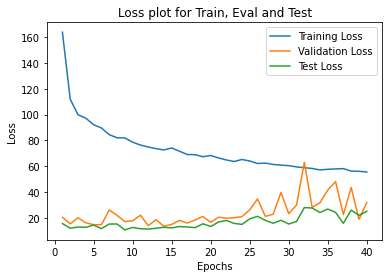

In [ ]:
chart_loss(40,train_vloss,eval_vloss, test_vloss)

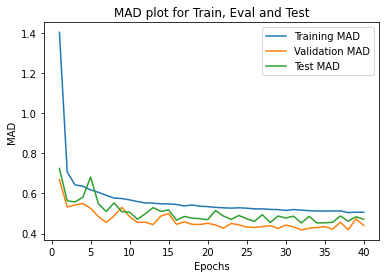

In [ ]:
chart_mad(40,train_MAD,eval_MAD, test_MAD)

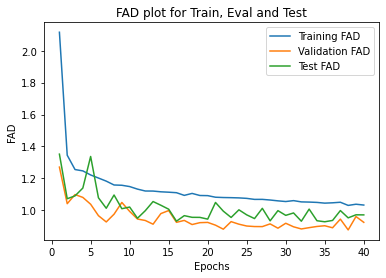

In [ ]:
chart_fad(40,train_FAD,eval_FAD, test_FAD)

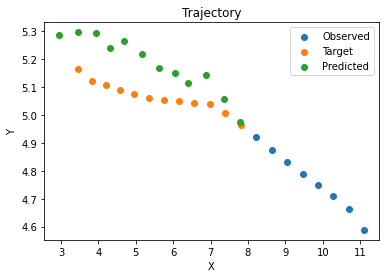

In [ ]:
chart_trajectory(test_dataset,20,pr_Gauss)

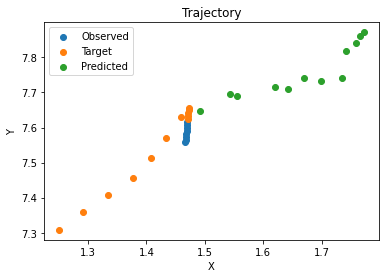

In [ ]:
chart_trajectory(test_dataset,140,pr_Gauss)

####Gaussian framework report:
The gaussian framework is based on predicting the mean, standard deviation and correlation of a multivariare gaussian distribution. During training, we used positions as encoder input and mean, standard deviation and correlation, which were calculated across the entire dataset, as decoder input. During validation and test, we autoregressively input the last mean, standard deviation and correlation to the decoder.
We observed that the gaussian framework, with respect to the regression framework, got slightly better performances over the zara1 dataset, but with a cosistent increase of the training time.
From MAD and FAD plots we can see that performances get better over the epochs and probably will not improve significantly if trained for more then 40 epochs.
We can see that the prediction will be very poor in cases where the trajectory will change drastically, probably beacuse the model has learnt that most of the time people will walk on a straight line, so the model's predicted postions are, usually, following the direction of the observed ones.

#### Load

In [ ]:
# Instanciate a new model and loading its parameters

# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 6
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 6

emb_size = 512
ff_size = 1024
heads = 8
layers = 6
dropout = 0.1

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)


# Loading arguments
epoch = 40
dataset_name = 'zara1'
framework='gauss'
path = f'save_folder/{framework}/{dataset_name}/{(epoch):05d}.pth'
model.load_state_dict(torch.load(path))


# Setup correctly optimizer and its LR as well
factor = 1.
warmup = 10

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
optim._step = epoch-1

### b. Quantized

Transformer was originally introduced in the NLP i.e. for next word classification task.
    
To emulate this case we change dataset (clustering all possible speed in C classes) and model to classify the most likely one (with CE loss).

Here we provide a script for the quantized dataset, so you may adapt the final part of the model to output probability score for each class (output_size=1000 + softmax) followed by CE loss.

---

Note: In the quantized framework the start of sequence token is adapted: 

The class indices spans from 0 to 999, so we add index 1000 to represent the start of sequence token

The following lines are meant to be hint, wisely integrate them with the code in the previous cells.  

In [ ]:
# Arguments to setup the datasets
dataset_name = 'zara1'
framework = 'quant'
obs_num = 8
preds_num = 12

# We limit the number of samples to a fixed percentage for the sake of time
perc_data = 50

# With predefined function we create dataset according to arguments
train_dataset,_ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=True, perc_data=perc_data, verbose=True)
val_dataset, _  = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, perc_data=perc_data, verbose=True)
test_dataset, _ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, eval=True, verbose=True)

# Load precomputed clusters to quantize the data
mat = scipy.io.loadmat(os.path.join('datasets', dataset_name, "clusters.mat"))
clusters=mat['centroids']
num_classes = clusters.shape[0]

# We create some folders to save model checkpoints
if not os.path.isdir("save_folder"):
    os.mkdir("save_folder")
if not os.path.isdir("save_folder/"+framework):
    os.mkdir("save_folder/"+framework)
if not os.path.isdir("save_folder/"+framework+"/"+dataset_name):
    os.mkdir("save_folder/"+framework+"/"+dataset_name)

In [ ]:
# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = num_classes
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = num_classes+1
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = num_classes

emb_size = 512
ff_size = 2048
heads = 8
layers = 6
dropout = 0.1


model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)


# Inside the train and eval step we need to convert speed/position to cluster index
batch_size = batch['src'].shape[0]

# Associate the nearest class to each speed/position
speeds_inp=batch['src'][:,1:,2:4]
inp=torch.tensor(scipy.spatial.distance.cdist(speeds_inp.reshape(-1,2), clusters).argmin(axis=1).reshape(batch_size, -1)).to(device)

speeds_trg = batch['trg'][:,:,2:4]
target = torch.tensor(scipy.spatial.distance.cdist(speeds_trg.reshape(-1, 2), clusters).argmin(axis=1).reshape(batch_size, -1)).to(device)




# Class are indices from 0 to 999. 
# We add index 1000 to represent the start of sequence token
start_of_seq = torch.tensor([1000]).repeat(batch_size).unsqueeze(1).to(device)



# We predict class indexes of future speeds/positions
output = model(inp, dec_inp, src_att, trg_att)

loss = F.cross_entropy(output.view(-1, num_classes), target.view(-1), reduction='mean')



# To compute metrics we need positions. Then we convert back each predicted index to the relative centroid speed/position values
preds_tr_b = batch['src'][:,-1:,0:2].cpu().numpy() + clusters[output.cpu().numpy()].cumsum(1)
pr.append(preds_tr_b)

In [ ]:
# Here your code 

Here your report

---


Here we ask you to change some settings in order to compare the benefit of some specific mechanism.

Please follow the instructions and create a small report for each point adding your comments supported by plots, tables with results or whatever you think is usefull.

Each extra study included to improve general performance or to draft a more complete analysis will be considered.

---

**Note:** to have a fair comparison we suggest to fix the setup (i.e. Regressive TF with speeds, obs=8, pred=12, ...) and change just the analysed module.

---

## 2. Increase Prediction Horizon (Short- or Long-term Forecasting)  (***3 POINTS***)

---

You can easily increase/decrease the number of predictions (i.e. pred = 4, 8, 12, 20, 30, 50 ....) in the dataloader and see the effect on the MAD/FAD metric.

Report your results in a table and/or plot and comment what you see.

---

### Functions

First we define all the functions that are needed at this point.
We have in fact a function for each part of the algorithm:

1. createDataset() which creates the datasets based on the number of predictions (to allow for 20 predictions we set the percentage of the data equal to 100)
2. modelInstantiation() create an instance of our transformer with the chosen configuration 
3. train_step() and eval_step2() define the single iteration function for train and validation (in the case of validation, we did not set the number of predictions to 12 as the one provided at the beginning within the function)
4. optimizer() is the optimizer in the paper of Vaswani et al.
5. mainPart() trains, validates and tests our transformer epoch by epoch.



In [ ]:
def createDataset(number_prediction):
  # Arguments to setup the datasets
 dataset_name = 'zara1'
 framework = 'regr'
 obs_num = 8
 preds_num = number_prediction

 # We limit the number of samples to a fixed percentage for the sake of time
 perc_data = 100

 # With predefined function we create dataset according to arguments
 train_dataset,_ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=True, perc_data=perc_data, verbose=True)
 val_dataset, _  = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, perc_data=perc_data, verbose=True)
 test_dataset, _ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, eval=True, verbose=True)

 # We create some folders to save model checkpoints
 if not os.path.isdir("save_folder"):
    os.mkdir("save_folder")
 if not os.path.isdir("save_folder/"+framework):
    os.mkdir("save_folder/"+framework)

 if not os.path.isdir("save_folder/"+framework+"/"+dataset_name):
    os.mkdir("save_folder/"+framework+"/"+dataset_name)

 input_type = 'speed'

 if input_type == 'speed':
    input_idx_1 = 2
    input_idx_2 = 4
    first_element = 1
    
 elif input_type == 'position':
    input_idx_1 = 0
    input_idx_2 = 2
    first_element = 0
  
 # After concatenating each observed and target sequence we compute the mean and std
 mean = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).mean((0,1))
 std  = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).std((0,1))

 batch_size = 512

 tr_dl   = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
 val_dl  = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=0)
 test_dl = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

 return tr_dl, val_dl, test_dl, mean, std, preds_num, obs_num, batch_size, input_idx_1, input_idx_2, first_element, input_type

In [ ]:
def modelInstantiation():
  # The input for the encoder are speeds (u,v) or positions (x,y)
 enc_input_size = 2
 # The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
 # Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
 dec_input_size = 3
 # The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
 dec_output_size = 3

 emb_size = 512
 ff_size = 1024
 heads = 8
 layers = 6
 dropout = 0.1
 model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)
 return enc_input_size, dec_input_size, dec_output_size, emb_size, ff_size, heads, layers, dropout, model

In [ ]:
def train_step(model, batch, mean, std, device):

    # If input type is speed then input (or source 'src') has shape (B, N_obs-1, 2) because the first one is (0,0).
    # Otherwise, if input type is position then input  has shape (B, N_obs, 2).
    # Note that the input of the decoder are only the first  N_pred-1  GT future value then target ('trg') has shape (B, N_pred-1, 2).
    inp    = (batch['src'][:,  first_element:, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)
    target = (batch['trg'][:, :-1, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

    # We create a third mask channel to append to the 2 speeds. 
    # This helps the decoder differentiating between start of sequence token (with mask token 1) and target speeds (with mask token 0)
    # Summarizing: start_of_seq token is (0,0) and the mask token is 1 ---> [0, 0, 1]
    #              target inputs are (u_i, v_i) and the mask token is 0 ---> [u_i, v_i, 0]
    start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(target.shape[0], 1, 1).to(device)
    target_c = torch.zeros((target.shape[0], target.shape[1], 1)).to(device)
    target = torch.cat((target, target_c), -1)
    # Final decoder input is the concatenation of them along temporal dimension
    dec_inp = torch.cat((start_of_seq, target), 1)

    # Source attention is enabled between all the observed input (mask elements are setted to 1)
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    # For the target attention we mask future elements to prevent model cheating (corresponding future mask elements are setted to False)
    # The mask is changed dinamically to use teacher forcing learning
    trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
    # Source, target and corresponding attention mask are passed to the model for the forward step
    pred = model(inp, dec_inp, src_att, trg_att)

    return pred


def eval_step2(model, batch, mean, std, device, preds):

    # In the evaluation step we don't provide target to the decoder but we autoregressively input each prediction for the following one.
    inp = (batch['src'][:, first_element:, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

    # The decoder input is the only start of sequence token [0, 0, 1]
    # Please note that now model has to predict also the third channel mask (See loss2 in the main loop)
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(inp.shape[0], 1, 1).to(device)
    dec_inp = start_of_seq

    # We predict just one future speed and we append it to the decoder input for the next iteration (auto-regression)
    # At each step the target mask should be adapted
    for i in range(preds):
        trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
        out = model(inp, dec_inp, src_att, trg_att)
        dec_inp = torch.cat((dec_inp, out[:, -1:, :]), 1)

    # Note at the each iteration of the loop we re-append the start of seq token, so after the last iteration we need to remove it
    return dec_inp[:, 1:, :]

In [ ]:
def optimizer(emb_size, tr_dl, model):
  factor = 1.
  warmup = 5

  optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
  return factor, warmup, optim

In [ ]:
def mainPart(optim, tr_dl, val_dl, test_dl, model):
  

 train_vloss=[]
 eval_vloss=[]
 test_vloss=[]

 train_MAD=[]
 eval_MAD=[]
 test_MAD=[]

 train_FAD=[]
 eval_FAD=[]
 test_FAD=[]

 lr=[]
 # compute execution time of the cell
 start_time = time.time()

 # Argument for the training 
 epoch = 0
 max_epoch = 40          # Total number of epoch
 ckp_save_step = 20      # Frequency for saving the model
 log_step = 5           # Frequency for printing the loss


 print("Start Training...\n")


 for epoch in range(max_epoch):
    lr.append(optim._rate)
    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    
    for id_b, batch in enumerate(tr_dl):

        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        pred_speed = train_step(model, batch, mean, std, device)
        gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

        # We compute the two losses, averaging on the batch
        loss1 = F.pairwise_distance(pred_speed[:, :, :2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
        loss2 = torch.abs(pred_speed[:, :, 2]).mean()
        loss = loss1 + loss2

        # We accumulate and visualize the loss at the end of the epoch. 
        # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
        train_loss += loss.item() * batch['trg'].shape[0]

        loss.backward()
        optim.step()

        if input_type == 'speed':
            # If input type is speed, to compute MAD and FAD metrics we need to compute back positions from predicted speeds.
            # This is done easily adding cumulative (and denormalized) speeds to the last observed position. If last position in the input is (x_7, y_7) then:
            # (x_8, y_8)    =   (x_7, y_7) + (u_7, v_7)
            # (x_9, y_9)    =   (x_8, y_8) + (u_8, v_8)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8)
            # (x_10, y_10)  =   (x_9, y_9) + (u_9, v_9)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8) + (u_9, v_9)
            # We have always the last observed position (x_7, y_7) and we add progressively the "cumulated" speeds
            preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)

        elif input_type == 'position':
            # If input type is position, we simply append the output
            preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        

    # After concatenation we compute MAD and FAD metrics
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

    # we save the values in the lists
    train_vloss.append(train_loss/len(tr_dl))
    train_MAD.append(mad)
    train_FAD.append(fad)

    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))



    ###### VALIDATION ######
    # Here is all the same exept for eval_step2 and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []

        for id_b, batch in enumerate(val_dl):
            
            pred_speed = eval_step2(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            val_loss += loss.item() * batch['trg'].shape[0]

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            
        # After concatenation we compute MAD and FAD metrics
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

        # we save the values in the lists
        eval_vloss.append(val_loss/len(tr_dl))
        eval_MAD.append(mad)
        eval_FAD.append(fad)

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))



    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        gt = []
        pr = []
        
        for id_b, batch in enumerate(test_dl):

            pred_speed = eval_step2(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            test_loss += loss.item() * batch['trg'].shape[0]


            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])


        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)


        # we save the values in the lists
        test_vloss.append(test_loss/len(tr_dl))
        test_MAD.append(mad)
        test_FAD.append(fad)

        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        



 # print execution time
 print("Total time: %s seconds" % (time.time() - start_time))

 return  max_epoch, lr, train_MAD,eval_MAD, test_MAD, train_FAD,eval_FAD, test_FAD

### Preds = 2

In [ ]:
tr_dl, val_dl, test_dl, mean, std, preds_num, obs_num, batch_size, input_idx_1, input_idx_2, first_element, input_type = createDataset(2)

start loading dataset
validation set size -> 0
001 / 007 - loading biwi_hotel_train.txt
002 / 007 - loading biwi_eth_train.txt
003 / 007 - loading students003_train.txt
004 / 007 - loading crowds_zara03_train.txt
005 / 007 - loading crowds_zara02_train.txt
006 / 007 - loading students001_train.txt
007 / 007 - loading uni_examples_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading uni_examples_val.txt
002 / 007 - loading biwi_eth_val.txt
003 / 007 - loading students001_val.txt
004 / 007 - loading students003_val.txt
005 / 007 - loading biwi_hotel_val.txt
006 / 007 - loading crowds_zara02_val.txt
007 / 007 - loading crowds_zara03_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt


In [ ]:
enc_input_size, dec_input_size, dec_output_size, emb_size, ff_size, heads, layers, dropout, model = modelInstantiation()

In [ ]:
factor, warmup, optim = optimizer(emb_size, tr_dl, model)

In [ ]:
n_epoch, lr2, train_MAD2,eval_MAD2, test_MAD2, train_FAD2,eval_FAD2, test_FAD2 = mainPart(optim, tr_dl, val_dl, test_dl, model)

Start Training...

---> Epoch 005/040 <---  LR: 0.00175
Total Train Loss: 277.5959 - MAD:  0.1036 - FAD:  0.1387
Total Eval  Loss: 238.6293 - MAD:  0.1013 - FAD:  0.1376
Total Test  Loss: 188.1538 - MAD:  0.0724 - FAD:  0.0997 

---> Epoch 010/040 <---  LR: 0.00163
Total Train Loss: 129.7627 - MAD:  0.0728 - FAD:  0.0933
Total Eval  Loss: 154.9298 - MAD:  0.0881 - FAD:  0.1241
Total Test  Loss: 109.7845 - MAD:  0.0594 - FAD:  0.0872 

---> Epoch 015/040 <---  LR: 0.00130
Total Train Loss: 100.5177 - MAD:  0.0613 - FAD:  0.0766
Total Eval  Loss: 154.1833 - MAD:  0.1001 - FAD:  0.1404
Total Test  Loss: 103.5817 - MAD:  0.0658 - FAD:  0.0954 

---> Epoch 020/040 <---  LR: 0.00112
Total Train Loss: 94.6676 - MAD:  0.0580 - FAD:  0.0716
Total Eval  Loss: 144.1026 - MAD:  0.0950 - FAD:  0.1318
Total Test  Loss: 98.5029 - MAD:  0.0652 - FAD:  0.0931 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.00100
Total Train Loss: 91.1221 - MAD:  0.0550 - FAD:  0.0680
Total Eval  Loss: 125.2418

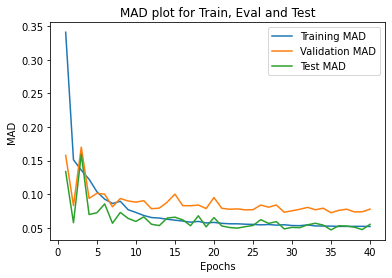

In [ ]:
chart_mad(n_epoch,train_MAD2,eval_MAD2, test_MAD2)

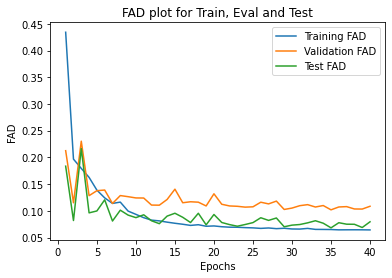

In [ ]:
chart_fad(n_epoch,train_FAD2,eval_FAD2, test_FAD2)

### Preds = 4

In [ ]:
tr_dl, val_dl, test_dl, mean, std, preds_num, obs_num, batch_size, input_idx_1, input_idx_2, first_element, input_type = createDataset(4)

start loading dataset
validation set size -> 0
001 / 007 - loading biwi_hotel_train.txt
002 / 007 - loading biwi_eth_train.txt
003 / 007 - loading students003_train.txt
004 / 007 - loading crowds_zara03_train.txt
005 / 007 - loading crowds_zara02_train.txt
006 / 007 - loading students001_train.txt
007 / 007 - loading uni_examples_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading uni_examples_val.txt
002 / 007 - loading biwi_eth_val.txt
003 / 007 - loading students001_val.txt
004 / 007 - loading students003_val.txt
005 / 007 - loading biwi_hotel_val.txt
006 / 007 - loading crowds_zara02_val.txt
007 / 007 - loading crowds_zara03_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt


In [ ]:
enc_input_size, dec_input_size, dec_output_size, emb_size, ff_size, heads, layers, dropout, model = modelInstantiation()

In [ ]:
factor, warmup, optim = optimizer(emb_size, tr_dl, model)

In [ ]:
n_epoch, lr4, train_MAD4,eval_MAD4, test_MAD4, train_FAD4,eval_FAD4, test_FAD4 = mainPart(optim, tr_dl, val_dl, test_dl, model)

Start Training...

---> Epoch 005/040 <---  LR: 0.00181
Total Train Loss: 338.6507 - MAD:  0.1647 - FAD:  0.2507
Total Eval  Loss: 383.0982 - MAD:  0.1783 - FAD:  0.3201
Total Test  Loss: 357.0014 - MAD:  0.1637 - FAD:  0.3029 

---> Epoch 010/040 <---  LR: 0.00169
Total Train Loss: 117.2372 - MAD:  0.0948 - FAD:  0.1305
Total Eval  Loss: 229.1242 - MAD:  0.1827 - FAD:  0.3258
Total Test  Loss: 196.3303 - MAD:  0.1547 - FAD:  0.2801 

---> Epoch 015/040 <---  LR: 0.00135
Total Train Loss: 99.6792 - MAD:  0.0794 - FAD:  0.1090
Total Eval  Loss: 174.2739 - MAD:  0.1550 - FAD:  0.2765
Total Test  Loss: 144.2386 - MAD:  0.1267 - FAD:  0.2332 

---> Epoch 020/040 <---  LR: 0.00116
Total Train Loss: 92.2455 - MAD:  0.0733 - FAD:  0.1007
Total Eval  Loss: 174.5193 - MAD:  0.1512 - FAD:  0.2714
Total Test  Loss: 144.7710 - MAD:  0.1249 - FAD:  0.2288 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.00103
Total Train Loss: 89.0935 - MAD:  0.0732 - FAD:  0.1010
Total Eval  Loss: 172.8132

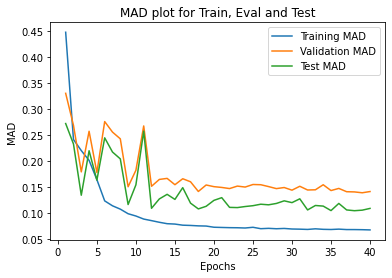

In [ ]:
chart_mad(n_epoch,train_MAD4,eval_MAD4, test_MAD4)

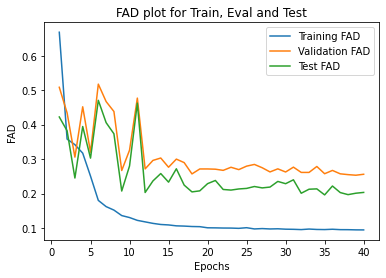

In [ ]:
chart_fad(n_epoch,train_FAD4,eval_FAD4, test_FAD4)

### Preds = 8

In [ ]:
tr_dl, val_dl, test_dl, mean, std, preds_num, obs_num, batch_size, input_idx_1, input_idx_2, first_element, input_type = createDataset(8)

start loading dataset
validation set size -> 0
001 / 007 - loading biwi_hotel_train.txt
002 / 007 - loading biwi_eth_train.txt
003 / 007 - loading students003_train.txt
004 / 007 - loading crowds_zara03_train.txt
005 / 007 - loading crowds_zara02_train.txt
006 / 007 - loading students001_train.txt
007 / 007 - loading uni_examples_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading uni_examples_val.txt
002 / 007 - loading biwi_eth_val.txt
003 / 007 - loading students001_val.txt
004 / 007 - loading students003_val.txt
005 / 007 - loading biwi_hotel_val.txt
006 / 007 - loading crowds_zara02_val.txt
007 / 007 - loading crowds_zara03_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt


In [ ]:
enc_input_size, dec_input_size, dec_output_size, emb_size, ff_size, heads, layers, dropout, model = modelInstantiation()

In [ ]:
factor, warmup, optim = optimizer(emb_size, tr_dl, model)

In [ ]:
n_epoch, lr8, train_MAD8,eval_MAD8, test_MAD8, train_FAD8,eval_FAD8, test_FAD8 = mainPart(optim, tr_dl, val_dl, test_dl, model)

Start Training...

---> Epoch 005/040 <---  LR: 0.00196
Total Train Loss: 308.7117 - MAD:  0.3797 - FAD:  0.5739
Total Eval  Loss: 617.9799 - MAD:  0.8287 - FAD:  1.4505
Total Test  Loss: 612.8127 - MAD:  0.9451 - FAD:  1.5379 

---> Epoch 010/040 <---  LR: 0.00183
Total Train Loss: 124.6898 - MAD:  0.1235 - FAD:  0.1799
Total Eval  Loss: 262.7755 - MAD:  0.3843 - FAD:  0.7937
Total Test  Loss: 245.8871 - MAD:  0.3597 - FAD:  0.7456 

---> Epoch 015/040 <---  LR: 0.00147
Total Train Loss: 99.0528 - MAD:  0.1031 - FAD:  0.1490
Total Eval  Loss: 232.9433 - MAD:  0.3126 - FAD:  0.6571
Total Test  Loss: 209.8327 - MAD:  0.2821 - FAD:  0.5924 

---> Epoch 020/040 <---  LR: 0.00126
Total Train Loss: 91.6820 - MAD:  0.0978 - FAD:  0.1415
Total Eval  Loss: 239.0861 - MAD:  0.3183 - FAD:  0.6817
Total Test  Loss: 212.2230 - MAD:  0.2818 - FAD:  0.6104 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.00112
Total Train Loss: 92.0299 - MAD:  0.0944 - FAD:  0.1356
Total Eval  Loss: 239.6054

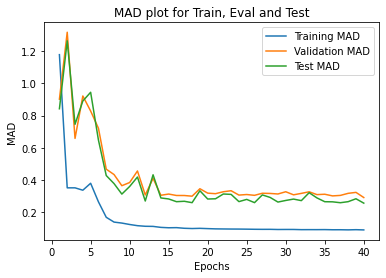

In [ ]:
chart_mad(n_epoch,train_MAD8,eval_MAD8, test_MAD8)

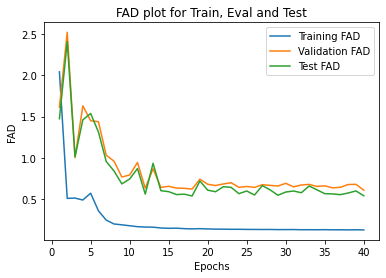

In [ ]:
chart_fad(n_epoch,train_FAD8,eval_FAD8, test_FAD8)

### Preds = 12

In [ ]:
tr_dl, val_dl, test_dl, mean, std, preds_num, obs_num, batch_size, input_idx_1, input_idx_2, first_element, input_type = createDataset(12)

start loading dataset
validation set size -> 0
001 / 007 - loading biwi_hotel_train.txt
002 / 007 - loading biwi_eth_train.txt
003 / 007 - loading students003_train.txt
004 / 007 - loading crowds_zara03_train.txt
005 / 007 - loading crowds_zara02_train.txt
006 / 007 - loading students001_train.txt
007 / 007 - loading uni_examples_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading uni_examples_val.txt
002 / 007 - loading biwi_eth_val.txt
003 / 007 - loading students001_val.txt
004 / 007 - loading students003_val.txt
005 / 007 - loading biwi_hotel_val.txt
006 / 007 - loading crowds_zara02_val.txt
007 / 007 - loading crowds_zara03_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt


In [ ]:
enc_input_size, dec_input_size, dec_output_size, emb_size, ff_size, heads, layers, dropout, model = modelInstantiation()

In [ ]:
factor, warmup, optim = optimizer(emb_size, tr_dl, model)

In [ ]:
n_epoch, lr12, train_MAD12,eval_MAD12, test_MAD12, train_FAD12,eval_FAD12, test_FAD12 = mainPart(optim, tr_dl, val_dl, test_dl, model)

Start Training...

---> Epoch 005/040 <---  LR: 0.00211
Total Train Loss: 327.3170 - MAD:  0.4604 - FAD:  0.7296
Total Eval  Loss: 809.0868 - MAD:  1.8797 - FAD:  3.9166
Total Test  Loss: 841.4175 - MAD:  2.2649 - FAD:  4.2132 

---> Epoch 010/040 <---  LR: 0.00197
Total Train Loss: 153.0910 - MAD:  0.1626 - FAD:  0.2419
Total Eval  Loss: 341.3934 - MAD:  0.5628 - FAD:  1.2195
Total Test  Loss: 323.4558 - MAD:  0.5061 - FAD:  1.1346 

---> Epoch 015/040 <---  LR: 0.00158
Total Train Loss: 104.4092 - MAD:  0.1275 - FAD:  0.1892
Total Eval  Loss: 263.8658 - MAD:  0.4886 - FAD:  1.0866
Total Test  Loss: 257.8688 - MAD:  0.4620 - FAD:  1.0513 

---> Epoch 020/040 <---  LR: 0.00135
Total Train Loss: 96.0332 - MAD:  0.1155 - FAD:  0.1679
Total Eval  Loss: 253.2697 - MAD:  0.4790 - FAD:  1.0472
Total Test  Loss: 254.7358 - MAD:  0.4821 - FAD:  1.0896 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.00121
Total Train Loss: 91.4971 - MAD:  0.1118 - FAD:  0.1625
Total Eval  Loss: 282.813

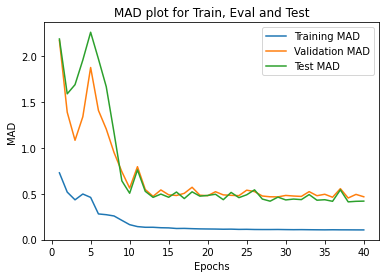

In [ ]:
chart_mad(n_epoch,train_MAD12,eval_MAD12, test_MAD12)

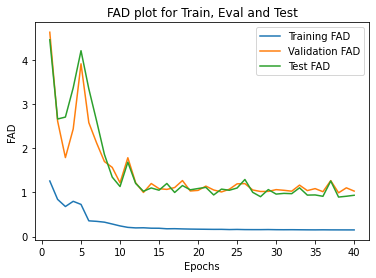

In [ ]:
chart_fad(n_epoch,train_FAD12,eval_FAD12, test_FAD12)

### Preds = 16

In [ ]:
tr_dl, val_dl, test_dl, mean, std, preds_num, obs_num, batch_size, input_idx_1, input_idx_2, first_element, input_type = createDataset(16)

start loading dataset
validation set size -> 0
001 / 007 - loading biwi_hotel_train.txt
002 / 007 - loading biwi_eth_train.txt
003 / 007 - loading students003_train.txt
004 / 007 - loading crowds_zara03_train.txt
005 / 007 - loading crowds_zara02_train.txt
006 / 007 - loading students001_train.txt
007 / 007 - loading uni_examples_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading uni_examples_val.txt
002 / 007 - loading biwi_eth_val.txt
003 / 007 - loading students001_val.txt
004 / 007 - loading students003_val.txt
005 / 007 - loading biwi_hotel_val.txt
006 / 007 - loading crowds_zara02_val.txt
007 / 007 - loading crowds_zara03_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt


In [ ]:
enc_input_size, dec_input_size, dec_output_size, emb_size, ff_size, heads, layers, dropout, model = modelInstantiation()

In [ ]:
factor, warmup, optim = optimizer(emb_size, tr_dl, model)

In [ ]:
n_epoch, lr16, train_MAD16,eval_MAD16, test_MAD16, train_FAD16,eval_FAD16, test_FAD16 = mainPart(optim, tr_dl, val_dl, test_dl, model)

Start Training...

---> Epoch 005/040 <---  LR: 0.00226
Total Train Loss: 242.8804 - MAD:  0.3783 - FAD:  0.5879
Total Eval  Loss: 1199.1435 - MAD:  2.6318 - FAD:  6.0850
Total Test  Loss: 1213.6842 - MAD:  3.2159 - FAD:  6.7612 

---> Epoch 010/040 <---  LR: 0.00210
Total Train Loss: 149.7304 - MAD:  0.2375 - FAD:  0.3057
Total Eval  Loss: 683.4958 - MAD:  1.9413 - FAD:  4.5045
Total Test  Loss: 688.3986 - MAD:  2.2265 - FAD:  4.6195 

---> Epoch 015/040 <---  LR: 0.00169
Total Train Loss: 106.6959 - MAD:  0.1400 - FAD:  0.2068
Total Eval  Loss: 291.9013 - MAD:  0.6336 - FAD:  1.3924
Total Test  Loss: 283.6793 - MAD:  0.6307 - FAD:  1.4006 

---> Epoch 020/040 <---  LR: 0.00145
Total Train Loss: 97.1796 - MAD:  0.1303 - FAD:  0.1920
Total Eval  Loss: 317.3524 - MAD:  0.7181 - FAD:  1.6584
Total Test  Loss: 295.2364 - MAD:  0.6652 - FAD:  1.5297 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.00129
Total Train Loss: 92.1809 - MAD:  0.1241 - FAD:  0.1815
Total Eval  Loss: 343.9

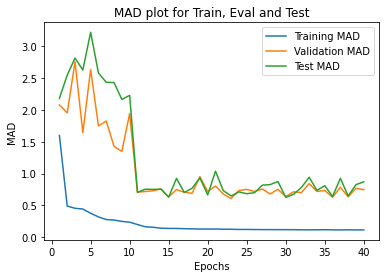

In [ ]:
chart_mad(n_epoch,train_MAD16,eval_MAD16, test_MAD16)

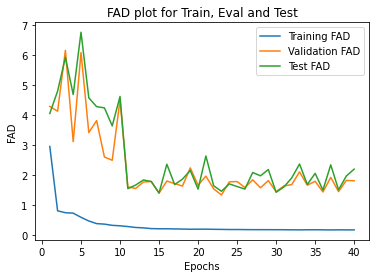

In [ ]:
chart_fad(n_epoch,train_FAD16,eval_FAD16, test_FAD16)

### Preds = 20

In [ ]:
tr_dl, val_dl, test_dl, mean, std, preds_num, obs_num, batch_size, input_idx_1, input_idx_2, first_element, input_type = createDataset(20)

start loading dataset
validation set size -> 0
001 / 007 - loading uni_examples_train.txt
002 / 007 - loading crowds_zara02_train.txt
003 / 007 - loading biwi_hotel_train.txt
004 / 007 - loading students003_train.txt
005 / 007 - loading crowds_zara03_train.txt
006 / 007 - loading biwi_eth_train.txt
007 / 007 - loading students001_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading uni_examples_val.txt
002 / 007 - loading students001_val.txt
003 / 007 - loading crowds_zara03_val.txt
004 / 007 - loading crowds_zara02_val.txt
005 / 007 - loading students003_val.txt
006 / 007 - loading biwi_eth_val.txt
007 / 007 - loading biwi_hotel_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt


In [ ]:
enc_input_size, dec_input_size, dec_output_size, emb_size, ff_size, heads, layers, dropout, model = modelInstantiation()

In [ ]:
factor, warmup, optim = optimizer(emb_size, tr_dl, model)

In [ ]:
n_epoch, lr20, train_MAD20, eval_MAD20, test_MAD20, train_FAD20,eval_FAD20, test_FAD20 = mainPart(optim, tr_dl, val_dl, test_dl, model)

Start Training...

---> Epoch 005/040 <---  LR: 0.00244
Total Train Loss: 332.7282 - MAD:  0.4862 - FAD:  0.8219
Total Eval  Loss: 629.9672 - MAD:  1.6038 - FAD:  2.9747
Total Test  Loss: 788.9067 - MAD:  3.1787 - FAD:  5.9559 

---> Epoch 010/040 <---  LR: 0.00227
Total Train Loss: 171.1130 - MAD:  0.2914 - FAD:  0.4213
Total Eval  Loss: 744.2012 - MAD:  2.2009 - FAD:  5.0925
Total Test  Loss: 698.5437 - MAD:  2.9067 - FAD:  5.4265 

---> Epoch 015/040 <---  LR: 0.00182
Total Train Loss: 111.3995 - MAD:  0.1619 - FAD:  0.2400
Total Eval  Loss: 467.1658 - MAD:  1.2384 - FAD:  3.0690
Total Test  Loss: 453.9386 - MAD:  1.4613 - FAD:  3.5818 

---> Epoch 020/040 <---  LR: 0.00156
Total Train Loss: 104.2473 - MAD:  0.1446 - FAD:  0.2133
Total Eval  Loss: 423.3857 - MAD:  1.0443 - FAD:  2.5229
Total Test  Loss: 413.9900 - MAD:  1.2219 - FAD:  3.0417 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.00139
Total Train Loss: 97.3674 - MAD:  0.1452 - FAD:  0.2203
Total Eval  Loss: 327.30

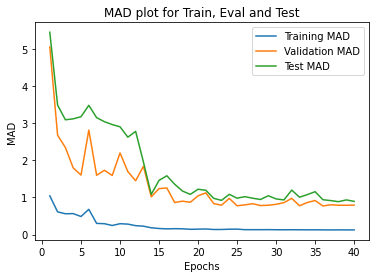

In [ ]:
chart_mad(n_epoch,train_MAD20,eval_MAD20, test_MAD20)

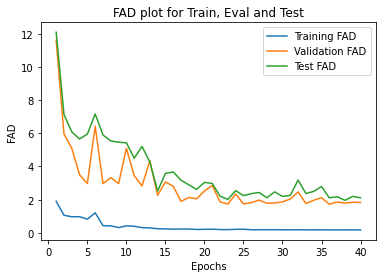

In [ ]:
chart_fad(n_epoch,train_FAD20,eval_FAD20, test_FAD20)

### Results

|    # Predictions   |   Mad  |Fad|time|
|------------|---------|-----|-----|
|2|0.05|0.08|796|
|4 |0.10|0.20|1024|
|8|0.25|0.54|1375|
|12|0.42|0.93|1647|
|16 |0.87|2.2|1828|
|20|0.89|2.11|1992|

From the table we can see that as the forecast increases, the value of the metrics Fad and Mad goes up a lot.
in fact when we have only 2 prediction the value of the metrics is practically zero, instead already at 16 prediction the fad has exceeded the value of 2 and the mad is almost 1.

In addition, between 16 and 20, as the number of predictions we can see that the results vary little between the two and dadd even the fad in the case of 20 predictions is slightly lower than that with 16. probably this could be a result of the randomness of the batch, but in any case it allows us to understand that the performance does not get too much worse after 16.

Lastly, another thing we can notice is that the running time grows as the number of predictions increases.


## 3. Increasing Data Number  (***3 POINTS***)

Transformers are generally very large network and need a lot of data to perform well.

Try to vary the percentage data variable (i.e. 10, 25, 50, 75, 100) and see how the performance changes.

Please report here plots and/or tables for:

1. MAD and FAD metrics 

2. Computational time

### Functions

As before, we report all the functions that are needed at this point.
We have in fact a function for each part of the algorithm:

1. createDatasetPercent() which creates the datasets based on the number of perc_data
2. modelInstantiation() create an instance of our transformer with the chosen configuration 
3. train_step() and eval_step() define the single iteration function for train and validation
4. optimizer() is the optimizer in the paper of Vaswani et al.
5. mainPercent() trains, validates and tests our transformer epoch by epoch.

In [ ]:
def createDatasetPercent(percent):
  # Arguments to setup the datasets
 dataset_name = 'zara1'
 framework = 'regr'
 obs_num = 8
 preds_num = 12

 # We limit the number of samples to a fixed percentage for the sake of time
 perc_data = percent

 # With predefined function we create dataset according to arguments
 train_dataset,_ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=True, perc_data=perc_data, verbose=True)
 val_dataset, _  = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, perc_data=perc_data, verbose=True)
 test_dataset, _ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, eval=True, verbose=True)

 # We create some folders to save model checkpoints
 if not os.path.isdir("save_folder"):
    os.mkdir("save_folder")
 if not os.path.isdir("save_folder/"+framework):
    os.mkdir("save_folder/"+framework)

 if not os.path.isdir("save_folder/"+framework+"/"+dataset_name):
    os.mkdir("save_folder/"+framework+"/"+dataset_name)

 input_type = 'speed'

 if input_type == 'speed':
    input_idx_1 = 2
    input_idx_2 = 4
    first_element = 1
    
 elif input_type == 'position':
    input_idx_1 = 0
    input_idx_2 = 2
    first_element = 0
  
 # After concatenating each observed and target sequence we compute the mean and std
 mean = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).mean((0,1))
 std  = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).std((0,1))

 batch_size = 512

 tr_dl   = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
 val_dl  = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=0)
 test_dl = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

 return tr_dl, val_dl, test_dl, mean, std, preds_num, obs_num, batch_size, input_idx_1, input_idx_2, first_element, input_type

In [ ]:
def modelInstantiation():
  # The input for the encoder are speeds (u,v) or positions (x,y)
 enc_input_size = 2
 # The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
 # Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
 dec_input_size = 3
 # The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
 dec_output_size = 3

 emb_size = 512
 ff_size = 1024
 heads = 8
 layers = 6
 dropout = 0.1
 model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)
 return enc_input_size, dec_input_size, dec_output_size, emb_size, ff_size, heads, layers, dropout, model

In [ ]:
def train_step(model, batch, mean, std, device):

    # If input type is speed then input (or source 'src') has shape (B, N_obs-1, 2) because the first one is (0,0).
    # Otherwise, if input type is position then input  has shape (B, N_obs, 2).
    # Note that the input of the decoder are only the first  N_pred-1  GT future value then target ('trg') has shape (B, N_pred-1, 2).
    inp    = (batch['src'][:,  first_element:, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)
    target = (batch['trg'][:, :-1, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

    # We create a third mask channel to append to the 2 speeds. 
    # This helps the decoder differentiating between start of sequence token (with mask token 1) and target speeds (with mask token 0)
    # Summarizing: start_of_seq token is (0,0) and the mask token is 1 ---> [0, 0, 1]
    #              target inputs are (u_i, v_i) and the mask token is 0 ---> [u_i, v_i, 0]
    start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(target.shape[0], 1, 1).to(device)
    target_c = torch.zeros((target.shape[0], target.shape[1], 1)).to(device)
    target = torch.cat((target, target_c), -1)
    # Final decoder input is the concatenation of them along temporal dimension
    dec_inp = torch.cat((start_of_seq, target), 1)

    # Source attention is enabled between all the observed input (mask elements are setted to 1)
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    # For the target attention we mask future elements to prevent model cheating (corresponding future mask elements are setted to False)
    # The mask is changed dinamically to use teacher forcing learning
    trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
    # Source, target and corresponding attention mask are passed to the model for the forward step
    pred = model(inp, dec_inp, src_att, trg_att)

    return pred


def eval_step(model, batch, mean, std, device, preds=12):


    inp = (batch['src'][:, first_element:, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(inp.shape[0], 1, 1).to(device)
    dec_inp = start_of_seq

    for i in range(preds):
        trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
        out = model(inp, dec_inp, src_att, trg_att)
        dec_inp = torch.cat((dec_inp, out[:, -1:, :]), 1)
    return dec_inp[:, 1:, :]

In [ ]:
def optimizer(emb_size, tr_dl, model):
  factor = 1.
  warmup = 5

  optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
  return factor, warmup, optim

In [ ]:
def mainPercent(optim, tr_dl, val_dl, test_dl, model):
  

 train_vloss=[]
 eval_vloss=[]
 test_vloss=[]

 train_MAD=[]
 eval_MAD=[]
 test_MAD=[]

 train_FAD=[]
 eval_FAD=[]
 test_FAD=[]

 lr=[]
 # compute execution time of the cell
 start_time = time.time()

 # Argument for the training 
 epoch = 0
 max_epoch = 40          # Total number of epoch
 ckp_save_step = 20      # Frequency for saving the model
 log_step = 5           # Frequency for printing the loss


 print("Start Training...\n")


 for epoch in range(max_epoch):
    lr.append(optim._rate)
    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    
    for id_b, batch in enumerate(tr_dl):

        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        pred_speed = train_step(model, batch, mean, std, device)
        gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

        # We compute the two losses, averaging on the batch
        loss1 = F.pairwise_distance(pred_speed[:, :, :2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
        loss2 = torch.abs(pred_speed[:, :, 2]).mean()
        loss = loss1 + loss2

        # We accumulate and visualize the loss at the end of the epoch. 
        # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
        train_loss += loss.item() * batch['trg'].shape[0]

        loss.backward()
        optim.step()

        if input_type == 'speed':
            # If input type is speed, to compute MAD and FAD metrics we need to compute back positions from predicted speeds.
            # This is done easily adding cumulative (and denormalized) speeds to the last observed position. If last position in the input is (x_7, y_7) then:
            # (x_8, y_8)    =   (x_7, y_7) + (u_7, v_7)
            # (x_9, y_9)    =   (x_8, y_8) + (u_8, v_8)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8)
            # (x_10, y_10)  =   (x_9, y_9) + (u_9, v_9)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8) + (u_9, v_9)
            # We have always the last observed position (x_7, y_7) and we add progressively the "cumulated" speeds
            preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)

        elif input_type == 'position':
            # If input type is position, we simply append the output
            preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        

    # After concatenation we compute MAD and FAD metrics
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

    # we save the values in the lists
    train_vloss.append(train_loss/len(tr_dl))
    train_MAD.append(mad)
    train_FAD.append(fad)

    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))



    ###### VALIDATION ######
    # Here is all the same exept for eval_step2 and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []

        for id_b, batch in enumerate(val_dl):
            
            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            val_loss += loss.item() * batch['trg'].shape[0]

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            
        # After concatenation we compute MAD and FAD metrics
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

        # we save the values in the lists
        eval_vloss.append(val_loss/len(tr_dl))
        eval_MAD.append(mad)
        eval_FAD.append(fad)

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))



    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        gt = []
        pr = []
        
        for id_b, batch in enumerate(test_dl):

            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            test_loss += loss.item() * batch['trg'].shape[0]


            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])


        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)


        # we save the values in the lists
        test_vloss.append(test_loss/len(tr_dl))
        test_MAD.append(mad)
        test_FAD.append(fad)

        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        



 # print execution time
 print("Total time: %s seconds" % (time.time() - start_time))

 return  max_epoch, lr, train_MAD,eval_MAD, test_MAD, train_FAD,eval_FAD, test_FAD, train_vloss, eval_vloss, test_vloss

### 20

In [ ]:
tr_dl, val_dl, test_dl, mean, std, preds_num, obs_num, batch_size, input_idx_1, input_idx_2, first_element, input_type = createDatasetPercent(20)

start loading dataset
validation set size -> 0
001 / 007 - loading uni_examples_train.txt
002 / 007 - loading crowds_zara02_train.txt
003 / 007 - loading biwi_hotel_train.txt
004 / 007 - loading students003_train.txt
005 / 007 - loading crowds_zara03_train.txt
006 / 007 - loading biwi_eth_train.txt
007 / 007 - loading students001_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading uni_examples_val.txt
002 / 007 - loading students001_val.txt
003 / 007 - loading crowds_zara03_val.txt
004 / 007 - loading crowds_zara02_val.txt
005 / 007 - loading students003_val.txt
006 / 007 - loading biwi_eth_val.txt
007 / 007 - loading biwi_hotel_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt


In [ ]:
enc_input_size, dec_input_size, dec_output_size, emb_size, ff_size, heads, layers, dropout, model = modelInstantiation()

In [ ]:
factor, warmup, optim = optimizer(emb_size, tr_dl, model)

In [ ]:
n_epoch, lrP2, train_MADP2,eval_MADP2, test_MADP2, train_FADP2,eval_FADP2, test_FADP2, train_vlossP2, eval_vlossP2, test_vlossP2 = mainPercent(optim, tr_dl, val_dl, test_dl, model)

Start Training...

---> Epoch 005/040 <---  LR: 0.00527
Total Train Loss: 494.4718 - MAD:  0.6678 - FAD:  1.1562
Total Eval  Loss: 878.3077 - MAD:  3.0147 - FAD:  6.1459
Total Test  Loss: 975.2611 - MAD:  2.9326 - FAD:  6.0107 

---> Epoch 010/040 <---  LR: 0.00491
Total Train Loss: 287.5294 - MAD:  0.4488 - FAD:  0.6847
Total Eval  Loss: 350.8343 - MAD:  0.7557 - FAD:  1.2874
Total Test  Loss: 515.9113 - MAD:  1.5339 - FAD:  2.2139 

---> Epoch 015/040 <---  LR: 0.00394
Total Train Loss: 305.8995 - MAD:  0.5525 - FAD:  0.9088
Total Eval  Loss: 345.6979 - MAD:  0.9079 - FAD:  1.6983
Total Test  Loss: 487.5330 - MAD:  1.5134 - FAD:  2.3216 

---> Epoch 020/040 <---  LR: 0.00338
Total Train Loss: 188.0695 - MAD:  0.2917 - FAD:  0.3547
Total Eval  Loss: 331.3929 - MAD:  0.9364 - FAD:  1.7395
Total Test  Loss: 470.0534 - MAD:  1.5934 - FAD:  2.4364 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.00301
Total Train Loss: 188.1088 - MAD:  0.3036 - FAD:  0.3829
Total Eval  Loss: 570.2

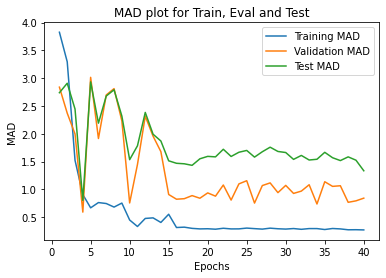

In [ ]:
chart_mad(n_epoch,train_MADP2,eval_MADP2, test_MADP2)

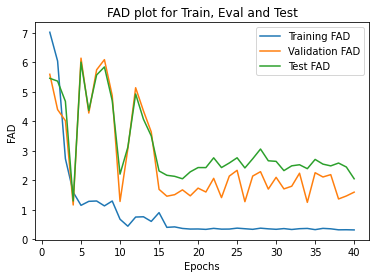

In [ ]:
chart_fad(n_epoch,train_FADP2,eval_FADP2, test_FADP2)

### 30

In [ ]:
tr_dl, val_dl, test_dl, mean, std, preds_num, obs_num, batch_size, input_idx_1, input_idx_2, first_element, input_type = createDatasetPercent(30)

start loading dataset
validation set size -> 0
001 / 007 - loading uni_examples_train.txt
002 / 007 - loading crowds_zara02_train.txt
003 / 007 - loading biwi_hotel_train.txt
004 / 007 - loading students003_train.txt
005 / 007 - loading crowds_zara03_train.txt
006 / 007 - loading biwi_eth_train.txt
007 / 007 - loading students001_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading uni_examples_val.txt
002 / 007 - loading students001_val.txt
003 / 007 - loading crowds_zara03_val.txt
004 / 007 - loading crowds_zara02_val.txt
005 / 007 - loading students003_val.txt
006 / 007 - loading biwi_eth_val.txt
007 / 007 - loading biwi_hotel_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt


In [ ]:
enc_input_size, dec_input_size, dec_output_size, emb_size, ff_size, heads, layers, dropout, model = modelInstantiation()

In [ ]:
factor, warmup, optim = optimizer(emb_size, tr_dl, model)

In [ ]:
n_epoch, lrP3, train_MADP3,eval_MADP3, test_MADP3, train_FADP3,eval_FADP3, test_FADP3, train_vlossP3, eval_vlossP3, test_vlossP3 = mainPercent(optim, tr_dl, val_dl, test_dl, model)

Start Training...

---> Epoch 005/040 <---  LR: 0.00373
Total Train Loss: 478.2184 - MAD:  0.4408 - FAD:  0.6961
Total Eval  Loss: 1260.6236 - MAD:  1.7405 - FAD:  3.7889
Total Test  Loss: 1412.7780 - MAD:  2.3639 - FAD:  4.7138 

---> Epoch 010/040 <---  LR: 0.00347
Total Train Loss: 248.2944 - MAD:  0.2880 - FAD:  0.3766
Total Eval  Loss: 754.8284 - MAD:  1.2072 - FAD:  2.4143
Total Test  Loss: 796.0278 - MAD:  1.8446 - FAD:  3.1047 

---> Epoch 015/040 <---  LR: 0.00278
Total Train Loss: 197.3402 - MAD:  0.2565 - FAD:  0.3137
Total Eval  Loss: 431.4630 - MAD:  0.9460 - FAD:  1.7057
Total Test  Loss: 599.8279 - MAD:  1.8105 - FAD:  3.0635 

---> Epoch 020/040 <---  LR: 0.00239
Total Train Loss: 180.9272 - MAD:  0.2445 - FAD:  0.3053
Total Eval  Loss: 445.9905 - MAD:  0.9201 - FAD:  1.7066
Total Test  Loss: 616.9432 - MAD:  1.8432 - FAD:  3.1839 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.00213
Total Train Loss: 116.8245 - MAD:  0.1603 - FAD:  0.2399
Total Eval  Loss: 284

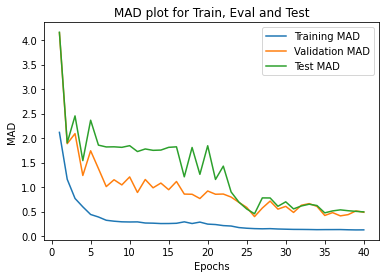

In [ ]:
chart_mad(n_epoch,train_MADP3,eval_MADP3, test_MADP3)

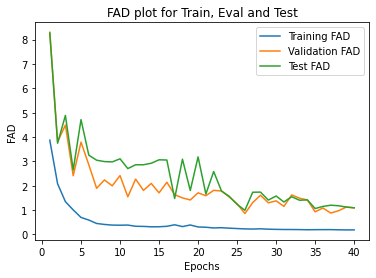

In [ ]:
chart_fad(n_epoch,train_FADP3,eval_FADP3, test_FADP3)

### 50

In [ ]:
tr_dl, val_dl, test_dl, mean, std, preds_num, obs_num, batch_size, input_idx_1, input_idx_2, first_element, input_type = createDatasetPercent(50)

start loading dataset
validation set size -> 0
001 / 007 - loading uni_examples_train.txt
002 / 007 - loading crowds_zara02_train.txt
003 / 007 - loading biwi_hotel_train.txt
004 / 007 - loading students003_train.txt
005 / 007 - loading crowds_zara03_train.txt
006 / 007 - loading biwi_eth_train.txt
007 / 007 - loading students001_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading uni_examples_val.txt
002 / 007 - loading students001_val.txt
003 / 007 - loading crowds_zara03_val.txt
004 / 007 - loading crowds_zara02_val.txt
005 / 007 - loading students003_val.txt
006 / 007 - loading biwi_eth_val.txt
007 / 007 - loading biwi_hotel_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt


In [ ]:
enc_input_size, dec_input_size, dec_output_size, emb_size, ff_size, heads, layers, dropout, model = modelInstantiation()

In [ ]:
factor, warmup, optim = optimizer(emb_size, tr_dl, model)

In [ ]:
n_epoch, lrP5, train_MADP5,eval_MADP5, test_MADP5, train_FADP5,eval_FADP5, test_FADP5, train_vlossP5, eval_vlossP5, test_vlossP5 = mainPercent(optim, tr_dl, val_dl, test_dl, model)

Start Training...

---> Epoch 005/040 <---  LR: 0.00280
Total Train Loss: 334.1197 - MAD:  0.3883 - FAD:  0.5990
Total Eval  Loss: 518.8257 - MAD:  1.0535 - FAD:  1.9393
Total Test  Loss: 657.3265 - MAD:  1.7837 - FAD:  2.9058 

---> Epoch 010/040 <---  LR: 0.00260
Total Train Loss: 214.3956 - MAD:  0.2748 - FAD:  0.3659
Total Eval  Loss: 375.6615 - MAD:  0.9149 - FAD:  1.6155
Total Test  Loss: 580.7332 - MAD:  1.8834 - FAD:  3.2143 

---> Epoch 015/040 <---  LR: 0.00209
Total Train Loss: 125.1089 - MAD:  0.1495 - FAD:  0.2250
Total Eval  Loss: 363.2016 - MAD:  0.6675 - FAD:  1.5578
Total Test  Loss: 382.4813 - MAD:  0.7135 - FAD:  1.6749 

---> Epoch 020/040 <---  LR: 0.00179
Total Train Loss: 108.8122 - MAD:  0.1330 - FAD:  0.1988
Total Eval  Loss: 264.3267 - MAD:  0.4535 - FAD:  1.0104
Total Test  Loss: 294.7763 - MAD:  0.5627 - FAD:  1.2624 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.00159
Total Train Loss: 98.9429 - MAD:  0.1137 - FAD:  0.1646
Total Eval  Loss: 250.93

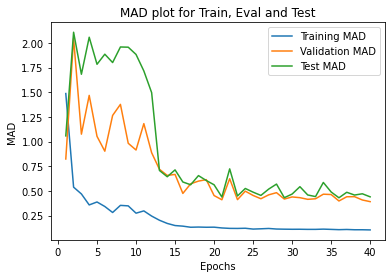

In [ ]:
chart_mad(n_epoch,train_MADP5,eval_MADP5, test_MADP5)

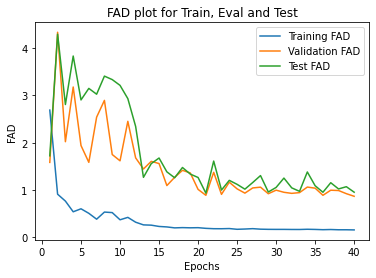

In [ ]:
chart_fad(n_epoch,train_FADP5,eval_FADP5, test_FADP5)

### 75

In [ ]:
tr_dl, val_dl, test_dl, mean, std, preds_num, obs_num, batch_size, input_idx_1, input_idx_2, first_element, input_type = createDatasetPercent(75)

start loading dataset
validation set size -> 0
001 / 007 - loading uni_examples_train.txt
002 / 007 - loading crowds_zara02_train.txt
003 / 007 - loading biwi_hotel_train.txt
004 / 007 - loading students003_train.txt
005 / 007 - loading crowds_zara03_train.txt
006 / 007 - loading biwi_eth_train.txt
007 / 007 - loading students001_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading uni_examples_val.txt
002 / 007 - loading students001_val.txt
003 / 007 - loading crowds_zara03_val.txt
004 / 007 - loading crowds_zara02_val.txt
005 / 007 - loading students003_val.txt
006 / 007 - loading biwi_eth_val.txt
007 / 007 - loading biwi_hotel_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt


In [ ]:
enc_input_size, dec_input_size, dec_output_size, emb_size, ff_size, heads, layers, dropout, model = modelInstantiation()

In [ ]:
factor, warmup, optim = optimizer(emb_size, tr_dl, model)

In [ ]:
n_epoch, lrP7, train_MADP7,eval_MADP7, test_MADP7, train_FADP7,eval_FADP7, test_FADP7, train_vlossP7, eval_vlossP7, test_vlossP7 = mainPercent(optim, tr_dl, val_dl, test_dl, model)

Start Training...

---> Epoch 005/040 <---  LR: 0.00228
Total Train Loss: 375.1177 - MAD:  0.3573 - FAD:  0.5335
Total Eval  Loss: 968.7747 - MAD:  1.7280 - FAD:  3.6774
Total Test  Loss: 1014.1553 - MAD:  2.1679 - FAD:  4.1036 

---> Epoch 010/040 <---  LR: 0.00213
Total Train Loss: 179.6209 - MAD:  0.1879 - FAD:  0.2697
Total Eval  Loss: 353.8551 - MAD:  0.5471 - FAD:  1.0794
Total Test  Loss: 350.3360 - MAD:  0.5210 - FAD:  1.0662 

---> Epoch 015/040 <---  LR: 0.00170
Total Train Loss: 106.4218 - MAD:  0.1273 - FAD:  0.1902
Total Eval  Loss: 405.9318 - MAD:  0.6590 - FAD:  1.5741
Total Test  Loss: 396.0247 - MAD:  0.7075 - FAD:  1.6567 

---> Epoch 020/040 <---  LR: 0.00146
Total Train Loss: 96.5221 - MAD:  0.1171 - FAD:  0.1735
Total Eval  Loss: 313.9211 - MAD:  0.5384 - FAD:  1.2394
Total Test  Loss: 314.5215 - MAD:  0.5659 - FAD:  1.3226 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.00130
Total Train Loss: 91.4942 - MAD:  0.1096 - FAD:  0.1599
Total Eval  Loss: 252.02

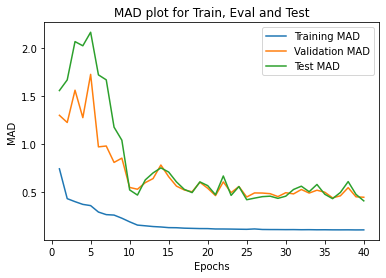

In [ ]:
chart_mad(n_epoch,train_MADP7,eval_MADP7, test_MADP7)

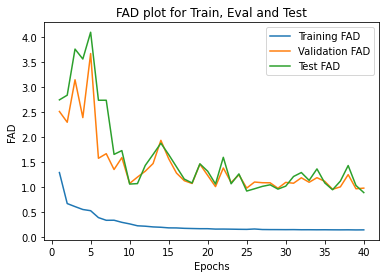

In [ ]:
chart_fad(n_epoch,train_FADP7,eval_FADP7, test_FADP7)

### 100

In [ ]:
tr_dl, val_dl, test_dl, mean, std, preds_num, obs_num, batch_size, input_idx_1, input_idx_2, first_element, input_type = createDatasetPercent(100)

start loading dataset
validation set size -> 0
001 / 007 - loading students001_train.txt
002 / 007 - loading biwi_eth_train.txt
003 / 007 - loading uni_examples_train.txt
004 / 007 - loading biwi_hotel_train.txt
005 / 007 - loading crowds_zara02_train.txt
006 / 007 - loading students003_train.txt
007 / 007 - loading crowds_zara03_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading students003_val.txt
002 / 007 - loading crowds_zara02_val.txt
003 / 007 - loading biwi_eth_val.txt
004 / 007 - loading students001_val.txt
005 / 007 - loading uni_examples_val.txt
006 / 007 - loading crowds_zara03_val.txt
007 / 007 - loading biwi_hotel_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt


In [ ]:
enc_input_size, dec_input_size, dec_output_size, emb_size, ff_size, heads, layers, dropout, model = modelInstantiation()

In [ ]:
factor, warmup, optim = optimizer(emb_size, tr_dl, model)

In [ ]:
n_epoch, lrP1, train_MADP1,eval_MADP1, test_MADP1, train_FADP1,eval_FADP1, test_FADP1, train_vlossP1, eval_vlossP1, test_vlossP1 = mainPercent(optim, tr_dl, val_dl, test_dl, model)

Start Training...

---> Epoch 005/040 <---  LR: 0.00211
Total Train Loss: 219.9394 - MAD:  0.3169 - FAD:  0.4415
Total Eval  Loss: 520.5304 - MAD:  1.2171 - FAD:  2.1039
Total Test  Loss: 623.4085 - MAD:  1.8692 - FAD:  3.1160 

---> Epoch 010/040 <---  LR: 0.00197
Total Train Loss: 118.4144 - MAD:  0.1443 - FAD:  0.2117
Total Eval  Loss: 277.3792 - MAD:  0.5026 - FAD:  1.0924
Total Test  Loss: 285.4413 - MAD:  0.5021 - FAD:  1.1212 

---> Epoch 015/040 <---  LR: 0.00158
Total Train Loss: 107.0593 - MAD:  0.1230 - FAD:  0.1791
Total Eval  Loss: 324.7892 - MAD:  0.6179 - FAD:  1.4155
Total Test  Loss: 294.3645 - MAD:  0.5420 - FAD:  1.2433 

---> Epoch 020/040 <---  LR: 0.00135
Total Train Loss: 94.4234 - MAD:  0.1154 - FAD:  0.1676
Total Eval  Loss: 272.5926 - MAD:  0.5202 - FAD:  1.1395
Total Test  Loss: 268.3516 - MAD:  0.4829 - FAD:  1.0828 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.00121
Total Train Loss: 92.8867 - MAD:  0.1121 - FAD:  0.1628
Total Eval  Loss: 258.353

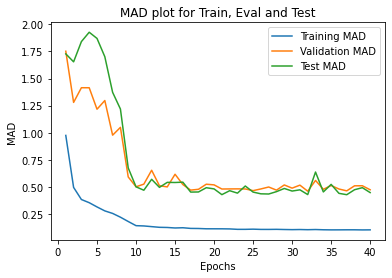

In [ ]:
chart_mad(n_epoch,train_MADP1,eval_MADP1, test_MADP1)

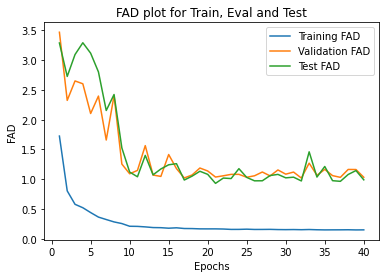

In [ ]:
chart_fad(n_epoch,train_FADP1,eval_FADP1, test_FADP1)

### Results

Due to Google Colab limitations on GPU we decided to manually take the values for CompTime, Mad and Fad directly from the prints of the models

In [ ]:
import matplotlib.pyplot as plt
Examples=[20,30,50,75,100]
CompTime=[540,719,1115,1537,1717]
Mad_P=[1.33, 0.49, 0.44, 0.40, 0.449]
Fad_P=[2.05, 1.09, 0.95, 0.89, 0.99]

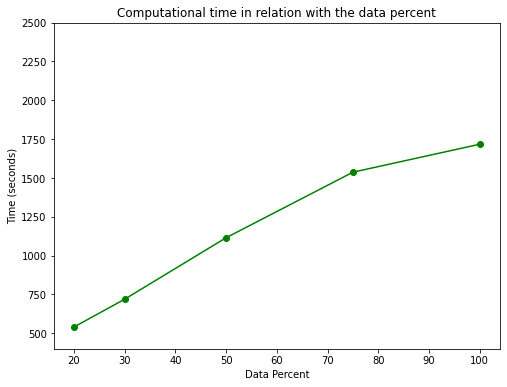

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(Examples, CompTime,'-o',color="green")
plt.ylim(400, 2500)
plt.title("Computational time in relation with the data percent")
plt.xlabel('Data Percent')
plt.ylabel('Time (seconds)')
plt.show()

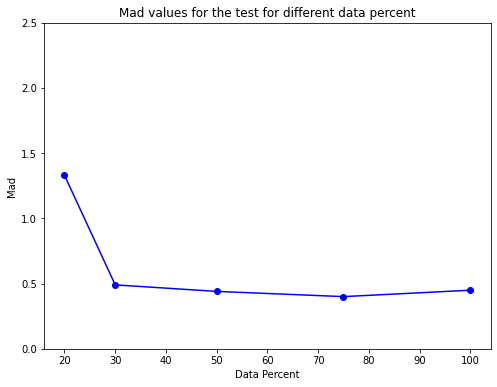

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(Examples, Mad_P,'-o',color="blue")
plt.ylim(0, 2.5)
plt.title("Mad values for the test for different data percent")
plt.xlabel('Data Percent')
plt.ylabel('Mad')
plt.show()

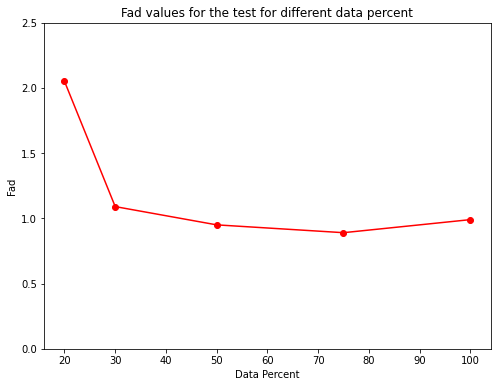

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(Examples, Fad_P,'-o',color="red")
plt.ylim(0, 2.5)
plt.title("Fad values for the test for different data percent")
plt.xlabel('Data Percent')
plt.ylabel('Fad')
plt.show()

From the charts we can say two important things:
1. The greater the percentage of data used in the model, the longer it takes the model to train.

2. The more data we use in the model, keeping the hyperparameters fixed, the better the performance will be.

The results in question are useful, in that we have empirical evidence of what we might have expected.

## 4. Change input Type  (***2 POINTS*** - Bonus)

---

What happens if we change the input form speed type (u,v) to position one (x,y)?

Report then some quantitative results and plot trajectory predicted with both method to evaluate qualitative differences.

---

### Functions

We used the same functions reported in the previous steps with the difference that we created two versions of the function that creates the dataset, one for input=position and one for speed, respectively createDatasetPosition() and createDatasetSpeed().

In [ ]:
def createDatasetSpeed(number_prediction):
  # Arguments to setup the datasets
 dataset_name = 'zara1'
 framework = 'regr'
 obs_num = 8
 preds_num = number_prediction

 # We limit the number of samples to a fixed percentage for the sake of time
 perc_data = 50

 # With predefined function we create dataset according to arguments
 train_dataset,_ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=True, perc_data=perc_data, verbose=True)
 val_dataset, _  = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, perc_data=perc_data, verbose=True)
 test_dataset, _ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, eval=True, verbose=True)

 # We create some folders to save model checkpoints
 if not os.path.isdir("save_folder"):
    os.mkdir("save_folder")
 if not os.path.isdir("save_folder/"+framework):
    os.mkdir("save_folder/"+framework)

 if not os.path.isdir("save_folder/"+framework+"/"+dataset_name):
    os.mkdir("save_folder/"+framework+"/"+dataset_name)

 input_type = 'speed'

 if input_type == 'speed':
    input_idx_1 = 2
    input_idx_2 = 4
    first_element = 1
    
 elif input_type == 'position':
    input_idx_1 = 0
    input_idx_2 = 2
    first_element = 0
  
 # After concatenating each observed and target sequence we compute the mean and std
 mean = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).mean((0,1))
 std  = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).std((0,1))

 batch_size = 512

 tr_dl   = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
 val_dl  = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=0)
 test_dl = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

 return tr_dl, val_dl, test_dl, mean, std, preds_num, obs_num, batch_size, input_idx_1, input_idx_2, first_element, input_type, train_dataset, val_dataset, test_dataset

In [ ]:
def createDatasetPosition(number_prediction):
  # Arguments to setup the datasets
 dataset_name = 'zara1'
 framework = 'regr'
 obs_num = 8
 preds_num = number_prediction

 # We limit the number of samples to a fixed percentage for the sake of time
 perc_data = 100

 # With predefined function we create dataset according to arguments
 train_dataset,_ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=True, perc_data=perc_data, verbose=True)
 val_dataset, _  = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, perc_data=perc_data, verbose=True)
 test_dataset, _ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, eval=True, verbose=True)

 # We create some folders to save model checkpoints
 if not os.path.isdir("save_folder"):
    os.mkdir("save_folder")
 if not os.path.isdir("save_folder/"+framework):
    os.mkdir("save_folder/"+framework)

 if not os.path.isdir("save_folder/"+framework+"/"+dataset_name):
    os.mkdir("save_folder/"+framework+"/"+dataset_name)

 input_type = 'position'

 if input_type == 'speed':
    input_idx_1 = 2
    input_idx_2 = 4
    first_element = 1
    
 elif input_type == 'position':
    input_idx_1 = 0
    input_idx_2 = 2
    first_element = 0
  
 # After concatenating each observed and target sequence we compute the mean and std
 mean = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).mean((0,1))
 std  = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).std((0,1))

 batch_size = 512

 tr_dl   = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
 val_dl  = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=0)
 test_dl = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

 return tr_dl, val_dl, test_dl, mean, std, preds_num, obs_num, batch_size, input_idx_1, input_idx_2, first_element, input_type, train_dataset, val_dataset, test_dataset

In [ ]:
def modelInstantiation():
  # The input for the encoder are speeds (u,v) or positions (x,y)
 enc_input_size = 2
 # The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
 # Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
 dec_input_size = 3
 # The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
 dec_output_size = 3

 emb_size = 512
 ff_size = 1024
 heads = 8
 layers = 6
 dropout = 0.1
 model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)
 return enc_input_size, dec_input_size, dec_output_size, emb_size, ff_size, heads, layers, dropout, model

In [ ]:
def train_step(model, batch, mean, std, device):

    # If input type is speed then input (or source 'src') has shape (B, N_obs-1, 2) because the first one is (0,0).
    # Otherwise, if input type is position then input  has shape (B, N_obs, 2).
    # Note that the input of the decoder are only the first  N_pred-1  GT future value then target ('trg') has shape (B, N_pred-1, 2).
    inp    = (batch['src'][:,  first_element:, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)
    target = (batch['trg'][:, :-1, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

    # We create a third mask channel to append to the 2 speeds. 
    # This helps the decoder differentiating between start of sequence token (with mask token 1) and target speeds (with mask token 0)
    # Summarizing: start_of_seq token is (0,0) and the mask token is 1 ---> [0, 0, 1]
    #              target inputs are (u_i, v_i) and the mask token is 0 ---> [u_i, v_i, 0]
    start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(target.shape[0], 1, 1).to(device)
    target_c = torch.zeros((target.shape[0], target.shape[1], 1)).to(device)
    target = torch.cat((target, target_c), -1)
    # Final decoder input is the concatenation of them along temporal dimension
    dec_inp = torch.cat((start_of_seq, target), 1)

    # Source attention is enabled between all the observed input (mask elements are setted to 1)
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    # For the target attention we mask future elements to prevent model cheating (corresponding future mask elements are setted to False)
    # The mask is changed dinamically to use teacher forcing learning
    trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
    # Source, target and corresponding attention mask are passed to the model for the forward step
    pred = model(inp, dec_inp, src_att, trg_att)

    return pred


def eval_step(model, batch, mean, std, device, preds=12):

    # In the evaluation step we don't provide target to the decoder but we autoregressively input each prediction for the following one.
    inp = (batch['src'][:, first_element:, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

    # The decoder input is the only start of sequence token [0, 0, 1]
    # Please note that now model has to predict also the third channel mask (See loss2 in the main loop)
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(inp.shape[0], 1, 1).to(device)
    dec_inp = start_of_seq

    # We predict just one future speed and we append it to the decoder input for the next iteration (auto-regression)
    # At each step the target mask should be adapted
    for i in range(preds):
        trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
        out = model(inp, dec_inp, src_att, trg_att)
        dec_inp = torch.cat((dec_inp, out[:, -1:, :]), 1)

    # Note at the each iteration of the loop we re-append the start of seq token, so after the last iteration we need to remove it
    return dec_inp[:, 1:, :]

In [ ]:
def optimizer(emb_size, tr_dl, model):
  factor = 1.
  warmup = 5

  optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
  return factor, warmup, optim

In [ ]:
def mainPart(optim, tr_dl, val_dl, test_dl, model):
  

 train_vloss=[]
 eval_vloss=[]
 test_vloss=[]

 train_MAD=[]
 eval_MAD=[]
 test_MAD=[]

 train_FAD=[]
 eval_FAD=[]
 test_FAD=[]

 lr=[]
 # compute execution time of the cell
 start_time = time.time()

 # Argument for the training 
 epoch = 0
 max_epoch = 40          # Total number of epoch
 ckp_save_step = 20      # Frequency for saving the model
 log_step = 5           # Frequency for printing the loss


 print("Start Training...\n")


 for epoch in range(max_epoch):
    lr.append(optim._rate)
    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    
    for id_b, batch in enumerate(tr_dl):

        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        pred_speed = train_step(model, batch, mean, std, device)
        gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

        # We compute the two losses, averaging on the batch
        loss1 = F.pairwise_distance(pred_speed[:, :, :2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
        loss2 = torch.abs(pred_speed[:, :, 2]).mean()
        loss = loss1 + loss2

        # We accumulate and visualize the loss at the end of the epoch. 
        # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
        train_loss += loss.item() * batch['trg'].shape[0]

        loss.backward()
        optim.step()

        if input_type == 'speed':
            # If input type is speed, to compute MAD and FAD metrics we need to compute back positions from predicted speeds.
            # This is done easily adding cumulative (and denormalized) speeds to the last observed position. If last position in the input is (x_7, y_7) then:
            # (x_8, y_8)    =   (x_7, y_7) + (u_7, v_7)
            # (x_9, y_9)    =   (x_8, y_8) + (u_8, v_8)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8)
            # (x_10, y_10)  =   (x_9, y_9) + (u_9, v_9)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8) + (u_9, v_9)
            # We have always the last observed position (x_7, y_7) and we add progressively the "cumulated" speeds
            preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)

        elif input_type == 'position':
            # If input type is position, we simply append the output
            preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        

    # After concatenation we compute MAD and FAD metrics
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

    # we save the values in the lists
    train_vloss.append(train_loss/len(tr_dl))
    train_MAD.append(mad)
    train_FAD.append(fad)

    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))



    ###### VALIDATION ######
    # Here is all the same exept for eval_step2 and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []

        for id_b, batch in enumerate(val_dl):
            
            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            val_loss += loss.item() * batch['trg'].shape[0]

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            
        # After concatenation we compute MAD and FAD metrics
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

        # we save the values in the lists
        eval_vloss.append(val_loss/len(tr_dl))
        eval_MAD.append(mad)
        eval_FAD.append(fad)

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))



    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        gt = []
        pr = []
        
        for id_b, batch in enumerate(test_dl):

            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            test_loss += loss.item() * batch['trg'].shape[0]


            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])


        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)


        # we save the values in the lists
        test_vloss.append(test_loss/len(tr_dl))
        test_MAD.append(mad)
        test_FAD.append(fad)

        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        



 # print execution time
 print("Total time: %s seconds" % (time.time() - start_time))

 return pr, max_epoch, lr, train_MAD,eval_MAD, test_MAD, train_FAD,eval_FAD, test_FAD, train_vloss, eval_vloss, test_vloss

### Experiment with Positions

In [ ]:
tr_dl, val_dl, test_dl, mean, std, preds_num, obs_num, batch_size, input_idx_1, input_idx_2, first_element, input_type, train_datasetPosit, val_datasetPosit, test_datasetPosit = createDatasetPosition(12)

start loading dataset
validation set size -> 0
001 / 007 - loading uni_examples_train.txt
002 / 007 - loading crowds_zara02_train.txt
003 / 007 - loading biwi_hotel_train.txt
004 / 007 - loading students003_train.txt
005 / 007 - loading crowds_zara03_train.txt
006 / 007 - loading biwi_eth_train.txt
007 / 007 - loading students001_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading uni_examples_val.txt
002 / 007 - loading students001_val.txt
003 / 007 - loading crowds_zara03_val.txt
004 / 007 - loading crowds_zara02_val.txt
005 / 007 - loading students003_val.txt
006 / 007 - loading biwi_eth_val.txt
007 / 007 - loading biwi_hotel_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt


In [ ]:
enc_input_size, dec_input_size, dec_output_size, emb_size, ff_size, heads, layers, dropout, model = modelInstantiation()

In [ ]:
factor, warmup, optim = optimizer(emb_size, tr_dl, model)

In [ ]:
prPosit, n_epoch, lrPosit, train_MADPosit,eval_MADPosit, test_MADPosit, train_FADPosit,eval_FADPosit, test_FADPosit, train_vlossPosit, eval_vlossPosit, test_vlossPosit = mainPart(optim, tr_dl, val_dl, test_dl, model)

Start Training...

---> Epoch 005/040 <---  LR: 0.00211
Total Train Loss: 207.2230 - MAD:  0.9962 - FAD:  0.7279
Total Eval  Loss: 1038.5114 - MAD:  7.5759 - FAD: 13.1345
Total Test  Loss: 1013.2328 - MAD:  7.4328 - FAD: 13.2833 

---> Epoch 010/040 <---  LR: 0.00197
Total Train Loss: 70.2394 - MAD:  0.3583 - FAD:  0.3478
Total Eval  Loss: 185.5064 - MAD:  1.2350 - FAD:  2.2936
Total Test  Loss: 203.8008 - MAD:  1.3804 - FAD:  2.5612 

---> Epoch 015/040 <---  LR: 0.00158
Total Train Loss: 54.1689 - MAD:  0.2705 - FAD:  0.2589
Total Eval  Loss: 297.8719 - MAD:  2.0637 - FAD:  3.6474
Total Test  Loss: 292.8260 - MAD:  2.0035 - FAD:  3.5019 

---> Epoch 020/040 <---  LR: 0.00135
Total Train Loss: 36.1725 - MAD:  0.2119 - FAD:  0.2075
Total Eval  Loss: 135.0156 - MAD:  1.0054 - FAD:  1.9586
Total Test  Loss: 106.1721 - MAD:  0.7877 - FAD:  1.6138 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.00121
Total Train Loss: 33.6360 - MAD:  0.1894 - FAD:  0.1879
Total Eval  Loss: 152.062

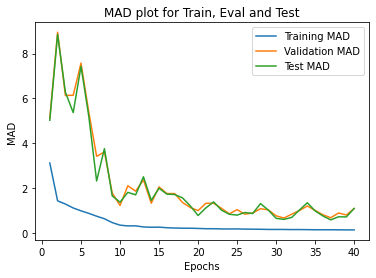

In [ ]:
chart_mad(n_epoch,train_MADPosit,eval_MADPosit, test_MADPosit)

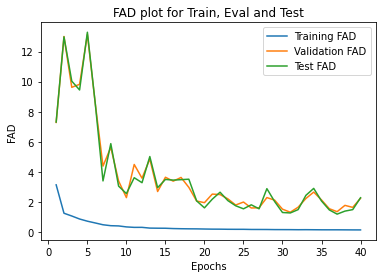

In [ ]:
chart_fad(n_epoch,train_FADPosit,eval_FADPosit, test_FADPosit)

### Experiment with Speed

In [ ]:
tr_dl, val_dl, test_dl, mean, std, preds_num, obs_num, batch_size, input_idx_1, input_idx_2, first_element, input_type, train_datasetS, val_datasetS, test_datasetS = createDatasetSpeed(12)

start loading dataset
validation set size -> 0
001 / 007 - loading uni_examples_train.txt
002 / 007 - loading crowds_zara02_train.txt
003 / 007 - loading biwi_hotel_train.txt
004 / 007 - loading students003_train.txt
005 / 007 - loading crowds_zara03_train.txt
006 / 007 - loading biwi_eth_train.txt
007 / 007 - loading students001_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading uni_examples_val.txt
002 / 007 - loading students001_val.txt
003 / 007 - loading crowds_zara03_val.txt
004 / 007 - loading crowds_zara02_val.txt
005 / 007 - loading students003_val.txt
006 / 007 - loading biwi_eth_val.txt
007 / 007 - loading biwi_hotel_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt


In [ ]:
enc_input_size, dec_input_size, dec_output_size, emb_size, ff_size, heads, layers, dropout, model = modelInstantiation()

In [ ]:
factor, warmup, optim = optimizer(emb_size, tr_dl, model)

In [ ]:
prS, n_epoch, lrS, train_MADS,eval_MADS, test_MADS, train_FADS,eval_FADS, test_FADS, train_vlossS, eval_vlossS, test_vlossS = mainPart(optim, tr_dl, val_dl, test_dl, model)

Start Training...

---> Epoch 005/040 <---  LR: 0.00280
Total Train Loss: 307.0875 - MAD:  0.4228 - FAD:  0.6733
Total Eval  Loss: 723.4220 - MAD:  1.5180 - FAD:  3.1906
Total Test  Loss: 800.6870 - MAD:  2.0368 - FAD:  3.6302 

---> Epoch 010/040 <---  LR: 0.00260
Total Train Loss: 179.8775 - MAD:  0.2567 - FAD:  0.3319
Total Eval  Loss: 509.2738 - MAD:  0.9867 - FAD:  1.9189
Total Test  Loss: 642.0142 - MAD:  1.7319 - FAD:  3.0054 

---> Epoch 015/040 <---  LR: 0.00209
Total Train Loss: 159.8173 - MAD:  0.1664 - FAD:  0.2214
Total Eval  Loss: 364.8933 - MAD:  0.6749 - FAD:  1.5461
Total Test  Loss: 374.7623 - MAD:  0.7029 - FAD:  1.6421 

---> Epoch 020/040 <---  LR: 0.00179
Total Train Loss: 106.6997 - MAD:  0.1239 - FAD:  0.1814
Total Eval  Loss: 237.1183 - MAD:  0.4290 - FAD:  0.9505
Total Test  Loss: 268.3716 - MAD:  0.4751 - FAD:  1.0643 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.00159
Total Train Loss: 98.5212 - MAD:  0.1216 - FAD:  0.1810
Total Eval  Loss: 270.95

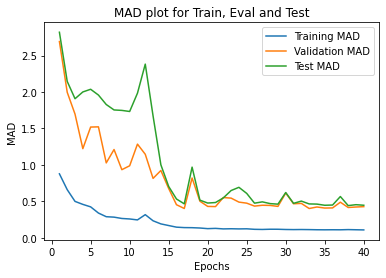

In [ ]:
chart_mad(n_epoch,train_MADS,eval_MADS, test_MADS)

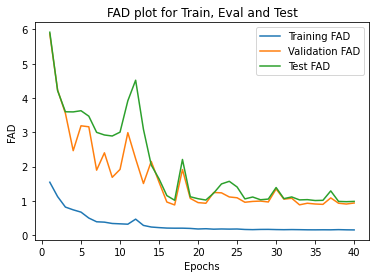

In [ ]:
chart_fad(n_epoch,train_FADS,eval_FADS, test_FADS)

In [ ]:
def chart_trajectory_con(test_dataset,seqs,pr,ax1,ax2,title):
 figure, axis = plt.subplots(ax1, ax2)
 figure.set_figheight(7)
 figure.set_figwidth(30)
 figure.suptitle(str(title))
 a=0

 for seq in seqs:
  x_S= test_dataset[seq]['src'][:,0:1].tolist()
  y_S= test_dataset[seq]['src'][:,1:2].tolist()


  x_t= test_dataset[seq]['trg'][:,0:1].tolist()
  y_t= test_dataset[seq]['trg'][:,1:2].tolist()

  predx=pr[seq][:,0].tolist()
  predy=pr[seq][:,1].tolist()

  axis[0+a].scatter(x_S, y_S,label="Observed")
  axis[0+a].scatter(x_t, y_t,label="Target")
  axis[0+a].scatter(predx, predy,label="Predicted")
  axis[0+a].set_xlabel('X')
  axis[0+a].set_ylabel('Y')
  axis[0+a].legend(loc='best')
  if a<ax2-1:
   a = a+1

### Results

We decided for this task to plot togheter the losses, mads and fads curves regarding the Test_set for each model 

In [ ]:
# We initialize these lists for plotting
epochs=[]
for i in range(1,41):
  epochs.append(i)

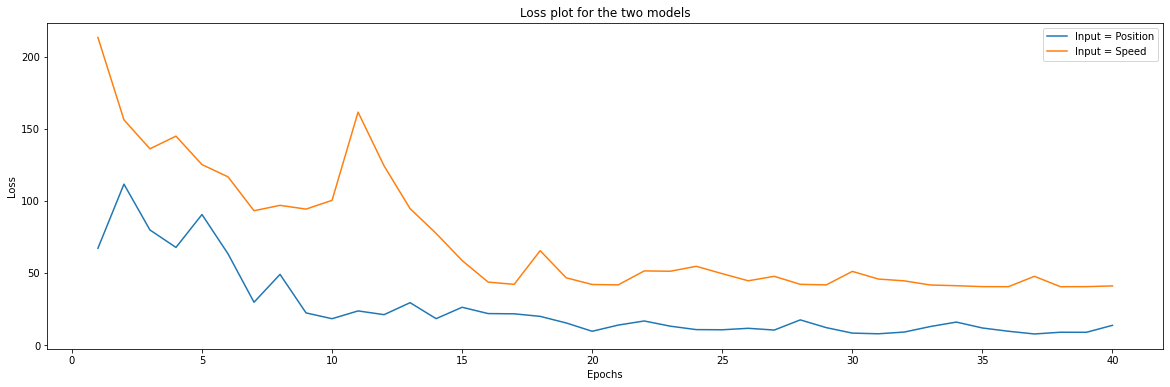

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(epochs, test_vlossPosit, label='Input = Position')
plt.plot(epochs, test_vlossS, label='Input = Speed')
plt.title('Loss plot for the two models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

From this graph we can tell that the loss is less in the case where input_type is equal to position. Also we can see that after reaching epoch 20 more or less both losses stabilize and begin to fluctuate in a small range.

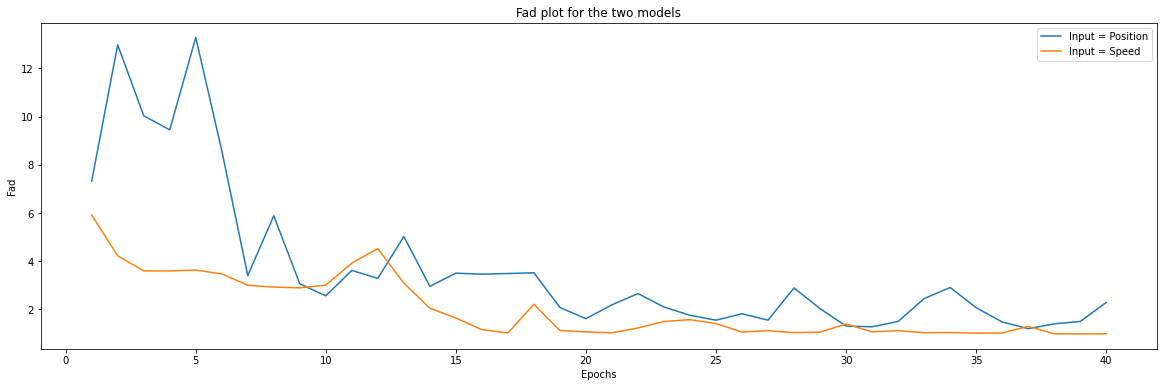

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(epochs, test_FADPosit, label='Input = Position')
plt.plot(epochs, test_FADS, label='Input = Speed')
plt.title('Fad plot for the two models')
plt.xlabel('Epochs')
plt.ylabel('Fad')
plt.legend(loc='best')
plt.show()

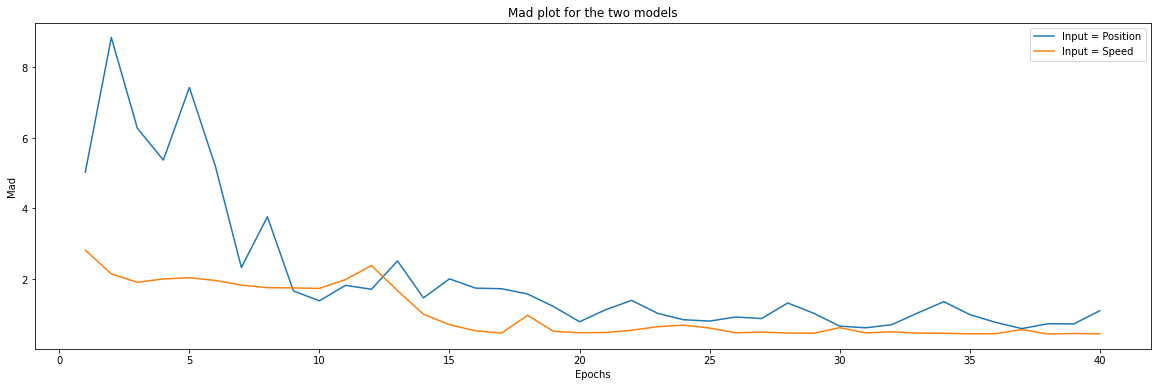

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(epochs, test_MADPosit, label='Input = Position')
plt.plot(epochs, test_MADS, label='Input = Speed')
plt.title('Mad plot for the two models')
plt.xlabel('Epochs')
plt.ylabel('Mad')
plt.legend(loc='best')
plt.show()

From the mad and fad graphs we can say that again, the results after the 20th epoch begin to stabilize, and these two metrics are slightly better in the case where the model imput is Speed

In [ ]:
# We initialize these lists of sequences
seqa=[1,20,30,40,70]
seqb=[7,10,80,100,3]

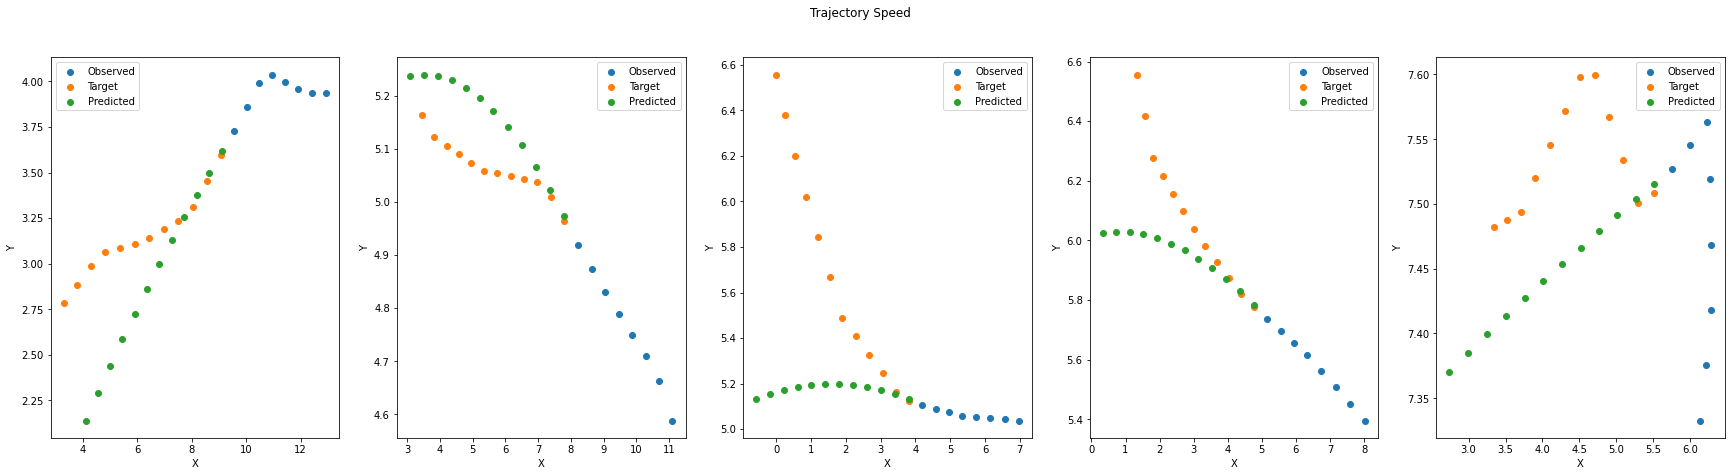

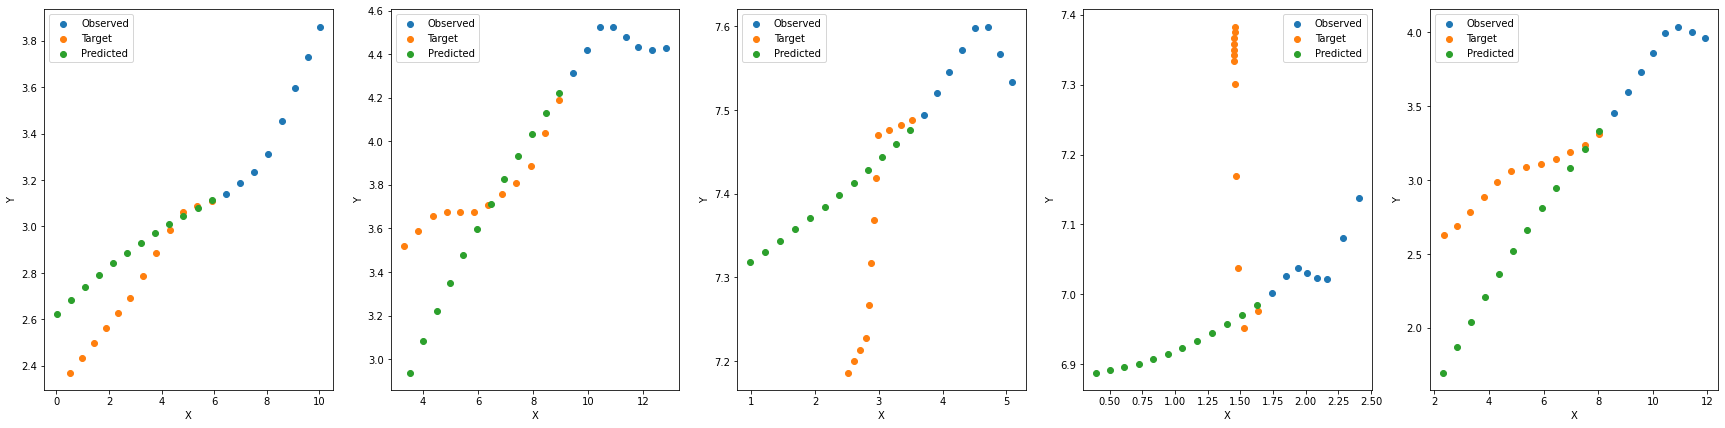

In [ ]:
chart_trajectory_con(test_datasetS,seqa,prS,1,5,'Trajectory Speed')
chart_trajectory_con(test_datasetS,seqb,prS,1,5,'')

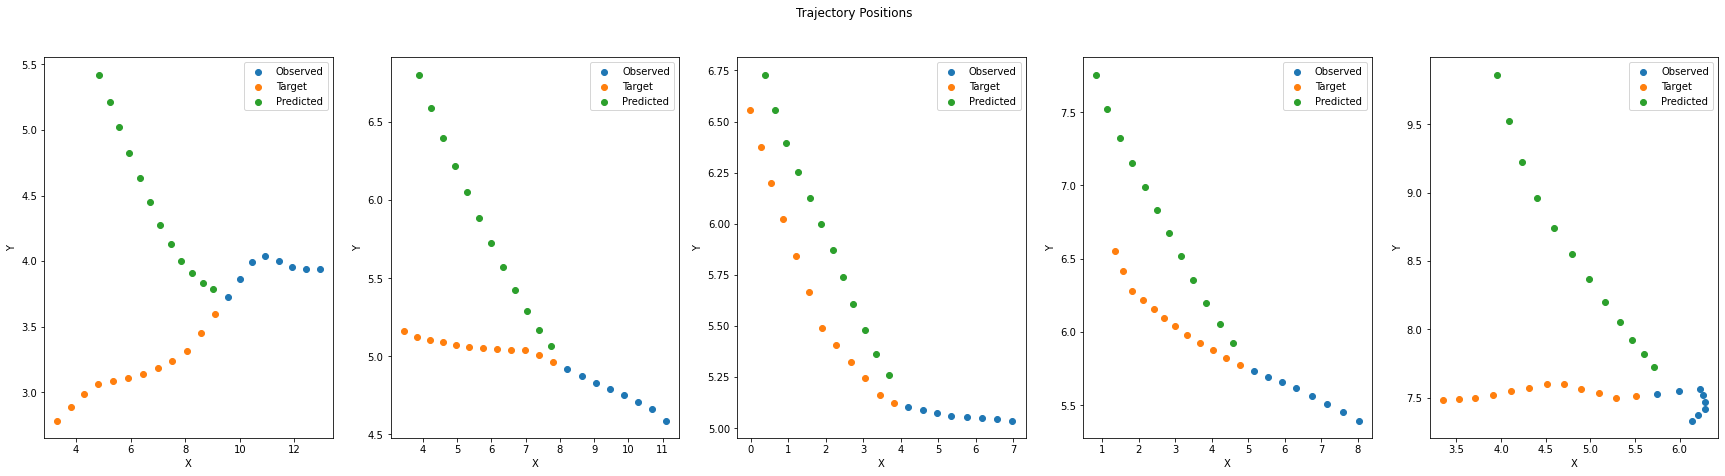

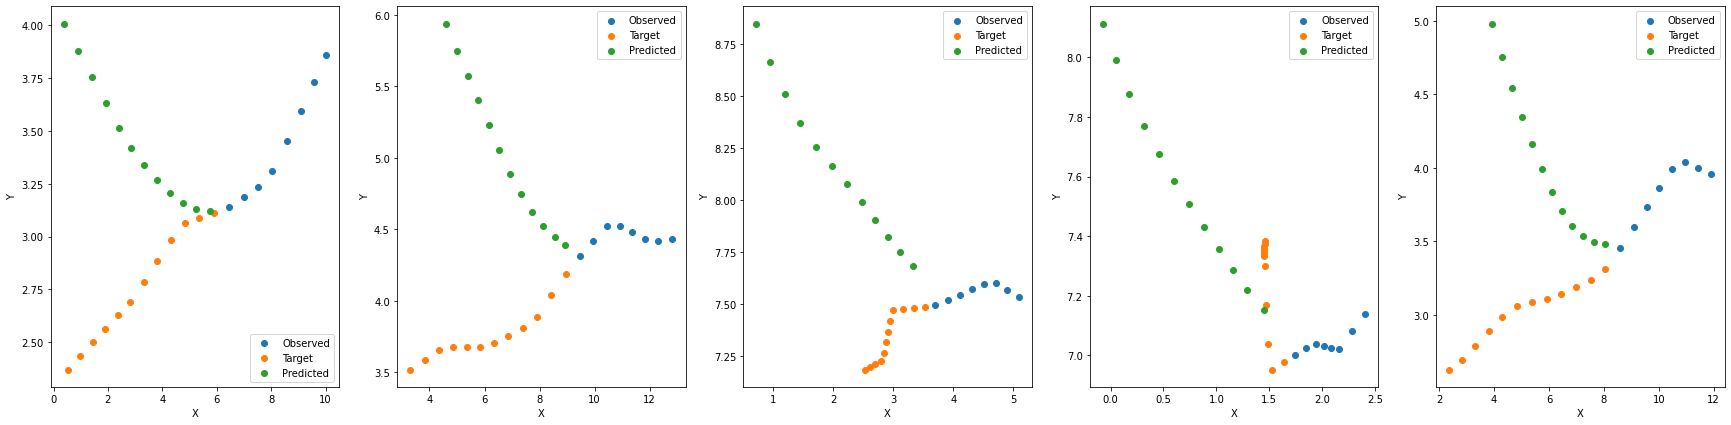

In [ ]:
chart_trajectory_con(test_datasetPosit,seqa,prPosit,1,5,'Trajectory Positions')
chart_trajectory_con(test_datasetPosit,seqb,prPosit,1,5,'')

We decided to represent the trajectories of 10 sequences for both models. From the graphs we can say that in the case of input=speed, the predictions are slightly better than those of the other model. This was possible to understand, as the fad and mad metrics of the model with speed were better

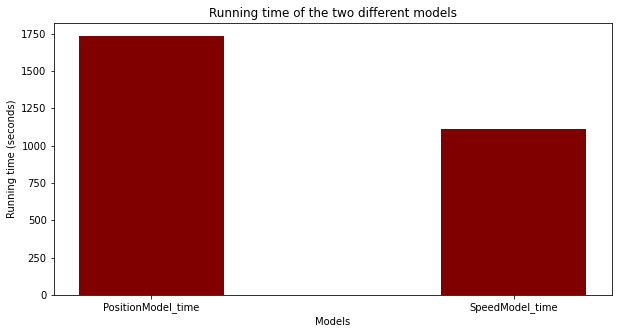

In [ ]:
position_time = 1734.78
speed_time = 1114.89

# Visualize the times
# creating the dataset
data = {'PositionModel_time':position_time, 'SpeedModel_time':speed_time}
models = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(models, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Models")
plt.ylabel("Running time (seconds)")
plt.title("Running time of the two different models")
plt.show()

Finally, we also compared the computational time of the two models, where it was noted that the model with position as input has a longer run time. 

## 5. Positional Encoding  (***3 POINTS*** - Bonus)

A number of positional encodings have been proposed. 

Implement the plain positional encoding [0,1,2,3,4,...] and report your comments and results.

Change the commented class we prepared in the positional_encoding.py file and copy the class here. 

Here your report


In [ ]:
# Here your code 

---

This notebook was created by Luca Franco and Alessandro Flaborea.